In [1]:
# # !pip3 install plotly
# !pip3 install --upgrade nbformat
#!pip install openpyxl
#!pip install dataframe-image

In [2]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import dataframe_image as dfi

In [3]:
def read_excel_sheets(file_path):
    
    vendors = pd.read_excel(file_path, sheet_name=None)
    
    def get_sheet(path, sheet_name):
        return pd.read_excel(path, sheet_name=sheet_name)
    
    dataframes = {}
    for sheet_name in vendors.keys():
        dataframes[sheet_name] = get_sheet(file_path, sheet_name)
    
    return dataframes

file_path = "/Users/shazeb.asad/Downloads/AT-FI savers Model.xlsx"
dataframes = read_excel_sheets(file_path)

In [4]:
sheet_name = "Data"  
df_sheet1 = dataframes[sheet_name]

# Filter the DataFrame where 'Vendor savers Flag' is 'No Savers'
filtered_df = df_sheet1[df_sheet1['Vendor savers Flag'] == 'No Savers']

# Group by 'entity_id' and create lists of unique 'chain_id'
result = filtered_df.groupby('entity_id')['chain_id'].apply(lambda x: list(set(x)))

# Convert the result to a dictionary of lists
result_dict = result.to_dict()

# Retrieve the lists for specific 'entity_id'
filtered_chain_id_austria_lst = result_dict.get('MJM_AT', [])
filtered_chain_id_finland_lst = result_dict.get('PO_FI', [])

# combined_lst = filtered_chain_id_austria_lst
# combined_lst.extend(filtered_chain_id_finland_lst)

# Join the lists into strings
finland_lst = ", ".join(f"'{item}'" for item in filtered_chain_id_finland_lst)
austria_lst = ", ".join(f"'{item}'" for item in filtered_chain_id_austria_lst)

# final_lst = ", ".join(f"'{item}'" for item in combined_lst)

In [5]:
def summary_control_variation(entity_id, start_date, end_date, entity_lst ):

  summary = f"""
  WITH test_d AS (
    SELECT
      country,
      variant,
      assignment_user_id,
      assignment_date,
      CASE 
        WHEN country = 'Austria' and LENGTH(assignment_user_id) > 6 THEN LEFT(assignment_user_id, LENGTH(assignment_user_id) - 6)
        WHEN country = 'Finland' THEN LEFT(assignment_user_id, LENGTH(assignment_user_id) - 5)
        ELSE assignment_user_id 
      END AS trim_assignment_user_id,
      ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
    FROM `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
    WHERE
      is_valid_assignment = 1
      AND test_id = "saver-delivery"
      AND assignment_date between \"""" + start_date + """\" and \"""" + end_date + """\"
  ),
  all_chains as (
  SELECT
    td.country,
    o.entity_id,
    td.variant,
    "ALL Chains" as target_group,
    COUNT(DISTINCT o.platform_order_code) total_orders,
    ROUND(SUM(o.revenue_eur),2) total_revenue,
    ROUND(SUM(o.delivery_costs_eur),2) delivery_costs_eur,
    ROUND(SUM(o.commission_eur),2) total_commission,
    ROUND(SUM(o.delivery_fee_eur),2) total_delivery_fee_eur,
    ROUND(SUM(o.profit_eur),2) total_profit,
    (ROUND(SUM(o.revenue_eur),2) - ROUND(SUM(o.delivery_costs_eur),2)) / ROUND(COUNT (DISTINCT trim_assignment_user_id),2) cm_per_user,
    ROUND(COUNT(DISTINCT o.platform_order_code) / COUNT (DISTINCT trim_assignment_user_id),2) orders_per_user,
    ROUND(SUM(o.revenue_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_revenue,
    ROUND(SUM(o.delivery_costs_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_delivery_cost,
    ROUND(SUM(o.profit_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_profit,
    ROUND(SUM(o.delivery_fee_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_df,
    ROUND(SUM(o.commission_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_commission,
    ROUND(AVG(o.delivery_distance), 2) AS avg_delivery_distance
  FROM test_d td
  INNER JOIN `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    ON o.country_name = td.country 
    AND o.customer_account_id = td.trim_assignment_user_id
  WHERE
    td.row_num = 1
    AND o.created_date >= td.assignment_date
    AND o.entity_id IN ( """ + entity_id + """ )
    AND is_sent = True
    AND is_own_delivery = True
  GROUP BY td.country, o.entity_id, td.variant, target_group
  order by target_group, td.variant, o.entity_id
  ),
  chains as (
  SELECT
    td.country,
    o.entity_id,
    td.variant,
    Case 
      WHEN o.chain_id in ( """ + entity_lst + """ ) then "Chains not in targeting"
      ELSE "Chains in targeting"
    END AS target_group,
    COUNT(DISTINCT o.platform_order_code) total_orders,
    ROUND(SUM(o.revenue_eur),2) total_revenue,
    ROUND(SUM(o.delivery_costs_eur),2) delivery_costs_eur,
    ROUND(SUM(o.commission_eur),2) total_commission,
    ROUND(SUM(o.delivery_fee_eur),2) total_delivery_fee_eur,
    ROUND(SUM(o.profit_eur),2) total_profit,
    ROUND((ROUND(SUM(o.revenue_eur),2) - ROUND(SUM(o.delivery_costs_eur),2)) / ROUND(COUNT (DISTINCT trim_assignment_user_id),2),2) cm_per_user,
    ROUND(COUNT(DISTINCT o.platform_order_code) / COUNT (DISTINCT trim_assignment_user_id),2) orders_per_user,
    ROUND(SUM(o.revenue_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_revenue,
    ROUND(SUM(o.delivery_costs_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_delivery_cost,
    ROUND(SUM(o.profit_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_profit,
    ROUND(SUM(o.delivery_fee_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_df,
    ROUND(SUM(o.commission_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_commission,
    ROUND(AVG(o.delivery_distance), 2) AS avg_delivery_distance
  FROM test_d td
  INNER JOIN `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    ON o.country_name = td.country 
    AND o.customer_account_id = td.trim_assignment_user_id
  WHERE
    td.row_num = 1
    AND o.created_date >= td.assignment_date
    AND o.entity_id IN ( """ + entity_id + """ )
    AND is_sent = TRUE
    AND is_own_delivery = True
  GROUP BY td.country, o.entity_id, td.variant, target_group 
  order by target_group, td.variant, o.entity_id
  )
  select *
  from (Select * from all_chains
        UNION ALL
        select * from chains)
  order by target_group, variant, entity_id

  """
  
  return summary



def summary(entity_id, start_date, end_date, entity_lst ):

  summary = f"""
  WITH test_d AS (
    SELECT
      country,
      variant,
      assignment_user_id,
      assignment_date,
      CASE 
        WHEN country = 'Austria' and LENGTH(assignment_user_id) > 6 THEN LEFT(assignment_user_id, LENGTH(assignment_user_id) - 6)
        WHEN country = 'Finland' THEN LEFT(assignment_user_id, LENGTH(assignment_user_id) - 5)
        ELSE assignment_user_id 
      END AS trim_assignment_user_id,
      ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
    FROM `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
    WHERE
      is_valid_assignment = 1
      AND test_id = "saver-delivery"
      AND assignment_date between \"""" + start_date + """\" and \"""" + end_date + """\"
  ),
  all_chains as (
  SELECT
    td.country,
    o.entity_id,
    td.variant,
    CASE
      WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
      WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
      WHEN COALESCE(o.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
    END AS category,
    "ALL Chains" as target_group,
    COUNT(DISTINCT o.platform_order_code) total_orders,
    ROUND(SUM(o.revenue_eur),2) total_revenue,
    ROUND(SUM(o.delivery_costs_eur),2) delivery_costs_eur,
    ROUND(SUM(o.commission_eur),2) total_commission,
    ROUND(SUM(o.delivery_fee_eur),2) total_delivery_fee_eur,
    ROUND(SUM(o.profit_eur),2) total_profit,
    ROUND((ROUND(SUM(o.revenue_eur),2) - ROUND(SUM(o.delivery_costs_eur),2)) / ROUND(COUNT (DISTINCT trim_assignment_user_id),2),2) cm_per_user,
    ROUND(COUNT(DISTINCT o.platform_order_code) / COUNT (DISTINCT trim_assignment_user_id),2) orders_per_user,
    ROUND(SUM(o.revenue_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_revenue,
    ROUND(SUM(o.delivery_costs_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_delivery_cost,
    ROUND(SUM(o.profit_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_profit,
    ROUND(SUM(o.delivery_fee_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_df,
    ROUND(SUM(o.commission_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_commission,
    ROUND(AVG(o.delivery_distance), 2) AS avg_delivery_distance
  FROM test_d td
  INNER JOIN `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    ON o.country_name = td.country 
    AND o.customer_account_id = td.trim_assignment_user_id
  WHERE
    td.row_num = 1
    AND o.created_date >= td.assignment_date
    AND o.entity_id IN ( """ + entity_id + """ )
    AND is_sent = True
    AND is_own_delivery = True
  GROUP BY td.country, o.entity_id, td.variant, category, target_group
  order by target_group, category, td.variant, o.entity_id
  ),
  chains as (
  SELECT
    td.country,
    o.entity_id,
    td.variant,
    CASE
      WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
      WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
      WHEN COALESCE(o.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
    END AS category,
    Case 
      WHEN o.chain_id in ( """ + entity_lst + """ ) then "Chains not in targeting"
      ELSE "Chains in targeting"
    END AS target_group,
    COUNT(DISTINCT o.platform_order_code) total_orders,
    ROUND(SUM(o.revenue_eur),2) total_revenue,
    ROUND(SUM(o.delivery_costs_eur),2) delivery_costs_eur,
    ROUND(SUM(o.commission_eur),2) total_commission,
    ROUND(SUM(o.delivery_fee_eur),2) total_delivery_fee_eur,
    ROUND(SUM(o.profit_eur),2) total_profit,
    ROUND((ROUND(SUM(o.revenue_eur),2) - ROUND(SUM(o.delivery_costs_eur),2)) / ROUND(COUNT (DISTINCT trim_assignment_user_id),2),2) cm_per_user,
    ROUND(COUNT(DISTINCT o.platform_order_code) / COUNT (DISTINCT trim_assignment_user_id),2) orders_per_user,
    ROUND(SUM(o.revenue_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_revenue,
    ROUND(SUM(o.delivery_costs_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_delivery_cost,
    ROUND(SUM(o.profit_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_profit,
    ROUND(SUM(o.delivery_fee_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_df,
    ROUND(SUM(o.commission_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_commission,
    ROUND(AVG(o.delivery_distance), 2) AS avg_delivery_distance
  FROM test_d td
  INNER JOIN `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    ON o.country_name = td.country 
    AND o.customer_account_id = td.trim_assignment_user_id
  WHERE
    td.row_num = 1
    AND o.created_date >= td.assignment_date
    AND o.entity_id IN ( """ + entity_id + """ )
    AND is_sent = TRUE
    AND is_own_delivery = True
  GROUP BY td.country, o.entity_id, td.variant, category, target_group 
  order by target_group, category, td.variant, o.entity_id
  )
  select *
  from (Select * from all_chains
        UNION ALL
        select * from chains)
  order by target_group, category, variant, entity_id

  """
  
  return summary




def details(entity_id, start_date, end_date, entity_lst):

  details = f"""
  WITH test_d AS (
    SELECT
      country,
      variant,
      assignment_user_id,
      assignment_date,
      CASE 
          WHEN country = 'Austria' and LENGTH(assignment_user_id) > 6 THEN LEFT(assignment_user_id, LENGTH(assignment_user_id) - 6)
          WHEN country = 'Finland' THEN LEFT(assignment_user_id, LENGTH(assignment_user_id) - 5)
        ELSE assignment_user_id 
      END AS trim_assignment_user_id,
      ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
    FROM `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
    WHERE
      is_valid_assignment = 1
      AND test_id = "saver-delivery"
      AND assignment_date between \"""" + start_date + """\" and \"""" + end_date + """\"
  )
  SELECT
    td.country,
    o.city_name,
    o.entity_id,
    td.variant,
    CASE
        WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
        WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
        WHEN COALESCE(o.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
    END AS category,
    Case 
      WHEN o.chain_id in ( """ + entity_lst + """ ) then "Chains not in targeting"
      ELSE "Chains in targeting"
    END AS target_group,
    perseus_client_id,
    o.vendor_id,
    o.chain_id,
    o.platform_order_code,
    o.revenue_eur,
    o.delivery_costs_eur AS avg_delivery_cost,
    o.commission_eur commission,
    o.profit_eur avg_profit,
    coalesce(o.delivery_fee_eur, o.priority_fee_eur, coalesce(o.saver_discount_eur,0)) delivery_fee_eur,
    o.dps_delivery_fee_eur,
    o.priority_fee_eur,
    o.saver_discount_eur,
    o.discount_dh_eur,
    o.discount_other_eur,
    o.voucher_dh_eur,
    o.voucher_other_eur,
    o.mov_customer_fee_eur,
    o.subscription_discount_type,
    o.commission_eur,
    o.delivery_distance,
    o.actual_delivery_time
  FROM test_d td
  INNER JOIN `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
    ON o.country_name = td.country 
    AND o.customer_account_id = td.trim_assignment_user_id
  WHERE
    td.row_num = 1
    AND o.created_date >= td.assignment_date
    AND o.entity_id IN ( """ + entity_id + """ )
    AND is_sent = TRUE
    AND is_own_delivery = True

  """

In [6]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)
entity_austria = "'MJM_AT'"
entity_finland = "'PO_FI'"
start_date = '2024-07-15'
end_date = '2024-07-29'


austria_chains_s = client.query(summary(entity_austria,start_date,end_date, austria_lst)).to_dataframe()
finland_chains_s = client.query(summary(entity_finland,start_date,end_date, finland_lst)).to_dataframe()


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [7]:
## summary ## 
display(austria_chains_s)
display(finland_chains_s)

,country,entity_id,variant,category,target_group,total_orders,total_revenue,delivery_costs_eur,total_commission,total_delivery_fee_eur,total_profit,cm_per_user,orders_per_user,avg_revenue,avg_delivery_cost,avg_profit,avg_df,avg_commission,avg_delivery_distance
0,Austria,MJM_AT,Control,priority,ALL Chains,5235,73012.01,29060.37,41837.040000000,16381.330000000,43951.64,22.86,2.72,13.95,5.55,8.40,3.130000000,7.990000000,2.41
1,Austria,MJM_AT,Variation1,priority,ALL Chains,5895,83639.20,32346.26,48179.310000000,18737.610000000,51292.93,22.99,2.64,14.19,5.49,8.70,3.180000000,8.170000000,2.45
2,Austria,MJM_AT,Variation1,saver,ALL Chains,4358,40839.36,18907.39,27106.510000000,10719.320000000,21931.98,6.20,1.23,9.37,4.34,5.03,2.460000000,6.220000000,2.12
3,Austria,MJM_AT,Control,standard,ALL Chains,172169,1603415.40,819583.78,1057446.440000000,474221.960000000,783831.61,19.51,4.29,9.31,4.76,4.55,2.750000000,6.140000000,2.05
4,Austria,MJM_AT,Variation1,standard,ALL Chains,166831,1546716.68,790737.01,1020723.280000000,458019.040000000,755979.66,19.24,4.25,9.27,4.74,4.53,2.750000000,6.120000000,2.04
5,Austria,MJM_AT,Control,priority,Chains in targeting,3691,55198.84,20158.69,32737.210000000,11436.140000000,35040.15,21.72,2.29,14.95,5.46,9.49,3.100000000,8.870000000,2.59
6,Austria,MJM_AT,Variation1,priority,Chains in targeting,4220,63883.82,22706.47,38003.910000000,13324.690000000,41177.35,21.46,2.20,15.14,5.38,9.76,3.160000000,9.010000000,2.60
7,Austria,MJM_AT,Variation1,saver,Chains in targeting,4357,40835.03,18902.89,27103.160000000,10718.530000000,21932.14,6.21,1.23,9.37,4.34,5.03,2.460000000,6.220000000,2.12
8,Austria,MJM_AT,Control,standard,Chains in targeting,132951,1300409.29,625511.84,869399.130000000,361249.080000000,674897.45,17.00,3.35,9.78,4.70,5.08,2.720000000,6.540000000,2.13
9,Austria,MJM_AT,Variation1,standard,Chains in targeting,127347,1242569.51,596315.81,831427.450000000,344678.200000000,646253.71,16.76,3.30,9.76,4.68,5.07,2.710000000,6.530000000,2.12


,country,entity_id,variant,category,target_group,total_orders,total_revenue,delivery_costs_eur,total_commission,total_delivery_fee_eur,total_profit,cm_per_user,orders_per_user,avg_revenue,avg_delivery_cost,avg_profit,avg_df,avg_commission,avg_delivery_distance
0,Finland,PO_FI,Control,priority,ALL Chains,993,11103.89,6727.27,4960.840000000,3607.750000000,4376.62,9.10,2.06,11.18,6.77,4.41,3.630000000,5.000000000,2.86
1,Finland,PO_FI,Variation1,priority,ALL Chains,1103,12277.88,7238.52,5386.040000000,3821.950000000,5039.36,8.51,1.86,11.13,6.56,4.57,3.470000000,4.880000000,2.83
2,Finland,PO_FI,Variation1,saver,ALL Chains,1228,12465.59,6979.44,5678.260000000,3749.170000000,5486.15,5.10,1.14,10.15,5.68,4.47,3.050000000,4.620000000,2.54
3,Finland,PO_FI,Control,standard,ALL Chains,34497,316033.11,201219.22,148888.130000000,104176.690000000,114813.89,8.74,2.63,9.16,5.83,3.33,3.020000000,4.320000000,2.26
4,Finland,PO_FI,Variation1,standard,ALL Chains,32549,295647.71,190033.66,140100.030000000,97186.520000000,105614.05,8.45,2.60,9.08,5.84,3.24,2.990000000,4.300000000,2.25
5,Finland,PO_FI,Control,priority,Chains in targeting,637,8407.88,4630.81,4131.700000000,2459.000000000,3777.07,9.68,1.63,13.20,7.27,5.93,3.860000000,6.490000000,3.24
6,Finland,PO_FI,Variation1,priority,Chains in targeting,768,9624.08,5267.01,4512.150000000,2736.370000000,4357.07,8.86,1.56,12.53,6.86,5.67,3.560000000,5.880000000,3.10
7,Finland,PO_FI,Variation1,saver,Chains in targeting,1202,12264.41,6811.91,5604.450000000,3667.880000000,5452.50,5.18,1.14,10.20,5.67,4.54,3.050000000,4.660000000,2.54
8,Finland,PO_FI,Control,standard,Chains in targeting,26236,267888.02,157295.34,130880.960000000,81492.850000000,110592.68,8.71,2.07,10.21,6.00,4.22,3.110000000,4.990000000,2.40
9,Finland,PO_FI,Variation1,standard,Chains in targeting,24731,250153.56,148230.23,122783.780000000,75857.340000000,101923.33,8.50,2.06,10.11,5.99,4.12,3.070000000,4.960000000,2.39


In [13]:
test = pd.concat([austria_chains_s, finland_chains_s], ignore_index=True)
test.to_csv('saver_analysis.csv')

In [8]:
def process_and_export(df, int_columns, float_columns, file_name):
    """
    Process and export the dataframe with specified column types.

    Parameters:
    - df: The dataframe to process.
    - int_columns: List of column names to be converted to integers.
    - float_columns: List of column names to be converted to floats.
    - file_name: The name of the file to export the dataframe image to.
    """
    # Convert specified columns to integers
    df[int_columns] = df[int_columns].astype(int)
    
    # Convert specified columns to floats
    df[float_columns] = df[float_columns].astype(float)
    df[float_columns] = df[float_columns].round(2)
    
    try:
        # Filter dataframe
        df_filtered = df[
            (df['category'] != 'saver') |
            (df['target_group'] != 'Chains not in targeting')
        ]
    except: 
        df_filtered = df.copy()
    
    # Export to image
    dfi.export(df_filtered, file_name, table_conversion="matplotlib")

# Example usage:
# Integer and float columns for Austria dataset
austria_int_columns = ['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit','total_commission','total_delivery_fee_eur']
austria_float_columns = ['orders_per_user', 'avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df', 'avg_commission', 'avg_delivery_distance','cm_per_user']
process_and_export(austria_chains_s, austria_int_columns, austria_float_columns, "austria_chains_s_filtered.png")

# Integer and float columns for Finland dataset
finland_int_columns = ['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit','total_commission','total_delivery_fee_eur']
finland_float_columns = ['orders_per_user', 'avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df', 'avg_commission', 'avg_delivery_distance','cm_per_user']
process_and_export(finland_chains_s, finland_int_columns, finland_float_columns, "finland_chains_s_filtered.png")

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/dataframe_image/converter/matplotlib_table.py:147: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not thead and not tbody:
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/dataframe_image/converter/matplotlib_table.py:147: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not thead and not tbody:


In [9]:
display(austria_chains_s)
display(finland_chains_s)

,country,entity_id,variant,category,target_group,total_orders,total_revenue,delivery_costs_eur,total_commission,total_delivery_fee_eur,total_profit,cm_per_user,orders_per_user,avg_revenue,avg_delivery_cost,avg_profit,avg_df,avg_commission,avg_delivery_distance
0,Austria,MJM_AT,Control,priority,ALL Chains,5235,73012,29060,41837,16381,43951,22.86,2.72,13.95,5.55,8.40,3.13,7.99,2.41
1,Austria,MJM_AT,Variation1,priority,ALL Chains,5895,83639,32346,48179,18737,51292,22.99,2.64,14.19,5.49,8.70,3.18,8.17,2.45
2,Austria,MJM_AT,Variation1,saver,ALL Chains,4358,40839,18907,27106,10719,21931,6.20,1.23,9.37,4.34,5.03,2.46,6.22,2.12
3,Austria,MJM_AT,Control,standard,ALL Chains,172169,1603415,819583,1057446,474221,783831,19.51,4.29,9.31,4.76,4.55,2.75,6.14,2.05
4,Austria,MJM_AT,Variation1,standard,ALL Chains,166831,1546716,790737,1020723,458019,755979,19.24,4.25,9.27,4.74,4.53,2.75,6.12,2.04
5,Austria,MJM_AT,Control,priority,Chains in targeting,3691,55198,20158,32737,11436,35040,21.72,2.29,14.95,5.46,9.49,3.10,8.87,2.59
6,Austria,MJM_AT,Variation1,priority,Chains in targeting,4220,63883,22706,38003,13324,41177,21.46,2.20,15.14,5.38,9.76,3.16,9.01,2.60
7,Austria,MJM_AT,Variation1,saver,Chains in targeting,4357,40835,18902,27103,10718,21932,6.21,1.23,9.37,4.34,5.03,2.46,6.22,2.12
8,Austria,MJM_AT,Control,standard,Chains in targeting,132951,1300409,625511,869399,361249,674897,17.00,3.35,9.78,4.70,5.08,2.72,6.54,2.13
9,Austria,MJM_AT,Variation1,standard,Chains in targeting,127347,1242569,596315,831427,344678,646253,16.76,3.30,9.76,4.68,5.07,2.71,6.53,2.12


,country,entity_id,variant,category,target_group,total_orders,total_revenue,delivery_costs_eur,total_commission,total_delivery_fee_eur,total_profit,cm_per_user,orders_per_user,avg_revenue,avg_delivery_cost,avg_profit,avg_df,avg_commission,avg_delivery_distance
0,Finland,PO_FI,Control,priority,ALL Chains,993,11103,6727,4960,3607,4376,9.10,2.06,11.18,6.77,4.41,3.63,5.00,2.86
1,Finland,PO_FI,Variation1,priority,ALL Chains,1103,12277,7238,5386,3821,5039,8.51,1.86,11.13,6.56,4.57,3.47,4.88,2.83
2,Finland,PO_FI,Variation1,saver,ALL Chains,1228,12465,6979,5678,3749,5486,5.10,1.14,10.15,5.68,4.47,3.05,4.62,2.54
3,Finland,PO_FI,Control,standard,ALL Chains,34497,316033,201219,148888,104176,114813,8.74,2.63,9.16,5.83,3.33,3.02,4.32,2.26
4,Finland,PO_FI,Variation1,standard,ALL Chains,32549,295647,190033,140100,97186,105614,8.45,2.60,9.08,5.84,3.24,2.99,4.30,2.25
5,Finland,PO_FI,Control,priority,Chains in targeting,637,8407,4630,4131,2459,3777,9.68,1.63,13.20,7.27,5.93,3.86,6.49,3.24
6,Finland,PO_FI,Variation1,priority,Chains in targeting,768,9624,5267,4512,2736,4357,8.86,1.56,12.53,6.86,5.67,3.56,5.88,3.10
7,Finland,PO_FI,Variation1,saver,Chains in targeting,1202,12264,6811,5604,3667,5452,5.18,1.14,10.20,5.67,4.54,3.05,4.66,2.54
8,Finland,PO_FI,Control,standard,Chains in targeting,26236,267888,157295,130880,81492,110592,8.71,2.07,10.21,6.00,4.22,3.11,4.99,2.40
9,Finland,PO_FI,Variation1,standard,Chains in targeting,24731,250153,148230,122783,75857,101923,8.50,2.06,10.11,5.99,4.12,3.07,4.96,2.39


In [253]:
austria_chains_s_cv = client.query(summary_control_variation(entity_austria,start_date,end_date, austria_lst)).to_dataframe()
finland_chains_s_cv = client.query(summary_control_variation(entity_finland,start_date,end_date, finland_lst)).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [254]:
# Integer and float columns for Finland dataset
a_int_columns = ['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit','total_commission','total_delivery_fee_eur']
a_float_columns = ['orders_per_user', 'avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df', 'avg_commission', 'avg_delivery_distance','cm_per_user']
process_and_export(austria_chains_s_cv, a_int_columns, a_float_columns, "austria_chains_s_cv.png")

# Integer and float columns for Finland dataset
f_int_columns = ['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit','total_commission','total_delivery_fee_eur']
f_float_columns = ['orders_per_user', 'avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df', 'avg_commission', 'avg_delivery_distance','cm_per_user']
process_and_export(finland_chains_s_cv, a_int_columns, a_float_columns, "finland_chains_s_cv.png")

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/dataframe_image/converter/matplotlib_table.py:147: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not thead and not tbody:
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/dataframe_image/converter/matplotlib_table.py:147: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not thead and not tbody:


In [255]:
finland_chains_s_cv

,country,entity_id,variant,target_group,total_orders,total_revenue,delivery_costs_eur,total_commission,total_delivery_fee_eur,total_profit,cm_per_user,orders_per_user,avg_revenue,avg_delivery_cost,avg_profit,avg_df,avg_commission,avg_delivery_distance
0,Finland,PO_FI,Control,ALL Chains,27968,264119,164470,125375,86727,99649,7.58,2.13,9.44,5.88,3.56,3.10,4.48,2.29
1,Finland,PO_FI,Variation1,ALL Chains,27571,259635,162120,123305,84861,97514,7.46,2.11,9.42,5.88,3.54,3.08,4.47,2.31
2,Finland,PO_FI,Control,Chains in targeting,22088,229021,133026,112371,70258,95995,7.55,1.74,10.37,6.02,4.35,3.18,5.09,2.42
3,Finland,PO_FI,Variation1,Chains in targeting,22001,226618,132192,110792,69477,94425,7.46,1.74,10.30,6.01,4.29,3.16,5.04,2.43
4,Finland,PO_FI,Control,Chains not in targeting,5880,35098,31444,13003,16469,3653,1.11,1.78,5.97,5.35,0.62,2.80,2.21,1.82
5,Finland,PO_FI,Variation1,Chains not in targeting,5570,33017,29928,12513,15383,3089,0.96,1.74,5.93,5.37,0.55,2.76,2.25,1.83


In [256]:
austria_chains_s_cv

,country,entity_id,variant,target_group,total_orders,total_revenue,delivery_costs_eur,total_commission,total_delivery_fee_eur,total_profit,cm_per_user,orders_per_user,avg_revenue,avg_delivery_cost,avg_profit,avg_df,avg_commission,avg_delivery_distance
0,Austria,MJM_AT,Control,ALL Chains,131533,1254994,635840,824632,364598,619153,15.43,3.28,9.54,4.83,4.71,2.77,6.27,2.06
1,Austria,MJM_AT,Variation1,ALL Chains,131897,1256461,632774,825900,363636,623687,15.48,3.27,9.53,4.80,4.73,2.76,6.26,2.05
2,Austria,MJM_AT,Control,Chains in targeting,104207,1040771,498951,694128,284348,541819,13.65,2.63,9.99,4.79,5.20,2.73,6.66,2.13
3,Austria,MJM_AT,Variation1,Chains in targeting,104256,1039128,494772,693275,282366,544355,13.65,2.62,9.97,4.75,5.22,2.71,6.65,2.13
4,Austria,MJM_AT,Control,Chains not in targeting,27326,214223,136888,130504,80249,77334,5.88,2.08,7.84,5.01,2.83,2.94,4.78,1.76
5,Austria,MJM_AT,Variation1,Chains not in targeting,27641,217333,138001,132624,81269,79331,5.98,2.08,7.86,4.99,2.87,2.94,4.80,1.75


In [52]:
# austria_details = client.query(austria_d).to_dataframe()

# austria_details[['delivery_fee_eur','priority_fee_eur','saver_discount_eur','discount_dh_eur','discount_other_eur','voucher_dh_eur','voucher_other_eur','mov_customer_fee_eur']] = finland_details[['delivery_fee_eur','priority_fee_eur','saver_discount_eur','discount_dh_eur','discount_other_eur','voucher_dh_eur','voucher_other_eur','mov_customer_fee_eur']].astype(float)
# austria_details = austria_details[austria_details['delivery_distance'] != 0]

# austria_details

In [110]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# entity_id = ['MJM_AT', 'PO_FI']
# start_date = '2024-05-06'
# end_date = '2024-06-17'


# # Initialize the BigQuery client
# client.query(summary(entity_id,start_date, end_date, austria_lst )).to_dataframe()

In [148]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# entity_id = "'MJM_AT, PO_FI'"
# start_date = '2024-05-06'
# end_date = '2024-06-17'



# # Run the query
# query_job = client.query(query, job_config=job_config)

# # Convert the results to a DataFrame
# df = query_job.to_dataframe()


# df = run_austria_chains_query(start_date, end_date, entity_id, entity_lst)
# print(df)

In [ ]:
# # Initialize the BigQuery client
# client = bigquery.Client()

# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# entity_id = "'MJM_AT, PO_FI'"
# start_date = '2024-05-06'
# end_date = '2024-06-17'

# # Define query parameters
# job_config = bigquery.QueryJobConfig(
#     query_parameters=[
#         bigquery.ScalarQueryParameter("start_date", "STRING", start_date),
#         bigquery.ScalarQueryParameter("end_date", "STRING", end_date),
#         bigquery.ArrayQueryParameter("entity_id", "STRING", entity_id.split(',')),
#         bigquery.ArrayQueryParameter("entity_lst", "STRING", entity_lst.split(','))
#     ]
# )

# # Run the query
# austria = client.query(query, job_config=job_config)

# # Convert the results to a DataFrame
# df = query_job.to_dataframe()




#austria_all_chains_d = client.query(austria_all).to_dataframe()
austria_chains_d = client.query(austria_chains).to_dataframe()

# austria_combined_summary = pd.concat([austria_all_chains_d, austria_chains_d])
# austria_combined_summary

# austria_chains_d

/Users/shazeb.asad/Library/Python/3.9/lib/python/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [247]:
# sm = austria_combined_summary[austria_combined_summary['category'] == 'standard'][['country','entity_id','variant','category','target_group','avg_revenue','avg_delivery_cost','avg_profit','avg_df','avg_commission','avg_delivery_distance']]

# sm[['avg_df','avg_commission']] = sm[['avg_df','avg_commission']].astype(float) 

# sm.reset_index()

In [66]:
# austria_combined_summary[['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit',
#              'avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df',
#              'avg_commission', 'avg_delivery_distance']] = austria_combined_summary[['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit',
#                                                                          'avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df',
#                                                                          'avg_commission', 'avg_delivery_distance']].astype(float)

# austria_combined_summary[['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit']] = austria_combined_summary[['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit']].round(0)
# austria_combined_summary[['avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df',
#        'avg_commission', 'avg_delivery_distance']] = austria_combined_summary[['avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df',
#        'avg_commission', 'avg_delivery_distance']].round(2)

# austria_tmp = austria_combined_summary[(austria_combined_summary['category'].isin(['standard'])) & (austria_combined_summary['target_group'].isin(['Chains in targeting']))][['variant','total_orders','total_revenue','total_profit','delivery_costs_eur','avg_df']]

# austria_sum = austria_tmp.set_index('variant').T
# austria_sum['% Change'] = 100 * ((austria_sum['Variation1'] - austria_sum['Control']) / austria_sum['Control'])
# austria_sum

variant,Control,Variation1,% Change
total_orders,271267.00,257383.00,-5.118205
total_revenue,2626011.00,2489450.00,-5.200321
total_profit,1283701.00,1217105.00,-5.187812
delivery_costs_eur,2626011.00,2489450.00,-5.200321
avg_df,2.58,2.56,-0.775194


In [152]:
# entity_id = 'PO_FI'

# finland_all = f"""
# WITH perseus AS (
# SELECT
# *,
# LEFT(assignment_user_id, LENGTH(assignment_user_id) - 5) AS trim_assignment_user_id,
# ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
# FROM
# `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
# WHERE
# is_valid_assignment = 1
# AND test_id = "saver-delivery"
# AND assignment_date >= "2024-05-06"
# AND assignment_date<"2024-06-17"
# )
# SELECT
# p.country,
# o.entity_id,
# p.variant,
# o.is_sent,
# CASE
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
#     WHEN COALESCE(o.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
# END AS category,
# "ALL Chains" as target_group,
# COUNT(DISTINCT o.platform_order_code) total_orders,
# ROUND(SUM(o.revenue_eur),2) total_revenue,
# ROUND(SUM(o.revenue_eur),2) delivery_costs_eur,
# ROUND(SUM(o.profit_eur),2) total_profit,
# ROUND(SUM(o.revenue_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_revenue,
# ROUND(SUM(o.delivery_costs_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_delivery_cost,
# ROUND(SUM(o.profit_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_profit,
# ROUND(SUM(o.delivery_fee_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_df,
# ROUND(SUM(o.commission_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_commission,
# ROUND(AVG(o.delivery_distance), 2) AS avg_delivery_distance
# FROM
# perseus p
# INNER JOIN
# `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
# ON
# o.country_name = p.country
# AND o.customer_account_id = p.trim_assignment_user_id
# WHERE
# p.row_num = 1
# AND o.created_date >= p.assignment_date
# AND o.entity_id =  'PO_FI'
# AND is_sent = True
# --AND coalesce(o.delivery_fee_eur, o.priority_fee_eur, o.saver_discount_eur) != 0
# GROUP BY
# 1,2,3,4,5
# ORDER BY o.is_sent, category , p.variant, o.entity_id
# """

# finland_chains = f"""
# WITH perseus AS (
# SELECT
# *,
# LEFT(assignment_user_id, LENGTH(assignment_user_id) - 5) AS trim_assignment_user_id,
# ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
# FROM
# `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
# WHERE
# is_valid_assignment = 1
# AND test_id = "saver-delivery"
# AND assignment_date >= "2024-05-06"
# AND assignment_date<"2024-06-17"
# )
# SELECT
# p.country,
# o.entity_id,
# p.variant,
# o.is_sent,
# CASE
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
#     WHEN COALESCE(o.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
# END AS category,
# Case 
#   WHEN o.chain_id in ( """ + finland_lst + """ ) then "Chains not in targeting"
#   ELSE "Chains in targeting"
# END AS target_group,
# COUNT(DISTINCT o.platform_order_code) total_orders,
# ROUND(SUM(o.revenue_eur),2) total_revenue,
# ROUND(SUM(o.revenue_eur),2) delivery_costs_eur,
# ROUND(SUM(o.profit_eur),2) total_profit,
# ROUND(SUM(o.revenue_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_revenue,
# ROUND(SUM(o.delivery_costs_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_delivery_cost,
# ROUND(SUM(o.profit_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_profit,
# ROUND(SUM(o.delivery_fee_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_df,
# ROUND(SUM(o.commission_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_commission,
# ROUND(AVG(o.delivery_distance), 2) AS avg_delivery_distance
# FROM
# perseus p
# INNER JOIN
# `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
# ON
# o.country_name = p.country
# AND o.customer_account_id = p.trim_assignment_user_id
# WHERE
# p.row_num = 1
# AND o.created_date >= p.assignment_date
# AND o.entity_id = 'PO_FI'
# AND is_sent = True
# --AND coalesce(o.delivery_fee_eur, o.priority_fee_eur, o.saver_discount_eur) != 0
# GROUP BY
# 1,2,3,4,5,6
# order by target_group, category, p.variant, o.entity_id
# """

In [153]:
# ## Finland Data ##

# finland_all_chains_d = client.query(finland_all).to_dataframe()
# finland_chains_d = client.query(finland_chains).to_dataframe()

# finland_combined_summary = pd.concat([finland_all_chains_d, finland_chains_d])
# finland_combined_summary

In [154]:
# sm = finland_combined_summary[finland_combined_summary['category'] == 'standard'][['country','entity_id','variant','category','target_group','avg_revenue','avg_delivery_cost','avg_profit','avg_df','avg_commission','avg_delivery_distance']]

# sm[['avg_df','avg_commission']] = sm[['avg_df','avg_commission']].astype(float) 

# sm.reset_index()


In [155]:
# finland_combined_summary[['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit',
#              'avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df',
#              'avg_commission', 'avg_delivery_distance']] = finland_combined_summary[['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit',
#                                                                          'avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df',
#                                                                          'avg_commission', 'avg_delivery_distance']].astype(float)

# finland_combined_summary[['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit']] = finland_combined_summary[['total_orders', 'total_revenue', 'delivery_costs_eur', 'total_profit']].round(0)
# finland_combined_summary[['avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df',
#        'avg_commission', 'avg_delivery_distance']] = finland_combined_summary[['avg_revenue', 'avg_delivery_cost', 'avg_profit', 'avg_df',
#        'avg_commission', 'avg_delivery_distance']].round(2)

# finland_tmp = finland_combined_summary[(finland_combined_summary['category'].isin(['standard'])) & (finland_combined_summary['target_group'].isin(['Chains in targeting']))][['variant','total_orders','total_revenue','total_profit','delivery_costs_eur','avg_df']]

# finland_sum = finland_tmp.set_index('variant').T
# finland_sum['% Change'] = 100 * ((finland_sum['Variation1'] - finland_sum['Control']) / finland_sum['Control'])
# finland_sum

In [156]:
# entity_id = "'MJM_AT','PO_FI'"

# query = f"""
# WITH perseus AS (
# SELECT
# *,
# CASE 
#       WHEN LENGTH(assignment_user_id) > 6 
#       THEN LEFT(assignment_user_id, LENGTH(assignment_user_id) - 6) 
#       ELSE assignment_user_id 
#     END AS trim_assignment_user_id,
# ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
# FROM
# `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
# WHERE
# is_valid_assignment = 1
# AND test_id = "saver-delivery"
# AND assignment_date >= "2024-05-06"
# AND assignment_date<"2024-06-17"
# )
# SELECT
# p.country,
# o.city_name,
# o.entity_id,
# p.variant,
# CASE
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
#     WHEN COALESCE(o.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
# END AS category,
# Case 
#   WHEN o.chain_id in ( """ + austria_lst + """ ) then "Chains not in targeting"
#   ELSE "Chains in targeting"
# END AS target_group,
# perseus_client_id,
# o.vendor_id,
# o.chain_id,
# o.platform_order_code,
# o.revenue_eur,
# o.delivery_costs_eur AS avg_delivery_cost,
# o.profit_eur avg_profit,
# coalesce(o.delivery_fee_eur, o.priority_fee_eur, coalesce(o.saver_discount_eur,0)) delivery_fee_eur,
# o.dps_delivery_fee_eur,
# o.priority_fee_eur,
# o.saver_discount_eur,
# o.discount_dh_eur,
# o.discount_other_eur,
# o.voucher_dh_eur,
# o.voucher_other_eur,
# o.mov_customer_fee_eur,
# o.subscription_discount_type,
# o.commission_eur,
# o.delivery_distance,
# o.actual_delivery_time
# FROM
# perseus p
# INNER JOIN
# `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
# ON
# o.country_name = p.country
# AND o.customer_account_id = p.trim_assignment_user_id
# WHERE
# p.row_num = 1
# AND o.created_date >= p.assignment_date
# AND o.entity_id = 'MJM_AT'
# --AND o.chain_id NOT IN ( """ + finland_lst + """ )
# AND is_sent = True
# ORDER BY o.is_sent, category , p.variant, o.entity_id
# """

# finland_details = client.query(query).to_dataframe()

# finland_details[['delivery_fee_eur','priority_fee_eur','saver_discount_eur','discount_dh_eur','discount_other_eur','voucher_dh_eur','voucher_other_eur','mov_customer_fee_eur']] = finland_details[['delivery_fee_eur','priority_fee_eur','saver_discount_eur','discount_dh_eur','discount_other_eur','voucher_dh_eur','voucher_other_eur','mov_customer_fee_eur']].astype(float)
# finland_details = finland_details[finland_details['delivery_distance'] != 0]

# finland_details

In [248]:
#@title Load data
austria_d = f"""
WITH test_d AS (
  SELECT
    country,
    variant,
    assignment_user_id,
    assignment_date,
    CASE 
      WHEN LENGTH(assignment_user_id) > 6 
      THEN LEFT(assignment_user_id, LENGTH(assignment_user_id) - 6) 
      ELSE assignment_user_id 
    END AS trim_assignment_user_id,
    ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
  FROM `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
  WHERE
    is_valid_assignment = 1
    AND test_id = "saver-delivery"
    AND assignment_date between \"""" + start_date + """\" and \"""" + end_date + """\"
)
SELECT
  td.country,
  o.city_name,
  o.entity_id,
  td.variant,
  CASE
      WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
      WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
      WHEN COALESCE(o.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
  END AS category,
  Case 
    WHEN o.chain_id in ( """ + austria_lst + """ ) then "Chains not in targeting"
    ELSE "Chains in targeting"
  END AS target_group,
  perseus_client_id,
  o.vendor_id,
  o.chain_id,
  o.platform_order_code,
  o.revenue_eur,
  o.delivery_costs_eur AS avg_delivery_cost,
  o.profit_eur avg_profit,
  coalesce(o.delivery_fee_eur, o.priority_fee_eur, coalesce(o.saver_discount_eur,0)) delivery_fee_eur,
  o.dps_delivery_fee_eur,
  o.priority_fee_eur,
  o.saver_discount_eur,
  o.discount_dh_eur,
  o.discount_other_eur,
  o.voucher_dh_eur,
  o.voucher_other_eur,
  o.mov_customer_fee_eur,
  o.subscription_discount_type,
  o.commission_eur,
  o.delivery_distance,
  o.actual_delivery_time
FROM test_d td
INNER JOIN `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
  ON o.country_name = td.country 
  AND o.customer_account_id = td.trim_assignment_user_id
WHERE
  td.row_num = 1
  AND o.created_date >= td.assignment_date
  AND o.entity_id = 'MJM_AT'
  AND is_sent = TRUE

"""

austria_details = client.query(austria_d).to_dataframe()

austria_details[['delivery_fee_eur','priority_fee_eur','saver_discount_eur','discount_dh_eur','discount_other_eur','voucher_dh_eur','voucher_other_eur','mov_customer_fee_eur']] = finland_details[['delivery_fee_eur','priority_fee_eur','saver_discount_eur','discount_dh_eur','discount_other_eur','voucher_dh_eur','voucher_other_eur','mov_customer_fee_eur']].astype(float)
austria_details = austria_details[austria_details['delivery_distance'] != 0]

austria_details

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


NameError: name 'finland_details' is not defined

In [ ]:
data[(data['category'] == 'standard') & (data['variant'] == 'Variation1')]['delivery_fee_eur'].sum()


np.float64(0.0)

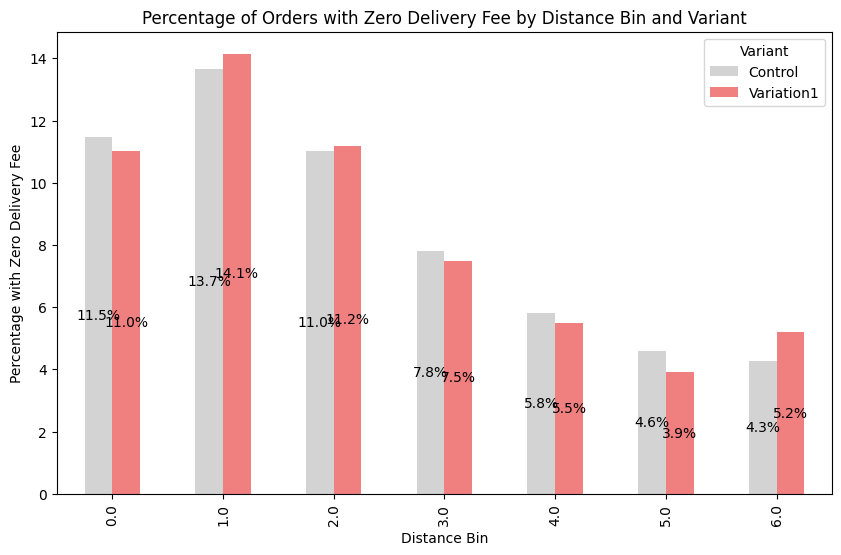

In [ ]:
# Load data
data = finland_details.copy()

data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting')]

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
data = data[data['delivery_distance'] <= percentile_99_value]

data['delivery_distance'] = data['delivery_distance'].round(0)

# Calculate the percentage of orders with a delivery fee of 0 for each distance bin and variant
result = data.groupby(['variant', 'delivery_distance'])['delivery_fee_eur'].apply(lambda x: (x == 0).mean() * 100).reset_index()

# Rename columns for clarity
result.columns = ['variant', 'distance_bin', 'percentage_with_zero_fee']

# Pivot the data for plotting
pivot_df = result.pivot(index='distance_bin', columns='variant', values='percentage_with_zero_fee').fillna(0)

# Plotting
ax = pivot_df.plot(kind='bar', color=['lightgrey', 'lightcoral'], figsize=(10, 6))

# Add percentages on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Only add text if height is greater than 0
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center')

plt.xlabel('Distance Bin')
plt.ylabel('Percentage with Zero Delivery Fee')
plt.title('Percentage of Orders with Zero Delivery Fee by Distance Bin and Variant')
plt.legend(title='Variant')
plt.grid(False)  # Remove grid lines
plt.show()

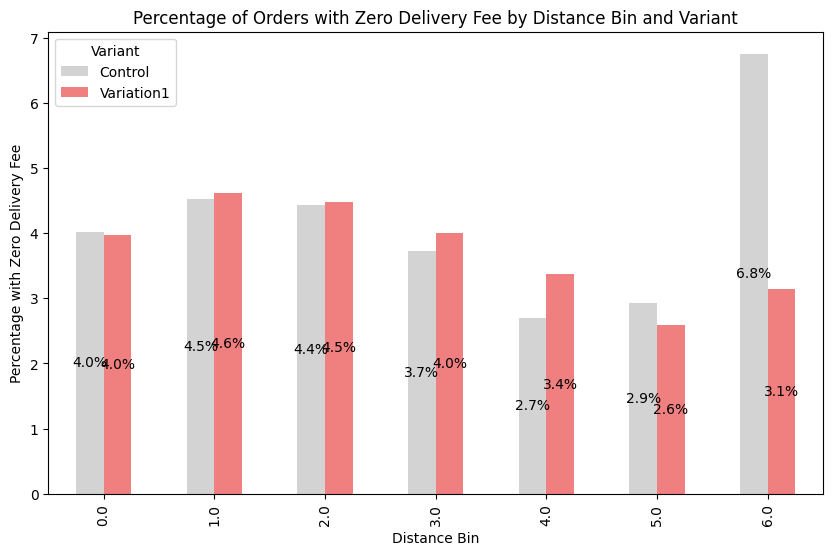

In [15]:
# Load data
data = austria_details.copy()

data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting')]

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
data = data[data['delivery_distance'] <= percentile_99_value]

data['delivery_distance'] = data['delivery_distance'].round(0)

# Calculate the percentage of orders with a delivery fee of 0 for each distance bin and variant
result = data.groupby(['variant', 'delivery_distance'])['delivery_fee_eur'].apply(lambda x: (x == 0).mean() * 100).reset_index()

# Rename columns for clarity
result.columns = ['variant', 'distance_bin', 'percentage_with_zero_fee']

# Pivot the data for plotting
pivot_df = result.pivot(index='distance_bin', columns='variant', values='percentage_with_zero_fee').fillna(0)

# Plotting
ax = pivot_df.plot(kind='bar', color=['lightgrey', 'lightcoral'], figsize=(10, 6))

# Add percentages on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Only add text if height is greater than 0
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center')

plt.xlabel('Distance Bin')
plt.ylabel('Percentage with Zero Delivery Fee')
plt.title('Percentage of Orders with Zero Delivery Fee by Distance Bin and Variant')
plt.legend(title='Variant')
plt.grid(False)  # Remove grid lines
plt.show()

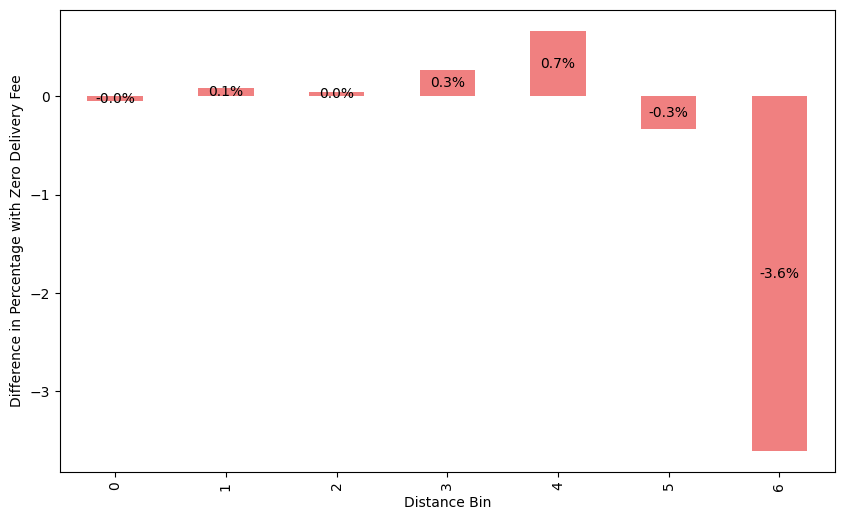

In [16]:
# Load data
data = austria_details.copy()

data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting')]

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
data = data[data['delivery_distance'] <= percentile_99_value]

data['delivery_distance'] = data['delivery_distance'].round(0)

# Calculate the percentage of orders with a delivery fee of 0 for each distance bin and variant
result = data.groupby(['variant', 'delivery_distance'])['delivery_fee_eur'].apply(lambda x: (x == 0).mean() * 100).reset_index()

# Rename columns for clarity
result.columns = ['variant', 'distance_bin', 'percentage_with_zero_fee']

# Pivot the data for calculating the differences
pivot_df = result.pivot(index='distance_bin', columns='variant', values='percentage_with_zero_fee').fillna(0).reset_index()

# Calculate the differences between control and variation
pivot_df['difference'] = pivot_df['Variation1'] - pivot_df['Control']

# Plotting
ax = pivot_df['difference'].plot(kind='bar', color='lightcoral', figsize=(10, 6))

# Add percentages on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center')

plt.xlabel('Distance Bin')
plt.ylabel('Difference in Percentage with Zero Delivery Fee')
plt.grid(False)  # Remove grid lines
plt.show()

In [17]:
pivot_df

variant,distance_bin,Control,Variation1,difference
0,0.0,4.023698,3.977125,-0.046573
1,1.0,4.530917,4.616171,0.085254
2,2.0,4.431265,4.480771,0.049506
3,3.0,3.727788,3.999450,0.271662
4,4.0,2.701525,3.369591,0.668066
5,5.0,2.930033,2.595067,-0.334966
6,6.0,6.755374,3.147954,-3.607420


In [18]:
finland_details.groupby(['variant'])['delivery_fee_eur'].mean().reset_index()

NameError: name 'finland_details' is not defined

In [19]:
# Load data
data = finland_details.copy()

data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting')]

data['delivery_distance'] = data['delivery_distance'].round(0)

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
filtered_df = data[data['delivery_distance'] <= percentile_99_value]

# Define the condition functions
def control_df(df):
    return df[df['variant'] == 'Control']['delivery_fee_eur'].mean()

def variation_df(df):
    return df[df['variant'] == 'Variation1']['delivery_fee_eur'].mean()

# Group by 'delivery_distance' and apply custom aggregation functions
result = filtered_df.groupby('delivery_distance').agg(
    control=('delivery_fee_eur', lambda x: control_df(data.loc[x.index])),
    variation=('delivery_fee_eur', lambda x: variation_df(data.loc[x.index]))
).reset_index()


result['difference'] = result['control'] - result['variation']

# # Determine the distances where the change in delivery fee is the highest
# max_diff_distance = result.loc[result['difference'].idxmax(), 'delivery_distance']

plt.figure(figsize=(6, 4))
plt.plot(result['delivery_distance'], result['control'], label='Control', color='grey')
plt.plot(result['delivery_distance'], result['variation'], label='Variation', color='red')
#plt.plot(result['delivery_distance'], result['difference'], label='Variation', color='red')

plt.xlabel('Delivery Distance (km)')
plt.ylabel('Delivery Fee (EUR)')
plt.legend()
plt.grid(True)
plt.xticks(result['delivery_distance'])  # Setting x-ticks to increments of 1
plt.tight_layout()
plt.grid(False)

plt.show()

NameError: name 'finland_details' is not defined

In [806]:
# Count the number of rows where delivery_fee is less than 1
finland_details[(finland_details['delivery_fee_eur'] == 0) & (finland_details['saver_discount_eur'].isna()) & (finland_details['priority_fee_eur'] == 0) & (finland_details['discount_other_eur'] == 0) & (finland_details['discount_dh_eur'] == 0) & (finland_details['voucher_dh_eur'] == 0) & (finland_details['voucher_other_eur'] == 0) & (finland_details['subscription_discount_type'] != "free_delivery")]['subscription_discount_type']


5987      None
5988      None
5989      None
6004      None
6005      None
          ... 
119779    None
119948    None
119979    None
119987    None
120008    None
Name: subscription_discount_type, Length: 5243, dtype: object

In [20]:
# Load data
data = finland_details.copy()

# Data Cleaning
data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting') & (data['delivery_fee_eur'] != 0)]

data

NameError: name 'finland_details' is not defined

In [21]:
# Load data
data = finland_details.copy()

# Data Cleaning
data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting') &  (data['delivery_fee_eur'] != 0)]


data['delivery_distance'] = data['delivery_distance'].round(0)

# # Calculate the 99th percentile value
# percentile_99_value = data['delivery_distance'].quantile(0.99)

# # Filter the DataFrame to keep only the 99th percentile data
# data = data[data['delivery_distance'] <= percentile_99_value]

data = data[data['variant'] == 'Control']

data[['delivery_fee_eur', 'delivery_distance']] = data[['delivery_fee_eur', 'delivery_distance']].astype(float)

# # Creating pivot table
# table = pd.pivot_table(data, values=['delivery_fee_eur', 'platform_order_code', 'actual_delivery_time'],
#                        index='delivery_distance', columns=['variant'], 
#                        aggfunc={"delivery_fee_eur": "mean", "platform_order_code": "nunique", "actual_delivery_time": "mean"}).reset_index()

# # Flattening the columns
# table.columns = ['_'.join(col).strip() if col[1] else col[0] for col in table.columns.values]


table = data.groupby('delivery_distance').agg({'delivery_fee_eur':'mean'}).reset_index()

# Calculate final prices after applying percentage discount
table['saver_fee_flat_discount'] = table['delivery_fee_eur'] * (1 - 0.15)

discount_rate = 0.15

# Define the threshold distance and calculate the flat discount amount based on the threshold distance
threshold_distance = 5
flat_discount_amount = round(table.loc[table['delivery_distance'] == threshold_distance, 'delivery_fee_eur'].values[0] * discount_rate, 2)

print(f"The flat discount amount is: {flat_discount_amount} cents")

# Calculate the discounted amount with a cap based on distance
def apply_mixed_discount(row, threshold_distance, flat_discount_amount, discount_rate=0.15):
    if row['delivery_distance'] >= threshold_distance:
        return row['delivery_fee_eur'] - flat_discount_amount
    else:
        return row['delivery_fee_eur'] * ( 1- discount_rate )

table['absolute_saver'] = table.apply(apply_mixed_discount, axis=1, args=(threshold_distance, flat_discount_amount, discount_rate))

plt.figure(figsize=(8, 5))

plt.plot(table['delivery_fee_eur'], table['delivery_fee_eur'], label='Standard Fee', color='grey')
plt.plot(table['delivery_fee_eur'], table['saver_fee_flat_discount'], label='saver_fee_flat_discount (15 %)', color='#FAA0A0')  
plt.plot(table['delivery_fee_eur'], table['absolute_saver'], label='Capped Saver at 0.81 cents for distances >= 5 km', color='red', linestyle = '--') 
plt.axvline(threshold_distance, color='black', linewidth=1, linestyle='--', label=f'Threshold Distance ({threshold_distance} km)')


plt.legend()
plt.xlabel('Delivery Fee (EUR)')
plt.ylabel('Delivery Fee (EUR)')
plt.show()



NameError: name 'finland_details' is not defined

In [22]:
table

NameError: name 'table' is not defined

In [23]:
# Load data
data = finland_details.copy()

# Data Cleaning
data = data[data['category'] == 'standard']
data.dropna(inplace=True)

data['delivery_distance'] = data['delivery_distance'].round(1)

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
data = data[data['delivery_distance'] <= percentile_99_value]

# Creating pivot table
table = pd.pivot_table(data, values=['delivery_fee_eur', 'platform_order_code', 'actual_delivery_time'],
                       index='delivery_distance', columns=['variant'], 
                       aggfunc={"delivery_fee_eur": "mean", "platform_order_code": "nunique", "actual_delivery_time": "mean"}).reset_index()

# Flattening the columns
table.columns = ['_'.join(col).strip() if col[1] else col[0] for col in table.columns.values]

# Calculating the difference
table['difference'] = table['delivery_fee_eur_Control'] - table['delivery_fee_eur_Variation1']

# Calculate final prices after applying percentage discount
table['average_saver_price'] = table['delivery_fee_eur_Control'] * (1 - 0.15)

# Assuming 'table' is your DataFrame and 'delivery_fee_eur_Control' is the column of interest
discount_rate = 0.15

# Define the threshold distance and calculate the flat discount amount based on the threshold distance
threshold_distance = 5
flat_discount_amount = round(table.loc[table['delivery_distance'] == threshold_distance, 'delivery_fee_eur_Control'].values[0] * discount_rate,2)

print(f"The cap distance for the discount should be: {cap_distance} units")
print(f"The flat discount amount is: {flat_discount_amount} cents")

# Calculate the discounted amount with a cap based on distance
def apply_mixed_discount(row, threshold_distance, flat_discount_amount, discount_rate=0.15):
    if row['delivery_distance'] > threshold_distance:
        return row['delivery_fee_eur_Control'] - flat_discount_amount
    else:
        return np.nan

table['absolute_saver'] = table.apply(apply_mixed_discount, axis=1, args=(threshold_distance, flat_discount_amount, discount_rate))

# Calculating the discount difference for the plot
table['discount_difference'] = table['delivery_fee_eur_Control'] - table['average_saver_price']

table['absolute_saver'] = table['absolute_saver'].fillna(table['average_saver_price'])

# Extracting columns from the DataFrame
distances = table['delivery_distance']
saver_fee = table['average_saver_price']
standard_fee = table['delivery_fee_eur_Control']
discount_difference = table['discount_difference']
ab_saver = table['absolute_saver']

plt.plot(standard_fee, standard_fee, label='Standard Fee', color='grey')
plt.plot(standard_fee[distances > threshold_distance], ab_saver[distances > threshold_distance], label='Mixed Discount Strategy', linestyle='--')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(threshold_distance, color='black', linewidth=1, linestyle='--', label=f'Threshold Distance ({threshold_distance} miles)')

plt.xlabel('Standard Price Control (Euros)')
plt.ylabel('Standard Price Control (Euros)')
plt.legend()
plt.grid(True)

plt.show()

NameError: name 'finland_details' is not defined

In [24]:
table

NameError: name 'table' is not defined

In [25]:
# Load data
data = finland_details.copy()

data = data[data['category'] == 'standard']

a = data.groupby(['variant','target_group']).agg({'platform_order_code': 'nunique'}).reset_index()
a['total'] = a['platform_order_code'].sum()
a['percentgaa['platform_order_code'] / a['total']

SyntaxError: unterminated string literal (detected at line 8) (900157079.py, line 8)

In [26]:
14955 / (14955 + 44345)

0.25219224283305225

In [27]:
# Load data
data = finland_details.copy()

data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting') &  (data['delivery_fee_eur'] != 0)]

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
data = data[data['delivery_distance'] <= percentile_99_value]


# Create 4 quantile-based buckets without labels first
data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=4)

# Get the quantile ranges
quantile_ranges = data['distance_bucket'].unique()

# Create a mapping for the new labels based on the quantile ranges
labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# Create a dictionary to map the original intervals to the new labels
label_mapping = dict(zip(quantile_ranges, labels))

# Apply the new labels to the distance_bucket column
data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

# # Define distance buckets
# bins = [0,1,2,5, 9,20]
# labels = ['0-1 km', '1-2 km','2-5','5-9 km', '9-20 km']
# data['distance_bucket'] = pd.cut(data['delivery_distance'], bins=bins, labels=labels)

data['delivery_fee_eur'] = data['delivery_fee_eur'].astype(float)

delivery_fee = data.groupby(['variant', 'distance_bucket']).agg({
    'delivery_fee_eur': ['mean','sem']
}).reset_index()

# Rename the columns
delivery_fee.columns = ['variant', 'distance_bucket', 'mean','sem']

# Initialize lists to hold the results
distances = []
mean_diffs = []
combined_sems = []

# Calculate differences and errors for each distance group
for distance in delivery_fee['distance_bucket'].unique():
    control = delivery_fee[(delivery_fee['distance_bucket'] == distance) & (delivery_fee['variant'] == 'Control')]
    variation = delivery_fee[(delivery_fee['distance_bucket'] == distance) & (delivery_fee['variant'] == 'Variation1')]
    
    if not control.empty and not variation.empty:
        control_mean = control['mean'].values[0]
        variation_mean = variation['mean'].values[0]
        control_sem = control['sem'].values[0]
        variation_sem = variation['sem'].values[0]
        
        mean_diff = variation_mean - control_mean
        combined_sem = np.sqrt(control_sem**2 + variation_sem**2)
        
        distances.append(distance)
        mean_diffs.append(mean_diff)
        combined_sems.append(combined_sem)

# Create the dataframe for plotting
plot_data = {
    'distance': distances,
    'change': mean_diffs,
    'error': combined_sems
}
plot_df = pd.DataFrame(plot_data)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the error bars
ax.errorbar(plot_df['change'], plot_df['distance'], xerr=plot_df['error'], fmt='o', color='black', ecolor='black', elinewidth=2, capsize=4)

# Add vertical line at x=0
ax.axvline(x=0, color='gray', linestyle='--')

# Set labels
ax.set_xlabel('Change in Average Delivery fee')
ax.set_ylabel('Distance Buckets')
ax.set_title('Difference in Average Delivery fee Between Control and Variation Groups by Distance')

# Show plot
plt.tight_layout()
plt.show()


from scipy import stats

for label in labels:
    control_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Control')]['delivery_fee_eur']
    variation_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Variation1')]['delivery_fee_eur']
    t_stat, p_val = stats.ttest_ind(variation_fees, control_fees)
    print(f"Distance Bucket {label}: t_stat={t_stat}, p_val={p_val}")

NameError: name 'finland_details' is not defined

In [28]:
data

,country,city_name,entity_id,variant,category,target_group,perseus_client_id,vendor_id,chain_id,platform_order_code,...,saver_discount_eur,discount_dh_eur,discount_other_eur,voucher_dh_eur,voucher_other_eur,mov_customer_fee_eur,subscription_discount_type,commission_eur,delivery_distance,actual_delivery_time
0,Austria,Wien,MJM_AT,Control,standard,Chains in targeting,1690210831317.4048623651.tjfdydbxrq,a0uk,ch6oj,a0uk-2431-1yzc,...,None,0E-9,0E-9,0E-9,0E-9,0E-9,free_delivery,5.980000000,2.0,14.63
1,Austria,Wien,MJM_AT,Variation1,standard,Chains in targeting,1624999949687.7629173417.uzruzpzoim,wfal,cs3hp,wfal-2431-1qjl,...,None,1.020000000,1.020000000,0E-9,0E-9,0E-9,free_delivery,5.790000000,2.0,24.28
12,Austria,Wien,MJM_AT,Control,standard,Chains in targeting,1622583597308.8143555285.rfiutpvvux,o3kj,None,o3kj-2431-azlr,...,None,0E-9,0E-9,0E-9,0E-9,0E-9,free_delivery,4.920000000,1.0,22.57
13,Austria,Wien,MJM_AT,Control,standard,Chains in targeting,1711985957099.7599808622.yzatugyehz,q2wt,ck1uq,q2wt-2431-wlcz,...,None,2.400000000,2.400000000,0E-9,0E-9,0.290000000,free_delivery,3.400000000,1.0,17.85
14,Austria,Wien,MJM_AT,Variation1,standard,Chains in targeting,1705662978794.226463410470620765.lSEKItZEgQ,jud4,None,jud4-2431-pqkp,...,None,0E-9,0E-9,0E-9,0E-9,0E-9,free_delivery,12.090000000,2.0,34.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231536,Austria,Wien,MJM_AT,Control,standard,Chains in targeting,1710060771478.673971090906153251.x3ore6jSVN,hixg,None,hixg-2431-7qf9,...,None,0E-9,0E-9,0E-9,0E-9,0E-9,None,6.720000000,2.0,22.62
231537,Austria,Wien,MJM_AT,Variation1,standard,Chains in targeting,1713185536638.9594806910.xgwzqvxvmd,kw8x,cg8dy,kw8x-2431-ow64,...,None,0E-9,0E-9,0E-9,0E-9,0E-9,None,5.850000000,5.0,23.57
231539,Austria,Klagenfurt,MJM_AT,Control,standard,Chains in targeting,1722103472772.666461453203694562.k4r5fyzp7w,rvw0,cl3xc,rvw0-2431-o4gs,...,None,0E-9,0E-9,0E-9,0E-9,0E-9,None,10.190000000,3.0,48.02
231540,Austria,Klagenfurt,MJM_AT,Variation1,standard,Chains in targeting,1638693905402.778120308775147270.UjCeOh8taB,gzfg,None,gzfg-2431-i14p,...,None,0E-9,0E-9,0E-9,0E-9,0E-9,None,5.370000000,3.0,85.48


count    168933.000000
mean          2.113733
std           1.407320
min           0.001000
25%           1.009000
50%           1.834000
75%           2.961000
max          11.882000
Name: delivery_distance, dtype: float64


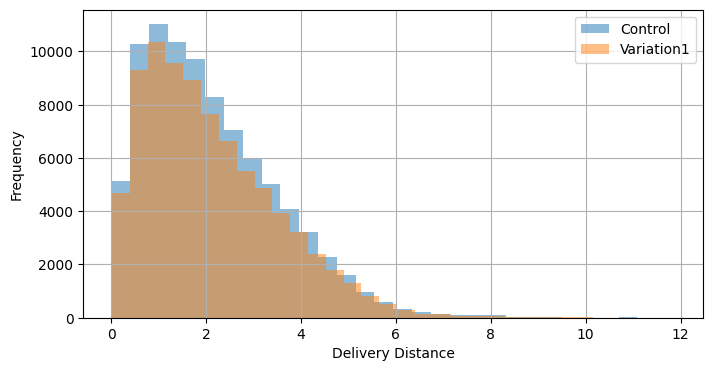

NameError: name 'mannwhitneyu' is not defined

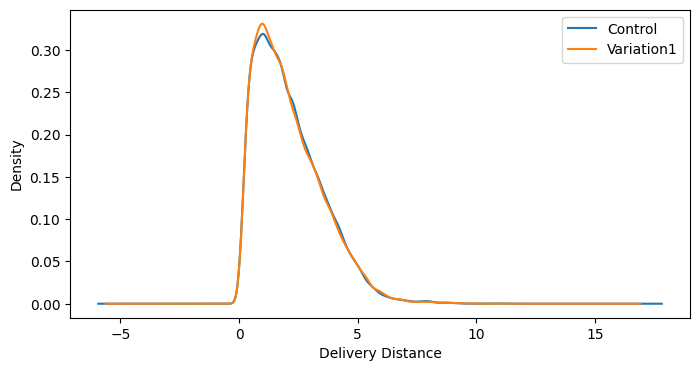

In [47]:
# Filter data for 'standard' category
data = austria_details.copy()

# Filter data for 'standard' category and 'Chains not in targeting'
data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting') &  (data['delivery_fee_eur'] != 0)]

# Data Cleaning: Removing negative values
data = data[data['delivery_distance'] >= 0]

# Displaying descriptive statistics
print(data['delivery_distance'].describe())

# Plotting histograms for each variant
variants = data['variant'].unique()
fig, ax = plt.subplots(figsize=(8, 4))

for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance'].hist(ax=ax, alpha=0.5, label=variant, bins=30)

ax.set_xlabel('Delivery Distance')
ax.set_ylabel('Frequency')
ax.legend()

plt.show()

# Creating two line distributions
fig, ax = plt.subplots(figsize=(8, 4))

for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance'].plot(kind='density', ax=ax, label=variant)

ax.set_xlabel('Delivery Distance')
ax.set_ylabel('Density')
ax.legend()

# Separating the data for each variant
variant_a = data[data['variant'] == 'Control']['delivery_distance']
variant_b = data[data['variant'] == 'Variation1']['delivery_distance']

# Performing the Mann-Whitney U test
stat, p_value = mannwhitneyu(variant_a, variant_b)

# Displaying the p-value on the chart
plt.text(0.95, 0.95, f'Mann-Whitney p-value:: {p_value:.6f}', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

plt.show()

# Displaying the results
stat, p_value

# Calculate medians
median_control = variant_a.median()
median_variation1 = variant_b.median()

print(median_control, median_variation1)

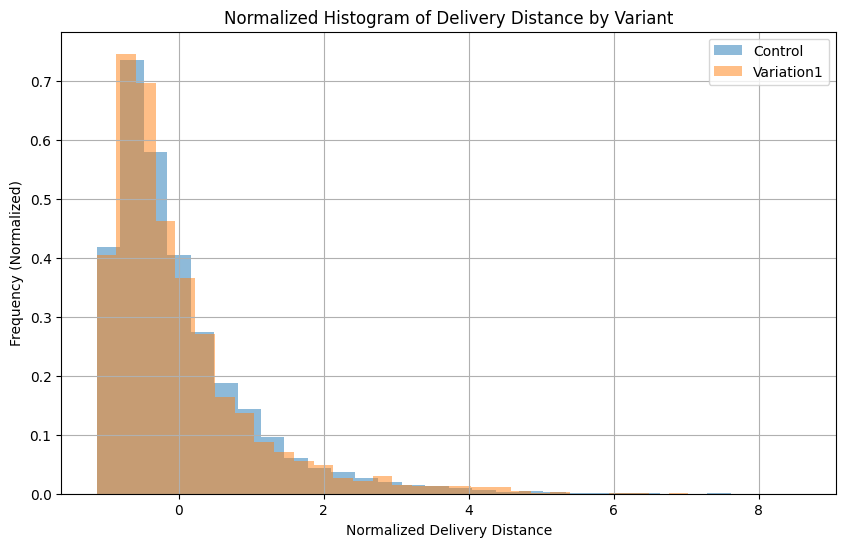

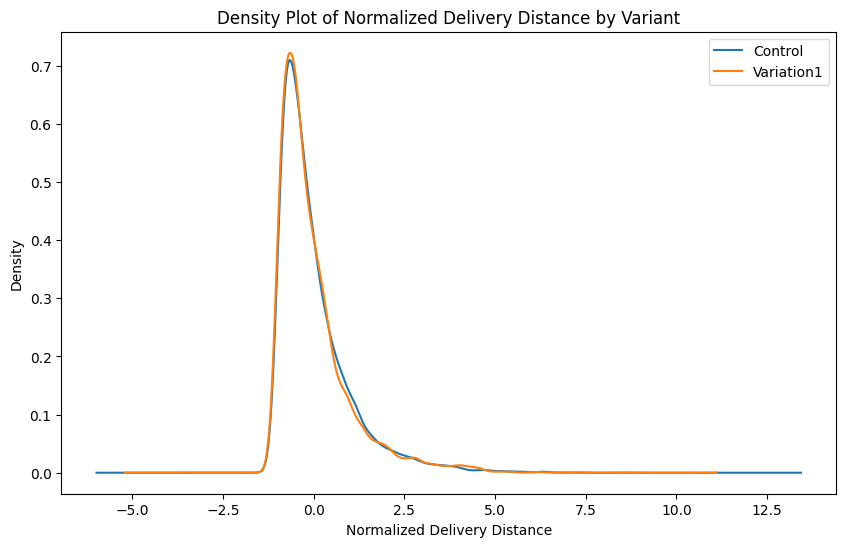

(np.float64(76793189.0), np.float64(0.0005898408012875277))

In [ ]:
# Filter data for 'standard' category
data = finland_details.copy()
data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains not in targeting') & (data['delivery_fee_eur'] != 0)]

# Data Cleaning
data['delivery_distance'] = data['delivery_distance'].round(3)

# Normalizing the 'delivery_distance' column
data['delivery_distance_normalized'] = (data['delivery_distance'] - data['delivery_distance'].mean()) / data['delivery_distance'].std()

# Plotting normalized histograms for each variant
variants = data['variant'].unique()
fig, ax = plt.subplots(figsize=(10, 6))

for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance_normalized'].hist(ax=ax, alpha=0.5, label=variant, bins=30, density=True)

ax.set_xlabel('Normalized Delivery Distance')
ax.set_ylabel('Frequency (Normalized)')
ax.set_title('Normalized Histogram of Delivery Distance by Variant')
ax.legend()

plt.show()

# Creating normalized density plots for each variant
fig, ax = plt.subplots(figsize=(10, 6))

for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance_normalized'].plot(kind='density', ax=ax, label=variant)

ax.set_xlabel('Normalized Delivery Distance')
ax.set_ylabel('Density')
ax.set_title('Density Plot of Normalized Delivery Distance by Variant')
ax.legend()

plt.show()

# Separating the data for each variant
variant_a = data[data['variant'] == 'Control']['delivery_distance_normalized']
variant_b = data[data['variant'] == 'Variation1']['delivery_distance_normalized']

# Performing the Mann-Whitney U test
stat, p_value = mannwhitneyu(variant_a, variant_b)

# Displaying the results
stat, p_value

count    77213.000000
mean         2.317092
std          2.169214
min          0.000000
25%          0.854000
50%          1.619000
75%          2.947000
max         18.262000
Name: delivery_distance, dtype: float64


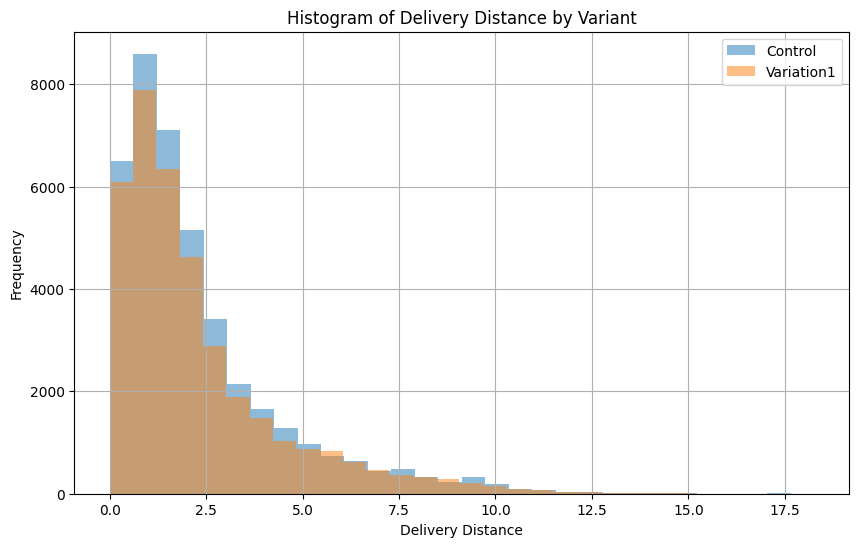

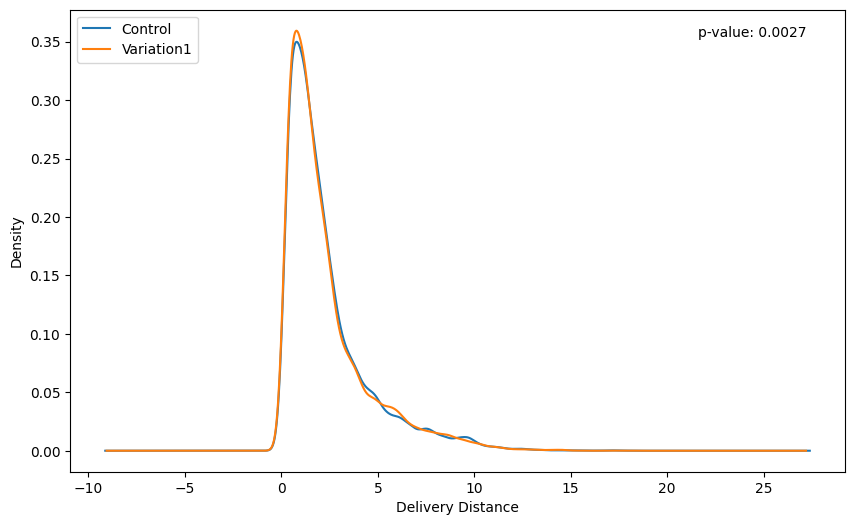

(np.float64(752684067.0), np.float64(0.002697055965533184))

In [ ]:
# Filter data for 'standard' category
data = finland_details.copy()

# Filter data for 'standard' category and 'Chains not in targeting'
data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting') & (data['delivery_fee_eur'] != 0)]

# Data Cleaning: Removing negative values
data = data[data['delivery_distance'] >= 0]

# Displaying descriptive statistics
print(data['delivery_distance'].describe())

# Plotting histograms for each variant
variants = data['variant'].unique()
fig, ax = plt.subplots(figsize=(10, 6))

for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance'].hist(ax=ax, alpha=0.5, label=variant, bins=30)

ax.set_xlabel('Delivery Distance')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Delivery Distance by Variant')
ax.legend()

plt.show()

# Creating two line distributions
fig, ax = plt.subplots(figsize=(10, 6))

for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance'].plot(kind='density', ax=ax, label=variant)

ax.set_xlabel('Delivery Distance')
ax.set_ylabel('Density')
ax.legend()

# Separating the data for each variant
variant_a = data[data['variant'] == 'Control']['delivery_distance']
variant_b = data[data['variant'] == 'Variation1']['delivery_distance']

# Performing the Mann-Whitney U test
stat, p_value = mannwhitneyu(variant_a, variant_b)

# Displaying the p-value on the chart
plt.text(0.95, 0.95, f'p-value: {p_value:.4f}', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

plt.show()

# Displaying the results
stat, p_value

In [ ]:
variant_data

,country,city_name,entity_id,variant,category,target_group,perseus_client_id,vendor_id,chain_id,platform_order_code,revenue_eur,avg_delivery_cost,avg_profit,delivery_fee_eur,commission_eur,delivery_distance,actual_delivery_time
65293,Finland,Oulu,PO_FI,Variation1,standard,Chains not in targeting,1673183391690.749391713092468949.cVuzTm1Zs9,s9fh,cm7qt,s9fh-2420-wyws,5.728421,5.043381,0.685040,0E-9,4.860000000,1.60,22.90
65294,Finland,Oulu,PO_FI,Variation1,standard,Chains not in targeting,1708938269562.812365795819629700.s9vyoksfbk,s9fh,cm7qt,s9fh-2420-ak1a,3.408421,6.498424,-3.090003,0E-9,2.540000000,2.48,30.50
65295,Finland,Oulu,PO_FI,Variation1,standard,Chains not in targeting,1668353719684.3124876605.hbpflqydpm,s9fh,cm7qt,s9fh-2420-v5y4,3.728421,5.254611,-1.526190,0E-9,2.860000000,1.66,37.82
65300,Finland,Helsinki,PO_FI,Variation1,standard,Chains not in targeting,1716133362811.0427630673.usxgsdpboo,s7kr,cw4ue,s7kr-4389,2.978421,0.007208,2.971213,0E-9,2.110000000,1.26,34.70
65301,Finland,Helsinki,PO_FI,Variation1,standard,Chains not in targeting,1588087915390.6967792922.tqhjjlttvd,kuph,cw4ue,kuph-28e7,2.758421,5.624460,-2.866039,0E-9,1.890000000,1.58,30.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120042,Finland,Helsinki,PO_FI,Variation1,standard,Chains not in targeting,1591987983936.8221847522.fzqsnbdifn,move,cl3xo,move-2428-s1dc,6.792632,6.320000,0.472632,2.990000000,2.740000000,2.70,17.87
120043,Finland,Helsinki,PO_FI,Variation1,standard,Chains not in targeting,1716557126466.516736678484397538.XLJXFxm9Rk,s3ld,cw4ue,s3ld-t9gw,7.543860,0.000000,7.543860,2.990000000,4.000000000,1.70,19.37
120044,Finland,Helsinki,PO_FI,Variation1,standard,Chains not in targeting,1629810899802.655135070936438749.w1oZ0x1XnD,o8gt,cs8kk,o8gt-2428-ql4r,6.653860,6.080000,0.573860,2.990000000,3.110000000,2.54,35.07
120064,Finland,Tampere,PO_FI,Variation1,standard,Chains not in targeting,1667736410038.1055399172.bgifuyewpc,n2ra,cw4ue,n2ra-iplg,7.573860,4.550000,3.023860,2.990000000,4.030000000,1.53,28.73


In [ ]:
# Load data
data = finland_details.copy()

# Data Cleaning
data = data[data['category'] == 'standard']
data.dropna(inplace=True)

data['delivery_distance'] = data['delivery_distance'].round(2)

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
data = data[data['delivery_distance'] <= percentile_99_value]

# Creating pivot table
table = pd.pivot_table(data, values=['delivery_fee_eur', 'platform_order_code', 'actual_delivery_time'],
                       index='delivery_distance', columns=['variant'], 
                       aggfunc={"delivery_fee_eur": "mean", "platform_order_code": "nunique", "actual_delivery_time": "mean"}).reset_index()

# Flattening the columns
table.columns = ['_'.join(col).strip() if col[1] else col[0] for col in table.columns.values]

# Calculating the difference
table['difference'] = table['delivery_fee_eur_Control'] - table['delivery_fee_eur_Variation1']

# Calculate final prices after applying percentage discount
table['average_saver_price'] = table['delivery_fee_eur_Control'] * (1 - 0.15)

# Assuming 'table' is your DataFrame and 'delivery_fee_eur_Control' is the column of interest
discount_rate = 0.15

# Define the threshold distance and calculate the flat discount amount based on the threshold distance
threshold_distance = 5
flat_discount_amount = round(table.loc[table['delivery_distance'] == threshold_distance, 'delivery_fee_eur_Control'].values[0] * discount_rate,2)

print(f"The cap distance for the discount should be: {cap_distance} units")
print(f"The flat discount amount is: {flat_discount_amount} cents")

# Calculate the discounted amount with a cap based on distance
def apply_mixed_discount(row, threshold_distance, flat_discount_amount, discount_rate=0.15):
    if row['delivery_distance'] > threshold_distance:
        return row['delivery_fee_eur_Control'] - flat_discount_amount
    else:
        return np.nan

table['absolute_saver'] = table.apply(apply_mixed_discount, axis=1, args=(threshold_distance, flat_discount_amount, discount_rate))

# Calculating the discount difference for the plot
table['discount_difference'] = table['delivery_fee_eur_Control'] - table['average_saver_price']

# Extracting columns from the DataFrame
distances = table['delivery_distance']
saver_fee = table['average_saver_price']
standard_fee = table['delivery_fee_eur_Control']
discount_difference = table['discount_difference']
ab_saver = table['absolute_saver']

# Creating the plot
plt.plot(standard_fee, standard_fee, label='Standard Fee', color='grey')
plt.plot(standard_fee, saver_fee, label='Saver Fee (flat 15% discount across distances)', color='red')
#plt.plot(standard_fee[distances > threshold_distance], ab_saver[distances > threshold_distance], label='Mixed Discount Strategy', color='purple')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
#plt.axvline(threshold_distance, color='black', linewidth=1, linestyle='--', label=f'Threshold Distance ({threshold_distance} miles)')

# Adding labels and title
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

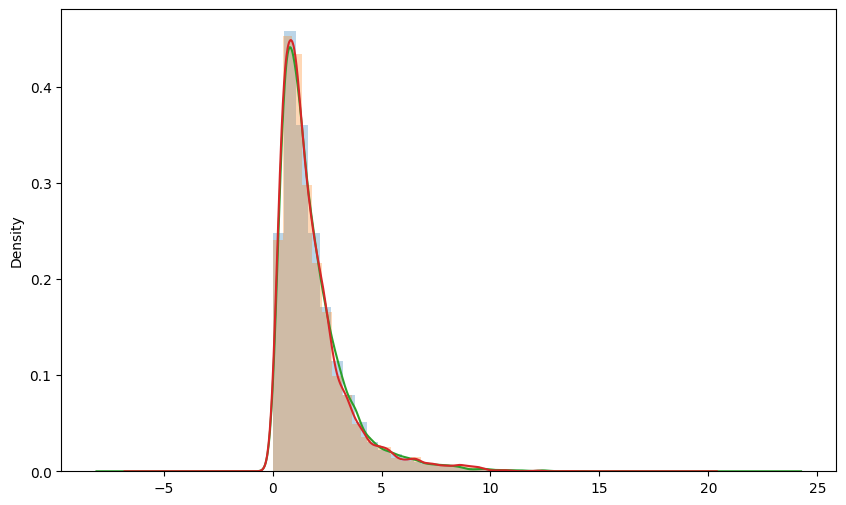

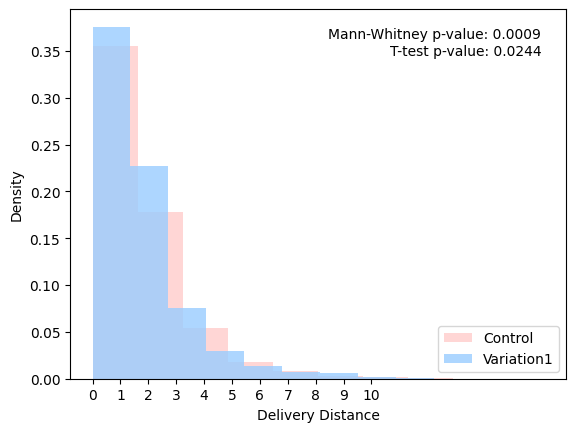

Mean delivery distance for Control: 1.83
Mean delivery distance for Variation1: 1.79
Difference in means: 0.04


In [ ]:
# Assume finland_details is already loaded as a DataFrame

# Filter data for 'standard' category
data = finland_details.copy()
data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains not in targeting')]

# Data Cleaning
data.dropna(inplace=True)
data['delivery_distance'] = data['delivery_distance'].round(2)

# Plotting histograms for each variant
variants = data['variant'].unique()
fig, ax = plt.subplots(figsize=(10, 6))

for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance'].hist(ax=ax, alpha=0.3, label=variant, bins=30, density=True)

# Adding density plots to the histogram chart
for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance'].plot(kind='density', ax=ax, label=f"{variant} density")

# Assuming data is a pandas DataFrame already loaded with the relevant data

# Separating the delivery distances for both variants
variant_a = data[data['variant'] == 'Control']['delivery_distance']
variant_b = data[data['variant'] == 'Variation1']['delivery_distance']

# Perform the Mann-Whitney U test
mannwhitney_stat, mannwhitney_p_value = mannwhitneyu(variant_a, variant_b)

# Perform the t-test for the means
ttest_stat, ttest_p_value = ttest_ind(variant_a, variant_b)

# Plotting the histograms with transparency
fig, ax = plt.subplots()
ax.hist(variant_a, color='#ffcccb', label='Control', density=True, alpha=0.8)
ax.hist(variant_b, color='#99ccff', label='Variation1', density=True,  alpha=0.8)

# Displaying the p-values on the chart
ax.text(0.95, 0.95, f'Mann-Whitney p-value: {mannwhitney_p_value:.4f}\nT-test p-value: {ttest_p_value:.4f}', 
        horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, color='black')

ax.set_xlabel('Delivery Distance', color='black')
ax.set_ylabel('Density', color='black')
ax.legend()
plt.xticks(result['delivery_distance'])  # Setting x-ticks to increments of 1


plt.show()

# Calculate and print the means
mean_control = variant_a.mean()
mean_variation1 = variant_b.mean()
print(f"Mean delivery distance for Control: {mean_control:.2f}")
print(f"Mean delivery distance for Variation1: {mean_variation1:.2f}")
print(f"Difference in means: {mean_control - mean_variation1:.2f}")

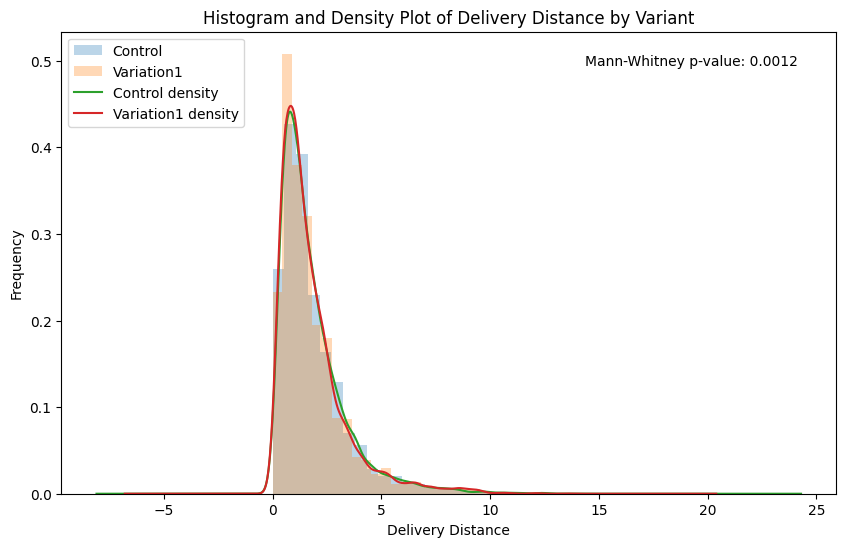

Median delivery distance for Control: 1.40
Median delivery distance for Variation1: 1.30
Difference in medians: 0.10


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Assume finland_details is already loaded as a DataFrame

# Filter data for 'standard' category
data = finland_details.copy()
data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains not in targeting')]

# Data Cleaning
data.dropna(inplace=True)
data['delivery_distance'] = data['delivery_distance'].round(1)

# Plotting histograms for each variant
variants = data['variant'].unique()
fig, ax = plt.subplots(figsize=(10, 6))

for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance'].hist(ax=ax, alpha=0.3, label=variant, bins=30, density=True)

# Adding density plots to the histogram chart
for variant in variants:
    variant_data = data[data['variant'] == variant]
    variant_data['delivery_distance'].plot(kind='density', ax=ax, label=f"{variant} density")

# Perform the Mann-Whitney U test
variant_a = data[data['variant'] == 'Control']['delivery_distance']
variant_b = data[data['variant'] == 'Variation1']['delivery_distance']
mannwhitney_stat, mannwhitney_p_value = mannwhitneyu(variant_a, variant_b)

# Displaying the p-value on the chart
ax.text(0.95, 0.95, f'Mann-Whitney p-value: {mannwhitney_p_value:.4f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

ax.set_xlabel('Delivery Distance')
ax.set_ylabel('Frequency')
ax.set_title('Histogram and Density Plot of Delivery Distance by Variant')
ax.legend()

plt.show()

# Calculate and print the medians
median_control = variant_a.median()
median_variation1 = variant_b.median()
print(f"Median delivery distance for Control: {median_control:.2f}")
print(f"Median delivery distance for Variation1: {median_variation1:.2f}")
print(f"Difference in medians: {median_control - median_variation1:.2f}")

In [ ]:
finland_details.isna().sum()

country                            0
city_name                          0
entity_id                          0
variant                            0
category                           0
target_group                       0
perseus_client_id                 91
vendor_id                          0
chain_id                       38776
platform_order_code                0
revenue_eur                        0
avg_delivery_cost                  5
avg_profit                         0
delivery_fee_eur                   0
dps_delivery_fee_eur              93
priority_fee_eur                   0
saver_discount_eur            116869
discount_dh_eur                    0
discount_other_eur                 0
voucher_dh_eur                     0
voucher_other_eur                  0
mov_customer_fee_eur               0
subscription_discount_type    104164
commission_eur                     4
delivery_distance                 46
actual_delivery_time            2723
dtype: int64

In [48]:
# Load data
data = finland_details.copy()

data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting') &  (data['delivery_fee_eur'] != 0)]

data['delivery_distance'] = data['delivery_distance'].round(0)

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
filtered_df = data[data['delivery_distance'] <= percentile_99_value]

# Define the condition functions
def control_df(df):
    return df[df['variant'] == 'Control']['delivery_fee_eur'].mean()

def variation_df(df):
    return df[df['variant'] == 'Variation1']['delivery_fee_eur'].mean()

# Group by 'delivery_distance' and apply custom aggregation functions
result = filtered_df.groupby('delivery_distance').agg(
    control=('delivery_fee_eur', lambda x: control_df(data.loc[x.index])),
    variation=('delivery_fee_eur', lambda x: variation_df(data.loc[x.index]))
).reset_index()


result['difference'] = result['control'] - result['variation']

# # Determine the distances where the change in delivery fee is the highest
# max_diff_distance = result.loc[result['difference'].idxmax(), 'delivery_distance']

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(result['delivery_distance'], result['control'], label='Control', color='grey')
plt.plot(result['delivery_distance'], result['variation'], label='Variation', color='red')


# Enhancing the plot
plt.xlabel('Delivery Distance (km)')
plt.ylabel('Delivery Fee (EUR)')
plt.legend()
plt.grid(True)
plt.xticks(result['delivery_distance'])  # Setting x-ticks to increments of 1
plt.tight_layout()
plt.grid(False)

plt.show()


NameError: name 'finland_details' is not defined

In [49]:
filtered_df[filtered_df['variant'] == 'Variation1']['delivery_fee_eur'].sum()

KeyError: 'variant'

In [50]:
# Determine the distances where the change in delivery fee is the highest
max_diff_distance = result.loc[result['difference'].idxmax(), 'delivery_distance']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(result['delivery_distance'], result['control'], label='Control', color='grey')
plt.plot(result['delivery_distance'], result['variation'], label='Variation', color='red')
plt.axvline(x=max_diff_distance, color='blue', linestyle='dotted', label='Max Difference')

# Enhancing the plot
plt.title('Delivery Fee Comparison by Distance')
plt.xlabel('Delivery Distance (km)')
plt.ylabel('Delivery Fee (EUR)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

KeyError: 'difference'

In [ ]:
# Identify the distance bin with the biggest drop in average delivery fee
average_fees_diff = average_fees.diff().fillna(0)
biggest_drop_distance = average_fees_diff.idxmin()

# Extract the upper limit of the distance bin where the biggest drop occurs
cap_distance = 5

# Function to apply capped discount
def apply_capped_discount(row, cap_distance, discount_rate=0.15):
    if row['delivery_distance'] > cap_distance:
        return row['delivery_fee_eur'] * (1 - discount_rate)
    else:
        return row['delivery_fee_eur']

# Apply the capped discount to the DataFrame
result['discounted_fee'] = result.apply(apply_capped_discount, axis=1, args=(cap_distance,))

result

NameError: name 'average_fees' is not defined

Forssa


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



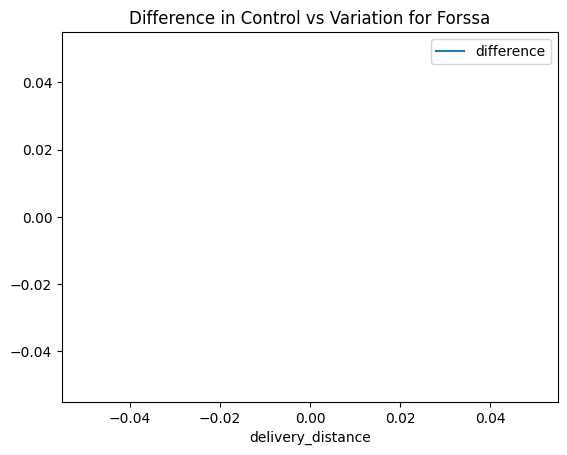

Hameenlinna


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



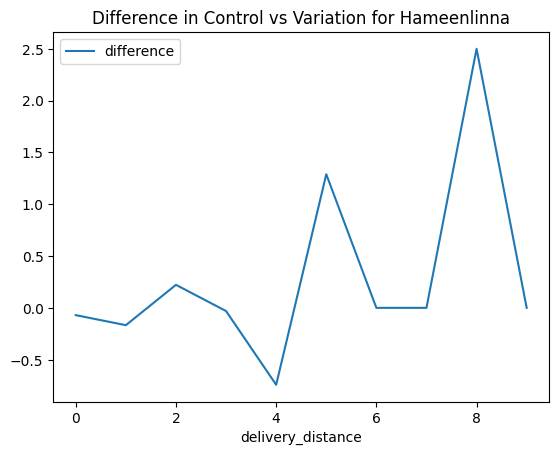

Helsinki


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



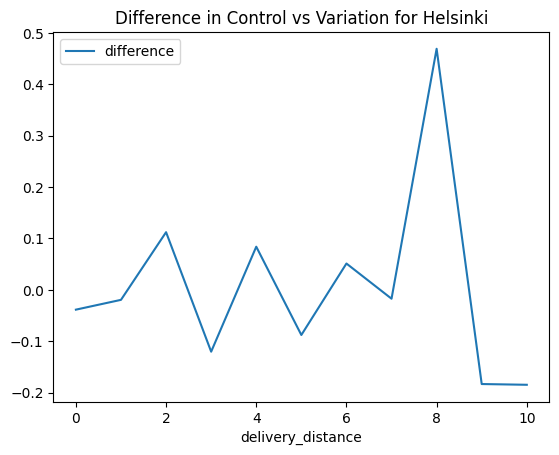

Hyvinkaa


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



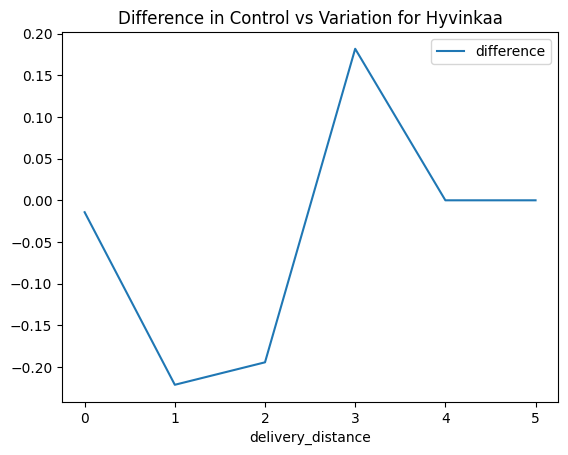

Imatra


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



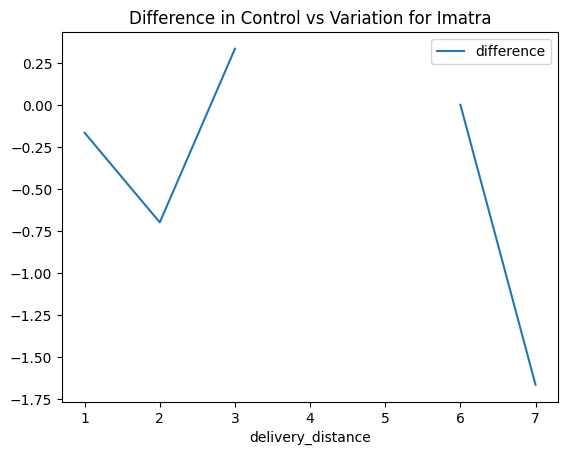

Joensuu


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



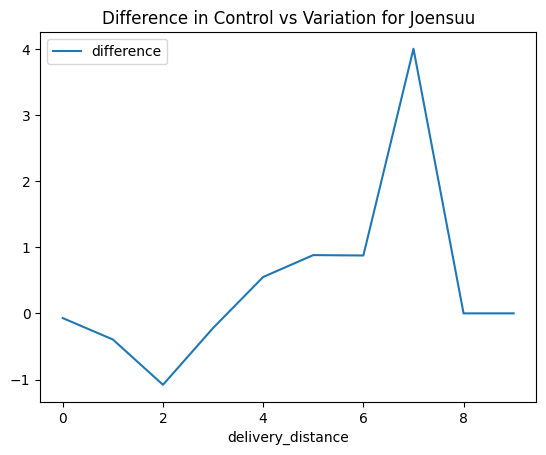

Jyvaskyla


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



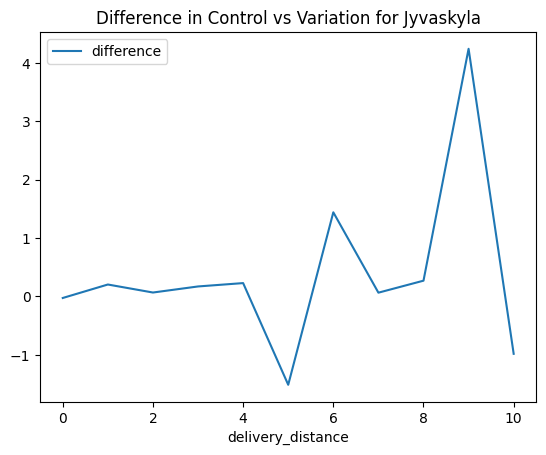

Kajaani


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



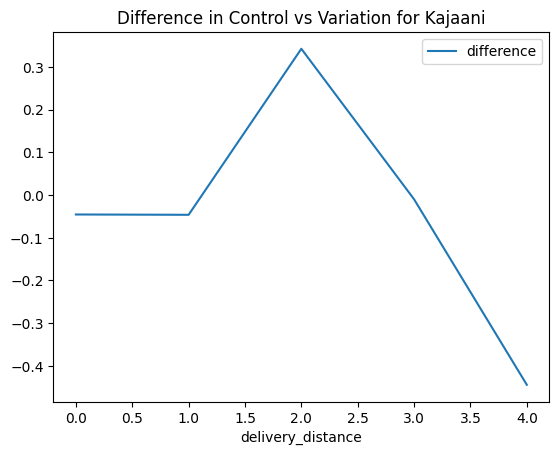

Kankaanpaa


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



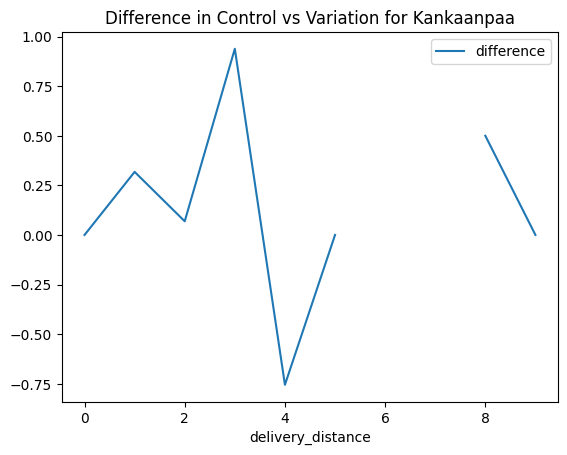

Kemi


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



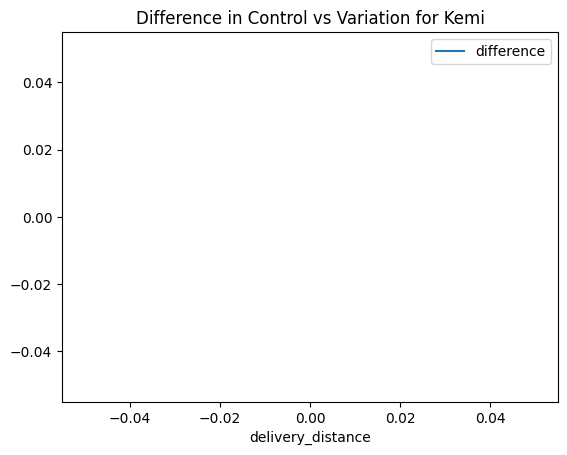

Kirkkonummi


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



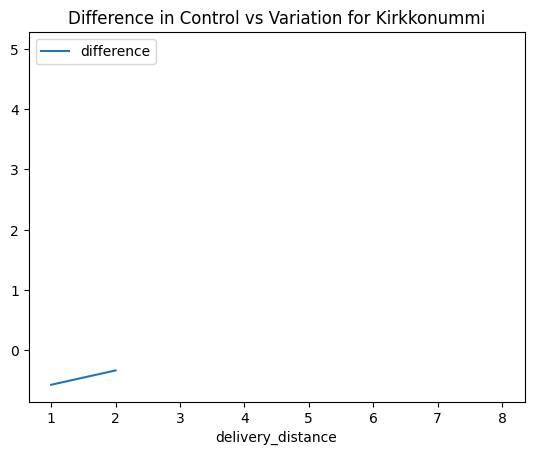

Kokkola


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



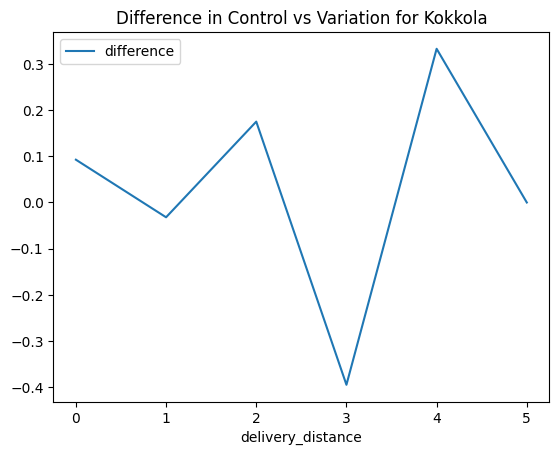

Kotka


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



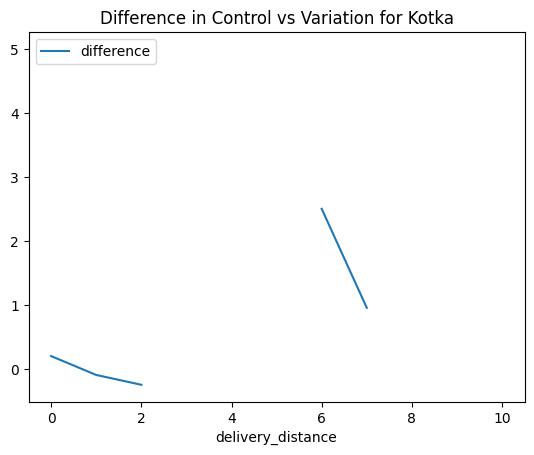

Kouvola


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



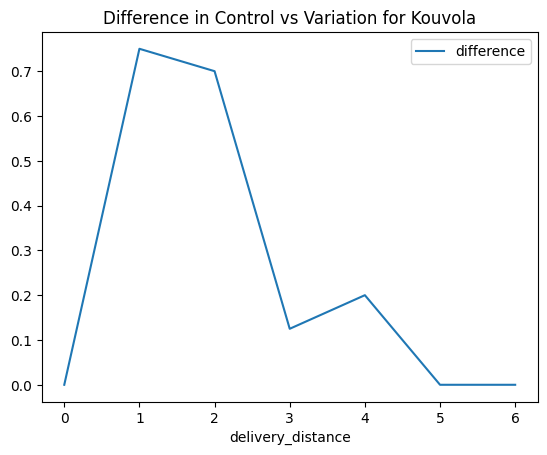

Kuopio


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



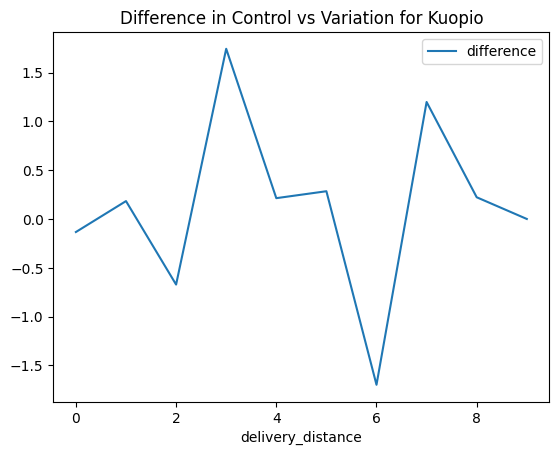

Lahti


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



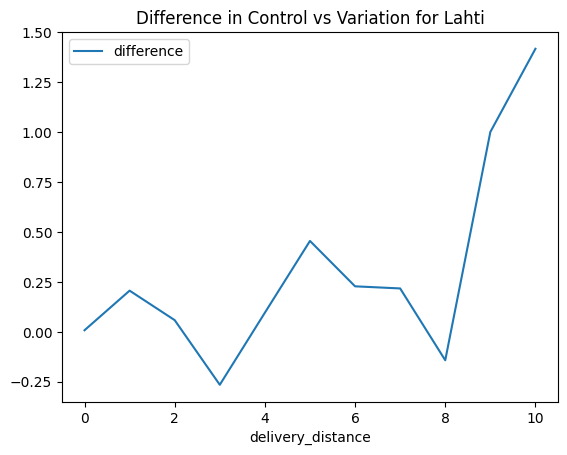

Lappeenranta


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



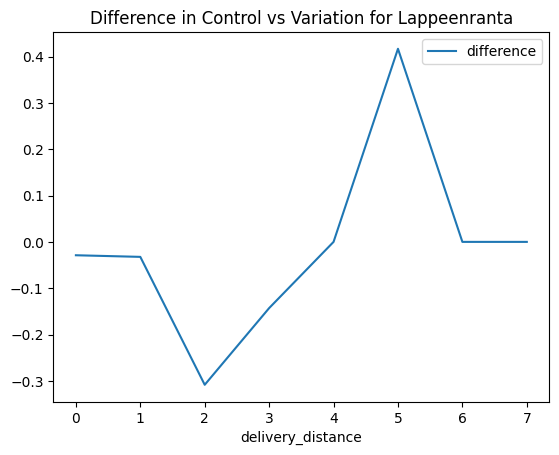

Lohja


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



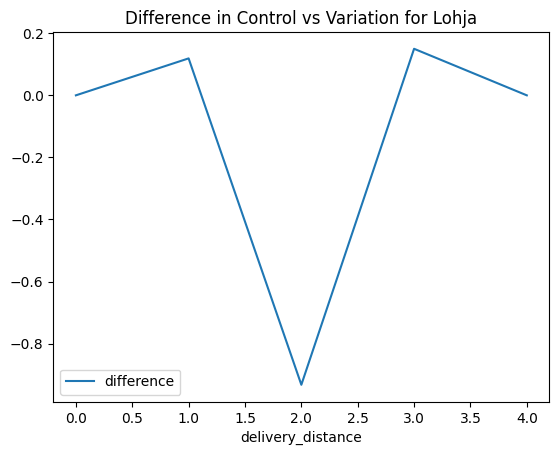

Mantsala


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



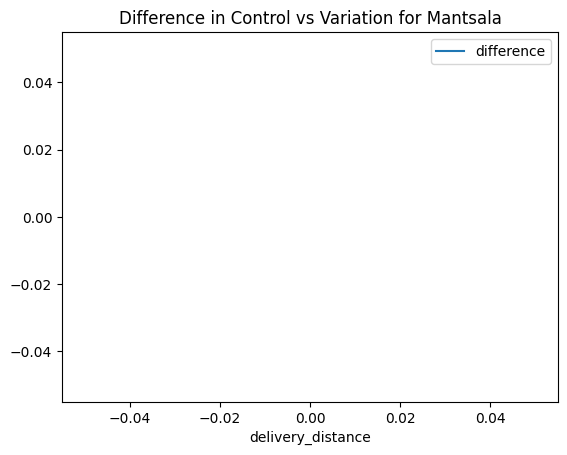

Mikkeli


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



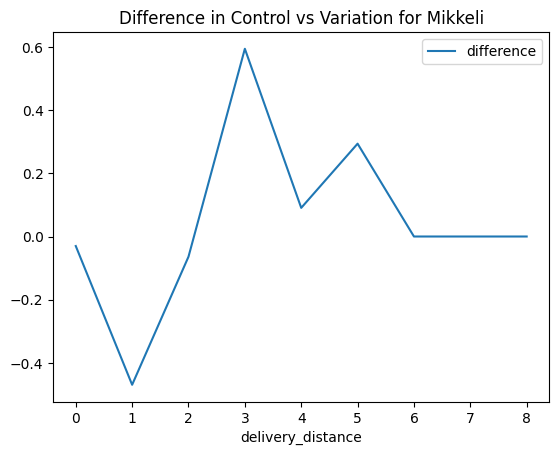

Oulu


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



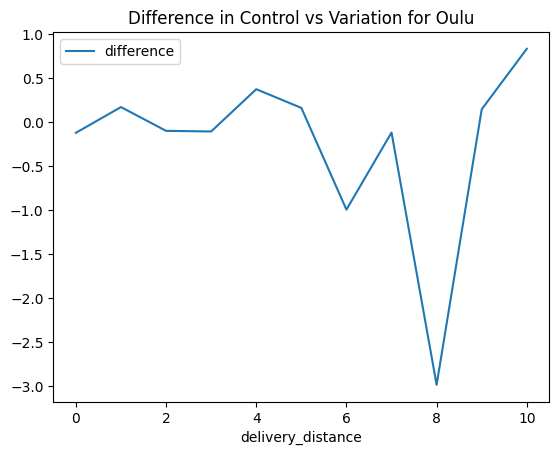

Pieksamaki


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



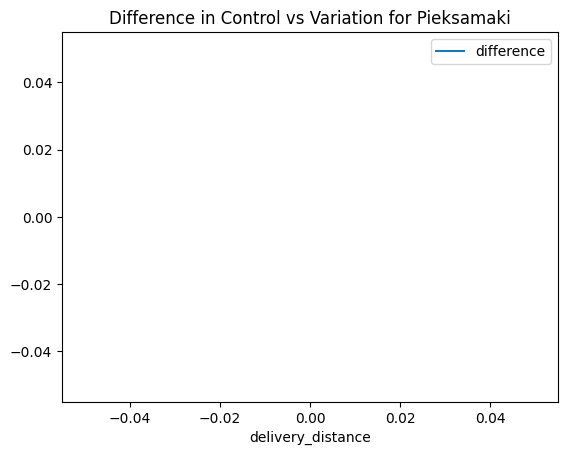

Pori


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



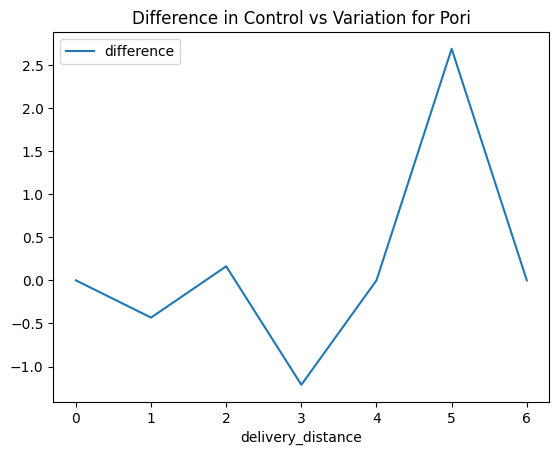

Porvoo


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



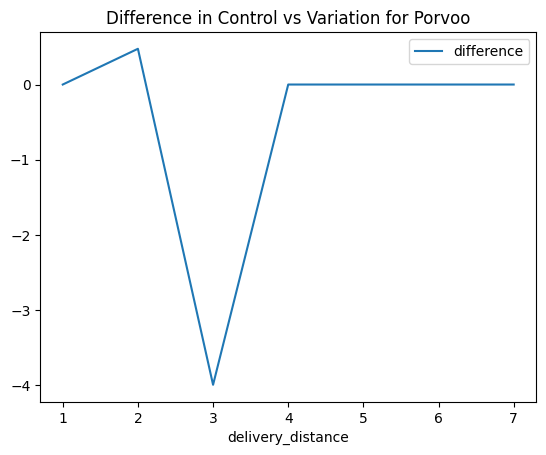

Rauma


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



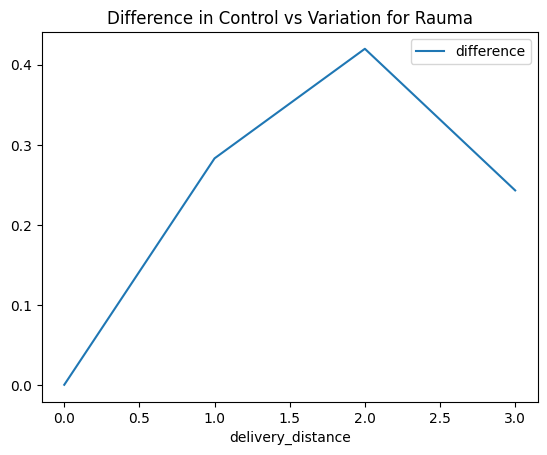

Riihimaki


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



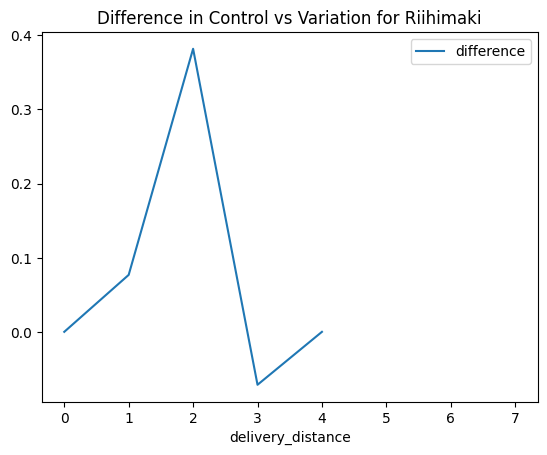

Rovaniemi


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



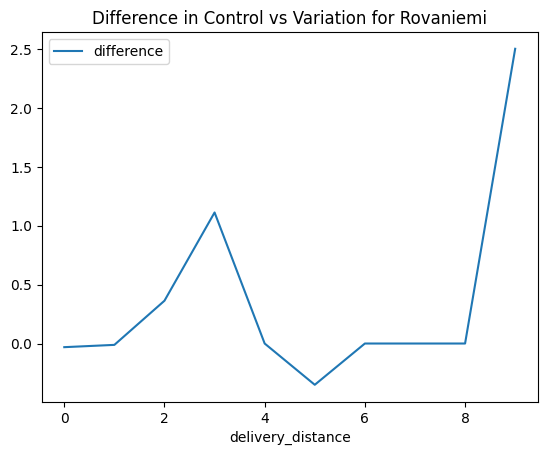

Seinajoki


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



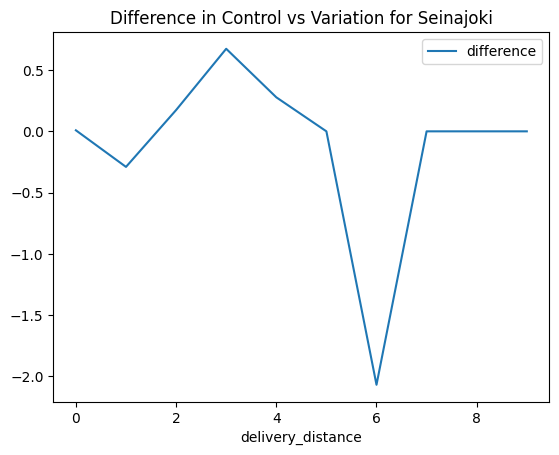

Tampere


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



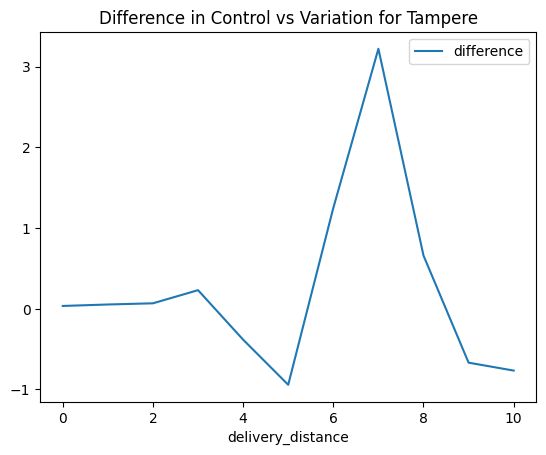

Tornio


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



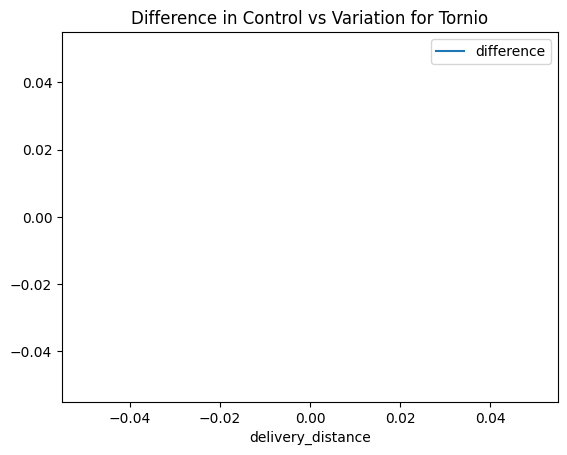

Turku


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



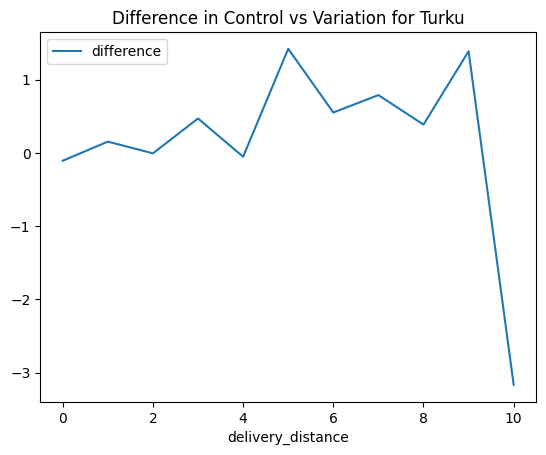

Vaasa


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



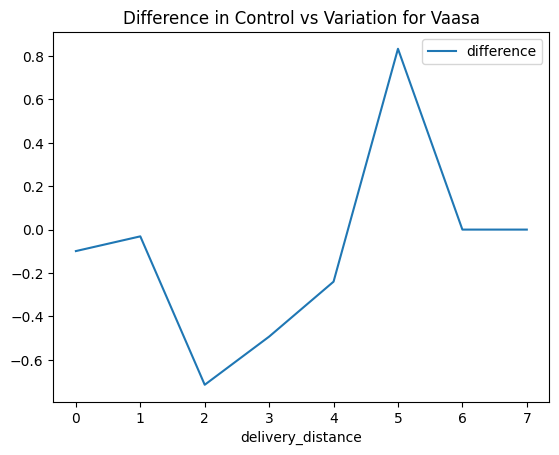

Valkeakoski


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3427777760.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



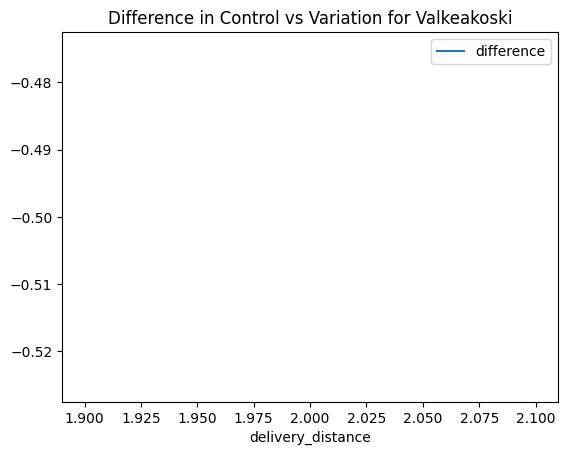

In [ ]:
# Group by 'delivery_distance' and apply custom aggregation functions
result_city = filtered_df.groupby(['city_name','delivery_distance']).agg(
    control=('delivery_fee_eur', lambda x: control_df(data.loc[x.index])),
    variation=('delivery_fee_eur', lambda x: variation_df(data.loc[x.index]))
).reset_index()


for city in result_city['city_name'].unique():

    print(city)
    test = result_city[result_city['city_name'] == city]

    test['difference'] = test['control'] - test['variation']

    # Plot the data
    ax = test.plot(x='delivery_distance', y='difference', title=f'Difference in Control vs Variation for {city}')

    # Display the plot
    plt.show()    

In [ ]:
vendor_control = finland_details[(finland_details['delivery_distance'].between(5,8)) & (finland_details['category'] == 'standard') & (finland_details['variant'] == 'Control')]['vendor_id'].to_list()

vendor_treatment = finland_details[(finland_details['delivery_distance'].between(5,8)) & (finland_details['category'] == 'standard') & (finland_details['variant'] == 'Variation1')]['vendor_id'].to_list()

print(len(vendor_control),len(vendor_treatment))




2076 2073


In [30]:
# Load data
data = finland_details.copy()

data = data[(data['target_group'] == 'Chains not in targeting') & (data['delivery_fee_eur'] != 0)]


# Function to create quantile-based distance buckets for each city
def create_distance_buckets(data, q=4):
    data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=q, duplicates='drop')
    
    # Handle cases where quantile ranges might not be created as expected
    if pd.isnull(data['distance_bucket']).any():
        data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=q, duplicates='drop', precision=0)
    
    quantile_ranges = data['distance_bucket'].cat.categories
    labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]
    label_mapping = dict(zip(quantile_ranges, labels))
    data['distance_bucket'] = data['distance_bucket'].map(label_mapping)
    return data

# Apply the function to each city
data = data.groupby('city_name').apply(create_distance_buckets).reset_index(drop=True)

# Proceed with the original analysis and plotting code
grouped = data.groupby(['city_name', 'perseus_client_id', 'variant', 'distance_bucket']).agg({
    'platform_order_code': 'nunique'
}).reset_index()

# Rename the columns
grouped.columns = ['city', 'user_id', 'variant', 'distance_bucket', 'total_orders']

grouped

# Initialize lists to hold the results
plot_data_list = []

# Iterate over each city
for city in grouped['city'].unique():
    city_data = grouped[grouped['city'] == city]
    
    # Group by distance_bucket to calculate the mean and standard error
    city_grouped = city_data.groupby(['variant', 'distance_bucket'])['total_orders'].agg(['mean', 'sem']).reset_index()
    
    # Initialize lists to hold the results for this city
    distances = []
    mean_diffs = []
    combined_sems = []
    
    # Calculate differences and errors for each distance group
    for distance in city_grouped['distance_bucket'].unique():
        control = city_grouped[(city_grouped['distance_bucket'] == distance) & (city_grouped['variant'] == 'Control')]
        variation = city_grouped[(city_grouped['distance_bucket'] == distance) & (city_grouped['variant'] == 'Variation1')]
        
        if not control.empty and not variation.empty:
            control_mean = control['mean'].values[0]
            variation_mean = variation['mean'].values[0]
            control_sem = control['sem'].values[0]
            variation_sem = variation['sem'].values[0]
            
            mean_diff = variation_mean - control_mean
            combined_sem = np.sqrt(control_sem**2 + variation_sem**2)
            
            distances.append(distance)
            mean_diffs.append(mean_diff)
            combined_sems.append(combined_sem)
    
    # Create the dataframe for plotting for this city
    plot_data = {
        'distance': distances,
        'change': mean_diffs,
        'error': combined_sems,
        'city': city
    }
    plot_data_list.append(pd.DataFrame(plot_data))

# Concatenate all city dataframes
final_plot_df = pd.concat(plot_data_list)

# Plotting
for city in final_plot_df['city'].unique():
    city_plot_df = final_plot_df[final_plot_df['city'] == city]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the error bars
    ax.errorbar(city_plot_df['change'], city_plot_df['distance'], xerr=city_plot_df['error'], fmt='o', color='black', ecolor='black', elinewidth=2, capsize=4)
    
    # Add vertical line at x=0
    ax.axvline(x=0, color='gray', linestyle='--')
    
    # Set labels
    ax.set_xlabel('Change in Standard Orders/User')
    ax.set_ylabel('Distance Buckets')
    ax.set_title(f'Difference in Standard Orders/User Between Control and Variation Group by Distance in {city}')
    
    # Show plot
    plt.tight_layout()
    plt.show()

NameError: name 'finland_details' is not defined

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from tqdm import tqdm

# Load data
data = finland_details.copy()

# Data Cleaning
data.dropna(inplace=True)

data = data[data['category'] == 'standard']

# Separate the data into control and treatment groups
control = data[data['variant'] == 'Control']['delivery_distance']
treatment = data[data['variant'] == 'Variation1']['delivery_distance']

# Function to calculate bootstrap samples and t-statistics
def bootstrap_t_statistic(control, treatment, n_bootstrap=1000):
    bootstrap_t_stats = []
    for _ in tqdm(range(n_bootstrap)):
        # Resample with replacement
        bootstrap_control = np.random.choice(control, size=len(control), replace=True)
        bootstrap_treatment = np.random.choice(treatment, size=len(treatment), replace=True)
        # Calculate the t-statistic
        t_stat, _ = ttest_ind(bootstrap_control, bootstrap_treatment)
        bootstrap_t_stats.append(t_stat)
    return bootstrap_t_stats

# Generate bootstrap t-statistics
bootstrap_t_stats = bootstrap_t_statistic(control.values, treatment.values, n_bootstrap=1000)

# Calculate the original t-statistic and p-value
t_stat, p_value = ttest_ind(control, treatment)

# Plotting the bootstrapped t-statistics distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_t_stats, bins=30, alpha=0.7, color='grey', edgecolor='black', density=True)
plt.axvline(t_stat, color='red', linestyle='dashed', linewidth=2, label=f'Observed t-statistic: {t_stat:.2f}')
plt.title('Bootstrapped Distribution of t-Statistics')
plt.xlabel('t-statistic')
plt.ylabel('Density')
plt.legend()
plt.show()

# Print the t-statistic and empirical p-value
print(f'Observed T-statistic: {t_stat:.2f}')
print(f'Empirical P-value: {np.mean(np.abs(bootstrap_t_stats) >= np.abs(t_stat)):.2e}')


NameError: name 'finland_details' is not defined

In [32]:
# Load data
data = finland_details.copy()

# Data Cleaning
data.dropna(inplace=True)

# Rounding delivery_distance
data['delivery_distance'] = data['delivery_distance'].round(0)

# # Create 4 quantile-based buckets without labels first
# data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=5)

# # Get the quantile ranges
# quantile_ranges = data['distance_bucket'].unique()

# # Create a mapping for the new labels based on the quantile ranges
# labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# # Create a dictionary to map the original intervals to the new labels
# label_mapping = dict(zip(quantile_ranges, labels))

# # Apply the new labels to the distance_bucket column
# data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

# Define the condition functions
def count_standard(df):
    return df[df['category'] == 'standard']['platform_order_code'].nunique() / df['platform_order_code'].nunique()

def count_priority(df):
    return df[df['category'] == 'priority']['platform_order_code'].nunique() / df['platform_order_code'].nunique()

def count_saver(df):
    return df[df['category'] == 'saver']['platform_order_code'].nunique() / df['platform_order_code'].nunique()

# Group by variant and distance_bucket, then apply the custom aggregation functions
result = data.groupby(['variant', 'delivery_distance']).agg(
    standard_perc=('platform_order_code', lambda x: count_standard(data.loc[x.index])),
    unique_priority_perc=('platform_order_code', lambda x: count_priority(data.loc[x.index])),
    unique_saver_perct=('platform_order_code', lambda x: count_saver(data.loc[x.index]))
).reset_index()

result

NameError: name 'finland_details' is not defined

In [465]:
data

,country,city_name,entity_id,variant,category,target_group,perseus_client_id,vendor_id,chain_id,platform_order_code,revenue_eur,avg_delivery_cost,avg_profit,delivery_fee_eur,commission_eur,delivery_distance,actual_delivery_time,distance_bucket
5994,Finland,Oulu,PO_FI,Control,standard,Chains not in targeting,1705502000789.627483233623723402.LBmpuoNFl5,s9fh,cm7qt,s9fh-2420-u2uh,3.408421,9.273454,-5.865033,0E-9,2.540000000,3.523,24.50,2-16 km
5995,Finland,Oulu,PO_FI,Control,standard,Chains not in targeting,1704729157707.617920820633448135.SuOfwcmvRW,s9fh,cm7qt,s9fh-2420-h6yo,3.648421,5.003773,-1.355352,0E-9,2.780000000,1.013,32.10,0-1 km
5996,Finland,Oulu,PO_FI,Control,standard,Chains not in targeting,1609975696272.3523615661.ryhxjhqaqp,s9fh,cm7qt,s9fh-2420-ho2b,3.408421,6.554653,-3.146231,0E-9,2.540000000,2.518,25.60,1-2 km
5997,Finland,Oulu,PO_FI,Control,standard,Chains not in targeting,1659620282233.1818681470.pxoztyqsbv,s9fh,cm7qt,s9fh-2420-d6ej,3.408421,5.001384,-1.592962,0E-9,2.540000000,0.869,18.50,0-0 km
6002,Finland,Turku,PO_FI,Control,standard,Chains not in targeting,1692543906595.3845988401.lvffxzzqok,s2do,cw4ue,s2do-zh46,2.808421,8.974989,-6.166568,0E-9,1.940000000,2.648,34.63,1-2 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120042,Finland,Helsinki,PO_FI,Variation1,standard,Chains not in targeting,1591987983936.8221847522.fzqsnbdifn,move,cl3xo,move-2428-s1dc,6.792632,6.320000,0.472632,2.990000000,2.740000000,2.700,17.87,1-2 km
120043,Finland,Helsinki,PO_FI,Variation1,standard,Chains not in targeting,1716557126466.516736678484397538.XLJXFxm9Rk,s3ld,cw4ue,s3ld-t9gw,7.543860,0.000000,7.543860,2.990000000,4.000000000,1.701,19.37,1-1 km
120044,Finland,Helsinki,PO_FI,Variation1,standard,Chains not in targeting,1629810899802.655135070936438749.w1oZ0x1XnD,o8gt,cs8kk,o8gt-2428-ql4r,6.653860,6.080000,0.573860,2.990000000,3.110000000,2.539,35.07,1-2 km
120064,Finland,Tampere,PO_FI,Variation1,standard,Chains not in targeting,1667736410038.1055399172.bgifuyewpc,n2ra,cw4ue,n2ra-iplg,7.573860,4.550000,3.023860,2.990000000,4.030000000,1.534,28.73,1-1 km


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3932220785.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/3932220785.py:35: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



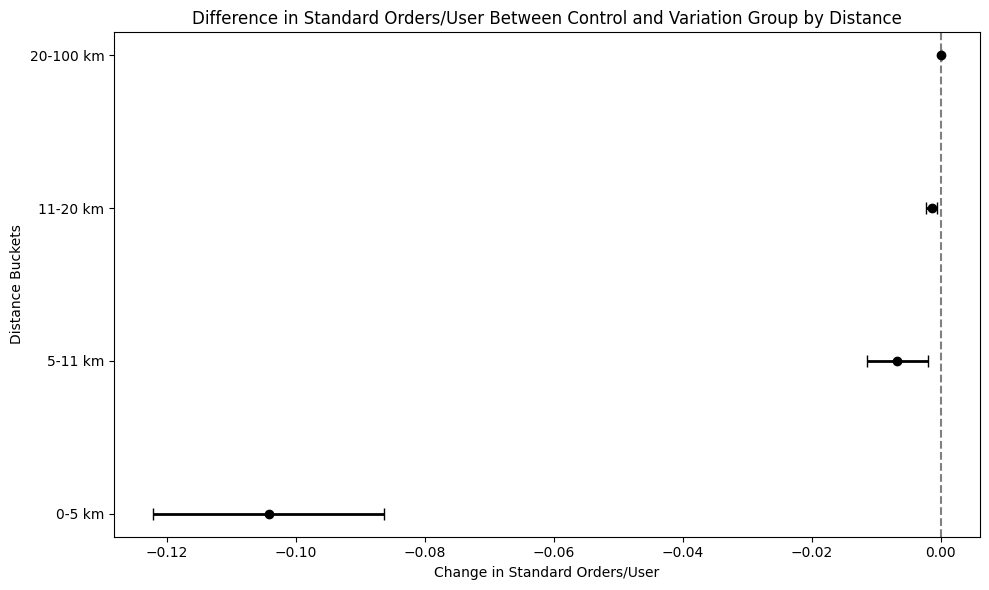

In [867]:
# Load data
data = finland_details.copy()

data = data[(data['category'] == 'standard') & (data['delivery_fee_eur'] != 0)]

# # Create 4 quantile-based buckets without labels first
# data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=8)

# # Get the quantile ranges, excluding NaN values
# quantile_ranges = data['distance_bucket'].dropna().unique()

# # Create a mapping for the new labels based on the quantile ranges
# labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# # Create a dictionary to map the original intervals to the new labels
# label_mapping = {q: f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges}

# # Apply the new labels to the distance_bucket column
# data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

# Define distance buckets
bins = [0, 5, 11, 20, 100]
labels = ['0-5 km', '5-11 km', '11-20 km', '20-100 km']
data['distance_bucket'] = pd.cut(data['delivery_distance'], bins=bins, labels=labels)


grouped = data.groupby(['perseus_client_id','variant', 'distance_bucket']).agg({
    'platform_order_code': 'nunique'
}).reset_index()

# Rename the columns
grouped.columns = ['user_id', 'variant', 'distance_bucket', 'total_orders']

# Group by distance_bucket to calculate the mean and standard error
grouped = grouped.groupby(['variant','distance_bucket'])['total_orders'].agg(['mean', 'sem']).reset_index()

# Initialize lists to hold the results
distances = []
mean_diffs = []
combined_sems = []

# Calculate differences and errors for each distance group
for distance in grouped['distance_bucket'].unique():
    control = grouped[(grouped['distance_bucket'] == distance) & (grouped['variant'] == 'Control')]
    variation = grouped[(grouped['distance_bucket'] == distance) & (grouped['variant'] == 'Variation1')]
    
    if not control.empty and not variation.empty:
        control_mean = control['mean'].values[0]
        variation_mean = variation['mean'].values[0]
        control_sem = control['sem'].values[0]
        variation_sem = variation['sem'].values[0]
        
        mean_diff = variation_mean - control_mean
        combined_sem = np.sqrt(control_sem**2 + variation_sem**2)
        
        distances.append(distance)
        mean_diffs.append(mean_diff)
        combined_sems.append(combined_sem)

# Create the dataframe for plotting
plot_data = {
    'distance': distances,
    'change': mean_diffs,
    'error': combined_sems
}
plot_df = pd.DataFrame(plot_data)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the error bars
ax.errorbar(plot_df['change'], plot_df['distance'], xerr=plot_df['error'], fmt='o', color='black', ecolor='black', elinewidth=2, capsize=4)

# Add vertical line at x=0
ax.axvline(x=0, color='gray', linestyle='--')

# Set labels
ax.set_xlabel('Change in Standard Orders/User')
ax.set_ylabel('Distance Buckets')
ax.set_title('Difference in Standard Orders/User Between Control and Variation Group by Distance')

# Show plot
plt.tight_layout()
plt.show()


In [862]:
# Load data
data = finland_details.copy()

data = data[(data['category'] == 'standard') & (data['delivery_fee_eur'] != 0)]

# Create 4 quantile-based buckets without labels first
data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=4)

# Get the quantile ranges
quantile_ranges = data['distance_bucket'].unique()

# Create a mapping for the new labels based on the quantile ranges
labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# Create a dictionary to map the original intervals to the new labels
label_mapping = dict(zip(quantile_ranges, labels))

# Apply the new labels to the distance_bucket column
data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

# # Define distance buckets
# bins = [0, 5, 11, 20, 100]
# labels = ['0-5 km', '5-11 km', '11-20 km', '20-100 km']
# data['distance_bucket'] = pd.cut(data['delivery_distance'], bins=bins, labels=labels)


grouped = data.groupby(['perseus_client_id','variant', 'distance_bucket']).agg({
    'platform_order_code': 'nunique'
}).reset_index()

# Rename the columns
grouped.columns = ['user_id', 'variant', 'distance_bucket', 'total_orders']

# Group by distance_bucket to calculate the mean and standard error
grouped = grouped.groupby(['variant','distance_bucket'])['total_orders'].agg(['mean', 'sem']).reset_index()

# Initialize lists to hold the results
distances = []
mean_diffs = []
combined_sems = []

# Calculate differences and errors for each distance group
for distance in grouped['distance_bucket'].unique():
    control = grouped[(grouped['distance_bucket'] == distance) & (grouped['variant'] == 'Control')]
    variation = grouped[(grouped['distance_bucket'] == distance) & (grouped['variant'] == 'Variation1')]
    
    if not control.empty and not variation.empty:
        control_mean = control['mean'].values[0]
        variation_mean = variation['mean'].values[0]
        control_sem = control['sem'].values[0]
        variation_sem = variation['sem'].values[0]
        
        mean_diff = variation_mean - control_mean
        combined_sem = np.sqrt(control_sem**2 + variation_sem**2)
        
        distances.append(distance)
        mean_diffs.append(mean_diff)
        combined_sems.append(combined_sem)

# Create the dataframe for plotting
plot_data = {
    'distance': distances,
    'change': mean_diffs,
    'error': combined_sems
}
plot_df = pd.DataFrame(plot_data)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the error bars
ax.errorbar(plot_df['change'], plot_df['distance'], xerr=plot_df['error'], fmt='o', color='black', ecolor='black', elinewidth=2, capsize=4)

# Add vertical line at x=0
ax.axvline(x=0, color='gray', linestyle='--')

# Set labels
ax.set_xlabel('Change in Standard Orders/User')
ax.set_ylabel('Distance Buckets')
ax.set_title('Difference in Standard Orders/User Between Control and Variation Group by Distance')

# Show plot
plt.tight_layout()
plt.show()


AttributeError: 'float' object has no attribute 'left'

In [330]:
data['delivery_fee_eur'].describe()

count           46723
unique             51
top       1.990000000
freq             9550
Name: delivery_fee_eur, dtype: object

In [331]:
data

,country,city_name,entity_id,variant,category,perseus_client_id,vendor_id,chain_id,platform_order_code,revenue_eur,avg_delivery_cost,avg_profit,delivery_fee_eur,commission_eur,delivery_distance,actual_delivery_time,distance_bucket
65,Finland,Vaasa,PO_FI,Control,standard,1710846636706.729544239862404653.Jpbp1eLniD,t6z2,cm8ui,t6z2-2424-jvku,0.000000,4.502616,-4.502616,0.890000000,2.690000000,0.179,28.67,0-0 km
68,Finland,Helsinki,PO_FI,Control,standard,1663500372192.1178613681.baphmlxtbi,r9j5,cu4jd,r9j5-2424-0dnz,0.000000,7.704492,-7.704492,5.990000000,0E-9,3.601,41.77,3-4 km
70,Finland,Helsinki,PO_FI,Control,standard,1692631007757.908748675721791849.d1Reb69jJb,mnoi,cu4jd,mnoi-2424-zonq,0.000000,4.505896,-4.505896,2.990000000,2.580000000,2.827,36.62,2-3 km
74,Finland,Helsinki,PO_FI,Control,standard,1716738281003.2938593781.ccfxblxdux,e8za,cy0so,e8za-2421-fazq,0.000000,5.503560,-5.503560,1.990000000,3.780000000,0.643,16.12,0-0 km
76,Finland,Kotka,PO_FI,Control,standard,1693752871895.513978402443491590.Das4x5toSX,zgd6,cq9dc,zgd6-2421-5jpq,0.000000,15.234816,-15.234816,5.990000000,0E-9,8.221,34.25,7-18 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51340,Finland,Helsinki,PO_FI,Variation1,standard,1589470799369.9720940059.zbzharrnyb,bfoi,ca4tp,bfoi-2427-npeq,9.793860,14.711807,-4.917948,2.990000000,2.450000000,8.217,26.15,7-18 km
51341,Finland,Mikkeli,PO_FI,Variation1,standard,1676617007192.529712182436900035.rbFStiuI6r,mkde,cs7sw,mkde-2427-hp2i,9.377368,5.232047,4.145322,4.590000000,4.430000000,1.979,38.38,1-1 km
51342,Finland,Oulu,PO_FI,Variation1,standard,1720013754536.659434141194687533.cjqtdb3dea,v334,ca4tp,v334-2427-198l,9.281053,14.442405,-5.161352,0E-9,4.740000000,8.574,35.25,7-18 km
51343,Finland,Tampere,PO_FI,Variation1,standard,1702301899274.3471154713.rvvbhmcbjh,kyig,ca4tp,kyig-2427-pxgc,10.951053,16.091331,-5.140278,0E-9,5.240000000,9.121,23.65,7-18 km


In [769]:
# Load data
data = finland_details.copy()

data = data[(data['category'] == 'standard') & (data['target_group'] == 'Chains in targeting') & (data['delivery_fee_eur'] != 0)]

# Create 4 quantile-based buckets without labels first
data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=5)

# Get the quantile ranges
quantile_ranges = data['distance_bucket'].unique()

# Create a mapping for the new labels based on the quantile ranges
labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# Create a dictionary to map the original intervals to the new labels
label_mapping = dict(zip(quantile_ranges, labels))

# Apply the new labels to the distance_bucket column
data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

# # Define distance buckets
# bins = [0, 5, 11, 20, 100]
# labels = ['0-5 km', '5-11 km', '11-20 km', '20-100 km']
# data['distance_bucket'] = pd.cut(data['delivery_distance'], bins=bins, labels=labels)


data['delivery_fee_eur'] = data['delivery_fee_eur'].astype(float)

delivery_fee = data.groupby(['variant', 'distance_bucket']).agg({
    'delivery_fee_eur': ['mean','sem']
}).reset_index()

# Rename the columns
delivery_fee.columns = ['variant', 'distance_bucket', 'mean','sem']

# Initialize lists to hold the results
distances = []
mean_diffs = []
combined_sems = []

# Calculate differences and errors for each distance group
for distance in delivery_fee['distance_bucket'].unique():
    control = delivery_fee[(delivery_fee['distance_bucket'] == distance) & (delivery_fee['variant'] == 'Control')]
    variation = delivery_fee[(delivery_fee['distance_bucket'] == distance) & (delivery_fee['variant'] == 'Variation1')]
    
    if not control.empty and not variation.empty:
        control_mean = control['mean'].values[0]
        variation_mean = variation['mean'].values[0]
        control_sem = control['sem'].values[0]
        variation_sem = variation['sem'].values[0]
        
        mean_diff = variation_mean - control_mean
        combined_sem = np.sqrt(control_sem**2 + variation_sem**2)
        
        distances.append(distance)
        mean_diffs.append(mean_diff)
        combined_sems.append(combined_sem)

# Create the dataframe for plotting
plot_data = {
    'distance': distances,
    'change': mean_diffs,
    'error': combined_sems
}
plot_df = pd.DataFrame(plot_data)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the error bars
ax.errorbar(plot_df['change'], plot_df['distance'], xerr=plot_df['error'], fmt='o', color='black', ecolor='black', elinewidth=2, capsize=4)

# Add vertical line at x=0
ax.axvline(x=0, color='gray', linestyle='--')

# Set labels
ax.set_xlabel('Change in Average Delivery fee')
ax.set_ylabel('Distance Buckets')
ax.set_title('Difference in Average Delivery fee Between Control and Variation Groups by Distance')

# Show plot
plt.tight_layout()
plt.show()


from scipy import stats

for label in labels:
    control_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Control')]['delivery_fee_eur']
    variation_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Variation1')]['delivery_fee_eur']
    t_stat, p_val = stats.ttest_ind(variation_fees, control_fees)
    print(f"Distance Bucket {label}: t_stat={t_stat}, p_val={p_val}")


AttributeError: 'float' object has no attribute 'left'

In [333]:
delivery_fee

,variant,distance_bucket,mean,sem
0,Control,0-5 km,2.560732,0.011674
1,Control,5-11 km,4.737747,0.053398
2,Control,11-20 km,5.904112,0.331198
3,Control,20-100 km,NaN,NaN
4,Variation1,0-5 km,2.503483,0.012250
5,Variation1,5-11 km,4.529159,0.054107
6,Variation1,11-20 km,6.658106,0.360783
7,Variation1,20-100 km,NaN,NaN


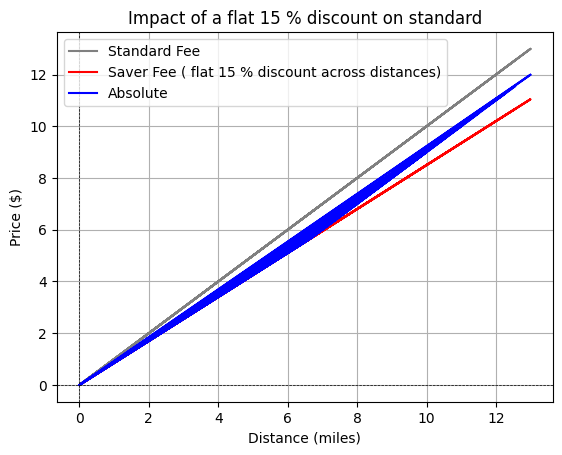

In [498]:
# Load data
data = finland_details.copy()
# Data Cleaning
data = data[data['category'] == 'standard']
data.dropna(inplace=True)

# Rounding delivery_distance
data['delivery_distance'] = data['delivery_distance'].round(1)

# Creating pivot table
table = pd.pivot_table(data, values=['delivery_fee_eur', 'platform_order_code', 'actual_delivery_time'],
                       index='delivery_distance', columns=['variant'], 
                       aggfunc={"delivery_fee_eur": "mean", "platform_order_code": "nunique", "actual_delivery_time": "mean"}).reset_index()

# Flattening the columns
table.columns = ['_'.join(col).strip() if col[1] else col[0] for col in table.columns.values]

# Calculating the difference
table['difference'] = table['delivery_fee_eur_Control'] - table['delivery_fee_eur_Variation1']

# Calculate final prices after applying percentage discount
table['average_saver_price'] = table['delivery_fee_eur_Control'] * (1 - 0.15)

discount_rate = 0.15
cap_amount = 1  # Example cap amount, you can change this to the desired cap value

# Calculate the discounted amount with a cap
table['discount_amount'] = np.where(
    table['delivery_fee_eur_Control'] * discount_rate > cap_amount,
    cap_amount,
    table['delivery_fee_eur_Control'] * discount_rate
)

# Calculate the final price after applying the discount
table['absolute_saver'] = table['delivery_fee_eur_Control'] - table['discount_amount']

# Drop the 'discount_amount' column if you don't need it anymore
table.drop(columns=['discount_amount'], inplace=True)


table['discount_difference'] = table['delivery_fee_eur_Control'] - table['average_saver_price']

# Extracting columns from the DataFrame
distances = table['delivery_distance']
saver_fee = table['average_saver_price']
standard_fee = table['delivery_fee_eur_Control']
discount_difference = table['discount_difference']
ab_saver = table['absolute_saver']

# Creating the plot
plt.plot(standard_fee, standard_fee, label='Standard Fee', color='grey')
plt.plot(standard_fee, saver_fee, label='Saver Fee ( flat 15 % discount across distances)', color='red')
plt.plot(standard_fee, ab_saver, label='Absolute', color='blue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

# Adding labels and title
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')
plt.title('Impact of a flat 15 % discount on standard')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

# orders_control = table['difference']
# orders_variation = table['platform_order_code_Variation1']

# # Creating the plot
# plt.plot(distances, orders_control, label='15% Discount', color='blue')
# plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
# plt.axvline(0, color='black', linewidth=0.5, linestyle='--')

# # Adding labels and title
# plt.xlabel('Distance (miles)')
# plt.ylabel('Price ($)')
# plt.title('Impact of Percentage vs Absolute Discount on Price by Distance')
# plt.legend()
# plt.grid(True)

# # Display the plot
# plt.show()

The cap distance for the discount should be: 17.0 units
The flat discount amount is: 0.88921875 units


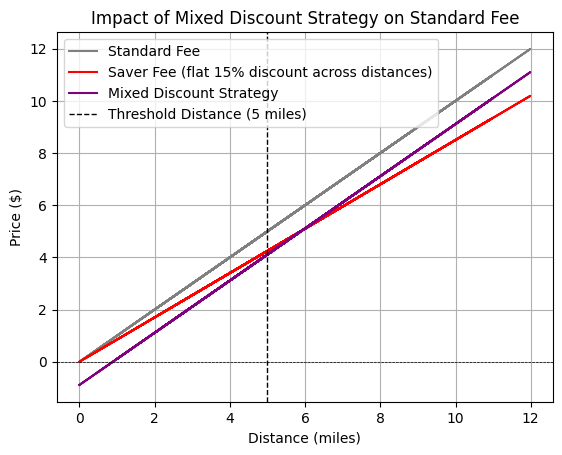

In [525]:
# Load data
data = finland_details.copy()

# Data Cleaning
data = data[data['category'] == 'standard']
data.dropna(inplace=True)

data['delivery_distance'] = data['delivery_distance'].round(2)

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
data = data[data['delivery_distance'] <= percentile_99_value]


# Creating pivot table
table = pd.pivot_table(data, values=['delivery_fee_eur', 'platform_order_code', 'actual_delivery_time'],
                       index='delivery_distance', columns=['variant'], 
                       aggfunc={"delivery_fee_eur": "mean", "platform_order_code": "nunique", "actual_delivery_time": "mean"}).reset_index()

# Flattening the columns
table.columns = ['_'.join(col).strip() if col[1] else col[0] for col in table.columns.values]

# Calculating the difference
table['difference'] = table['delivery_fee_eur_Control'] - table['delivery_fee_eur_Variation1']

# Calculate final prices after applying percentage discount
table['average_saver_price'] = table['delivery_fee_eur_Control'] * (1 - 0.15)

# Assuming 'table' is your DataFrame and 'delivery_fee_eur_Control' is the column of interest
discount_rate = 0.15

# Define the threshold distance and calculate the flat discount amount based on the threshold distance
threshold_distance = 5
flat_discount_amount = table.loc[table['delivery_distance'] == threshold_distance, 'delivery_fee_eur_Control'].values[0] * discount_rate

print(f"The cap distance for the discount should be: {cap_distance} units")
print(f"The flat discount amount is: {flat_discount_amount} units")

# Calculate the discounted amount with a cap based on distance
def apply_mixed_discount(row, threshold_distance, flat_discount_amount, discount_rate=0.15):
    if row['delivery_distance'] > threshold_distance:
        return row['delivery_fee_eur_Control'] - flat_discount_amount
    else:
        None

table['absolute_saver'] = table.apply(apply_mixed_discount, axis=1, args=(threshold_distance, flat_discount_amount, discount_rate))

# Calculating the discount difference for the plot
table['discount_difference'] = table['delivery_fee_eur_Control'] - table['average_saver_price']

# Extracting columns from the DataFrame
distances = table['delivery_distance']
saver_fee = table['average_saver_price']
standard_fee = table['delivery_fee_eur_Control']
discount_difference = table['discount_difference']
ab_saver = table['absolute_saver']

# Creating the plot
plt.plot(standard_fee, standard_fee, label='Standard Fee', color='grey')
plt.plot(standard_fee, saver_fee, label='Saver Fee (flat 15% discount across distances)', color='red')
plt.plot(standard_fee, ab_saver, label='Mixed Discount Strategy', color='purple')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(threshold_distance, color='black', linewidth=1, linestyle='--', label=f'Threshold Distance ({threshold_distance} miles)')

# Adding labels and title
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')
plt.title('Impact of Mixed Discount Strategy on Standard Fee')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

The cap distance for the discount should be: 17.0 units
The flat discount amount is: 0.89 units


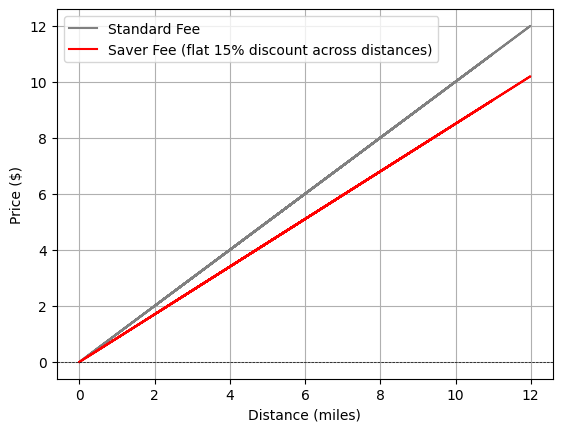

In [612]:
# Load data
data = finland_details.copy()

# Data Cleaning
data = data[data['category'] == 'standard']
data.dropna(inplace=True)

data['delivery_distance'] = data['delivery_distance'].round(2)

# Calculate the 99th percentile value
percentile_99_value = data['delivery_distance'].quantile(0.99)

# Filter the DataFrame to keep only the 99th percentile data
data = data[data['delivery_distance'] <= percentile_99_value]

# Creating pivot table
table = pd.pivot_table(data, values=['delivery_fee_eur', 'platform_order_code', 'actual_delivery_time'],
                       index='delivery_distance', columns=['variant'], 
                       aggfunc={"delivery_fee_eur": "mean", "platform_order_code": "nunique", "actual_delivery_time": "mean"}).reset_index()

# Flattening the columns
table.columns = ['_'.join(col).strip() if col[1] else col[0] for col in table.columns.values]

# Calculating the difference
table['difference'] = table['delivery_fee_eur_Control'] - table['delivery_fee_eur_Variation1']

# Calculate final prices after applying percentage discount
table['average_saver_price'] = table['delivery_fee_eur_Control'] * (1 - 0.15)

# Assuming 'table' is your DataFrame and 'delivery_fee_eur_Control' is the column of interest
discount_rate = 0.15

# Define the threshold distance and calculate the flat discount amount based on the threshold distance
threshold_distance = 5
flat_discount_amount = round(table.loc[table['delivery_distance'] == threshold_distance, 'delivery_fee_eur_Control'].values[0] * discount_rate,2)

print(f"The cap distance for the discount should be: {cap_distance} units")
print(f"The flat discount amount is: {flat_discount_amount} cents")

# Calculate the discounted amount with a cap based on distance
def apply_mixed_discount(row, threshold_distance, flat_discount_amount, discount_rate=0.15):
    if row['delivery_distance'] > threshold_distance:
        return row['delivery_fee_eur_Control'] - flat_discount_amount
    else:
        return np.nan

table['absolute_saver'] = table.apply(apply_mixed_discount, axis=1, args=(threshold_distance, flat_discount_amount, discount_rate))

# Calculating the discount difference for the plot
table['discount_difference'] = table['delivery_fee_eur_Control'] - table['average_saver_price']

# Extracting columns from the DataFrame
distances = table['delivery_distance']
saver_fee = table['average_saver_price']
standard_fee = table['delivery_fee_eur_Control']
discount_difference = table['discount_difference']
ab_saver = table['absolute_saver']

# Creating the plot
plt.plot(standard_fee, standard_fee, label='Standard Fee', color='grey')
plt.plot(standard_fee, saver_fee, label='Saver Fee (flat 15% discount across distances)', color='red')
#plt.plot(standard_fee[distances > threshold_distance], ab_saver[distances > threshold_distance], label='Mixed Discount Strategy', color='purple')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
#plt.axvline(threshold_distance, color='black', linewidth=1, linestyle='--', label=f'Threshold Distance ({threshold_distance} miles)')

# Adding labels and title
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [335]:
# Load data
data = finland_details.copy()

data = data[data['category'] == 'standard']

# Data Cleaning
data.dropna(inplace=True)

# Create 4 quantile-based buckets without labels first
data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=4)

# Get the quantile ranges
quantile_ranges = data['distance_bucket'].unique()

# Create a mapping for the new labels based on the quantile ranges
labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# Create a dictionary to map the original intervals to the new labels
label_mapping = dict(zip(quantile_ranges, labels))

# Apply the new labels to the distance_bucket column
data['distance_bucket'] = data['distance_bucket'].map(label_mapping)


grouped = data.groupby(['distance_bucket', 'variant']).agg({
    'platform_order_code': ['mean', 'count']
}).reset_index()

# Rename the columns
grouped.columns = ['delivery_distance', 'variant', 'unique_orders', 'total_orders']



/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_4102/2800933904.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# import pandas as pd
# import numpy as np

# # Example data
# data = {
#     'order_id': ['ORD001', 'ORD002', 'ORD003', 'ORD004', 'ORD005', 'ORD006'],
#     'group': ['A', 'A', 'B', 'B', 'A', 'B']
# }

# # Create a DataFrame
# df = pd.DataFrame(data)

# # Group by the 'group' column and count the number of orders
# grouped_counts = df.groupby('group')['order_id'].count().reset_index(name='count')

# # Calculate the standard error for the counts
# grouped_counts['standard_error'] = np.sqrt(grouped_counts['count']) / np.sqrt(len(df))

# # Display the result
# print(grouped_counts)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


grouped = data.groupby(['delivery_distance', 'variant']).agg({
    'platform_order_code': ['mean', 'count']
}).reset_index()

# Rename the columns
grouped.columns = ['delivery_distance', 'variant', 'unique_orders', 'total_orders']

# #Calculate the standard error for the counts
# grouped['standard_error'] = np.sqrt(grouped['platform_order_code']) / np.sqrt(len(df))

# # Initialize lists to hold the results
# distances = []
# mean_diffs = []
# combined_sems = []

# # Calculate differences and errors for each distance group
# for distance in grouped['distance'].unique():
#     control = grouped[(grouped['distance'] == distance) & (grouped['group'] == 'control')]
#     variation = grouped[(grouped['distance'] == distance) & (grouped['group'] == 'variation')]
    
#     if not control.empty and not variation.empty:
#         control_mean = control['mean'].values[0]
#         variation_mean = variation['mean'].values[0]
#         control_sem = control['sem'].values[0]
#         variation_sem = variation['sem'].values[0]
        
#         mean_diff = variation_mean - control_mean
#         combined_sem = np.sqrt(control_sem**2 + variation_sem**2)
        
#         distances.append(distance)
#         mean_diffs.append(mean_diff)
#         combined_sems.append(combined_sem)

# # Create the dataframe for plotting
# plot_data = {
#     'distance': distances,
#     'change': mean_diffs,
#     'error': combined_sems
# }
# plot_df = pd.DataFrame(plot_data)

# # Create the figure and axis
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot the error bars
# ax.errorbar(plot_df['change'], plot_df['distance'], xerr=plot_df['error'], fmt='o', color='black', ecolor='black', elinewidth=2, capsize=4)

# # Add vertical line at x=0
# ax.axvline(x=0, color='gray', linestyle='--')

# # Set labels
# ax.set_xlabel('Change in Number of Orders')
# ax.set_ylabel('Distance')
# ax.set_title('Difference in Orders Between Control and Variation Groups by Distance')

# # Show plot
# plt.tight_layout()
# plt.show()


TypeError: agg function failed [how->mean,dtype->object]

In [219]:
grouped

,delivery_distance,variant,platform_order_code
0,0.0,Control,26
1,0.0,Variation1,34
2,0.1,Control,254
3,0.1,Variation1,210
4,0.2,Control,449
...,...,...,...
305,17.8,Control,1
306,18.1,Variation1,2
307,18.2,Variation1,1
308,18.3,Control,1


In [253]:
# Load data
data = finland_details.copy()

data = data[data['category'] == 'standard']

# Data Cleaning
data.dropna(inplace=True)

# Create 4 quantile-based buckets without labels first
data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=4)

# Get the quantile ranges
quantile_ranges = data['distance_bucket'].unique()

# Create a mapping for the new labels based on the quantile ranges
labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# Create a dictionary to map the original intervals to the new labels
label_mapping = dict(zip(quantile_ranges, labels))

# Apply the new labels to the distance_bucket column
data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

# # Segmentation Analysis
# segmented_data = data.groupby(['distance_bucket', 'variant'])['delivery_fee_eur'].mean().unstack()
# segmented_data['difference'] = segmented_data['Variation1'] - segmented_data['Control']

# # Print segmented data for inspection
# print(segmented_data)

for label in labels:
    control_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Control')]['delivery_fee_eur']
    variation_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Variation1')]['delivery_fee_eur']
    t_stat, p_val = stats.ttest_ind(variation_fees, control_fees)
    print(f"Distance Bucket {label}: t_stat={t_stat}, p_val={p_val}")

AttributeError: 'DataFrame' object has no attribute 'ttest_ind'

In [180]:
data

,country,city_name,entity_id,variant,category,vendor_id,chain_id,platform_order_code,revenue_eur,avg_delivery_cost,avg_profit,delivery_fee_eur,commission_eur,delivery_distance,actual_delivery_time,distance_bucket
2615,Finland,Jyvaskyla,PO_FI,Control,standard,r0rh,cc9jt,r0rh-2426-hpf1,4.546667,5.00,-0.453333,1.990000000,1.570000000,1.056,17.38,0-1 km
2616,Finland,Helsinki,PO_FI,Control,standard,v5jt,cw1rn,v5jt-2426-5p8w,4.733860,7.10,-2.366140,2.990000000,1.190000000,2.550,35.77,1-3 km
2617,Finland,Helsinki,PO_FI,Control,standard,bfoi,ca4tp,bfoi-2426-cigv,5.360175,8.29,-2.929825,0E-9,1.220000000,3.338,24.58,3-18 km
2618,Finland,Helsinki,PO_FI,Control,standard,rf32,ca4tp,rf32-2426-ps98,9.061053,19.01,-9.948947,0E-9,2.120000000,10.390,17.65,3-18 km
2619,Finland,Helsinki,PO_FI,Control,standard,tw69,ck2wa,tw69-2426-bebr,3.051053,5.50,-2.448947,0E-9,2.130000000,1.500,24.17,0-1 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49914,Finland,Tampere,PO_FI,Variation1,standard,howi,ch2aj,howi-2420-yzf8,10.752982,5.25,5.502982,3.790000000,6.560000000,1.991,27.68,1-3 km
49915,Finland,Oulu,PO_FI,Variation1,standard,v334,ca4tp,v334-2420-1iez,15.226491,14.70,0.526491,5.390000000,3.720000000,8.211,31.62,3-18 km
49916,Finland,Helsinki,PO_FI,Variation1,standard,rf32,ca4tp,rf32-2420-p6im,10.616491,10.85,-0.233509,5.390000000,2.240000000,7.993,40.75,3-18 km
49917,Finland,Oulu,PO_FI,Variation1,standard,v334,ca4tp,v334-2420-3c1b,16.806491,13.00,3.806491,5.390000000,4.450000000,7.091,38.68,3-18 km


In [172]:
# Load data
data = finland_details.copy()

data = data[data['category'] == 'standard']

# Data Cleaning
data.dropna(inplace=True)

# # Create 4 quantile-based buckets without labels first
# data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=4)

# # Get the quantile ranges
# quantile_ranges = data['distance_bucket'].unique()

# # Create a mapping for the new labels based on the quantile ranges
# labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# # Create a dictionary to map the original intervals to the new labels
# label_mapping = dict(zip(quantile_ranges, labels))

# # Apply the new labels to the distance_bucket column
# data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

# Define distance buckets
bins = [0, 5, 10, 15, 20, 100]
labels = ['0-5 km', '5-10 km', '10-15 km', '15-20 km', '20-100 km']
data['distance_bucket'] = pd.cut(data['delivery_distance'], bins=bins, labels=labels)

# labels = data['distance_bucket'].unique()


# Segmentation Analysis
segmented_data = data.groupby(['distance_bucket', 'variant'])['delivery_fee_eur'].mean().unstack()
segmented_data['difference'] = segmented_data['Variation1'] - segmented_data['Control']

# Print segmented data for inspection
print(segmented_data)

# Visualize segmented analysis
segmented_data['difference'].unstack(level=0).plot(kind='bar', figsize=(14, 7))
plt.title('Average Delivery Fee Difference by Segment')
plt.xlabel('Distance Bucket')
plt.ylabel('Average Delivery Fee Difference')
plt.legend(title='Vendor')
plt.show()

data['delivery_fee_eur'] = pd.to_numeric(data['delivery_fee_eur'], errors='coerce')

labels = data['distance_bucket'].unique()
t_stats = []
p_values = []

for label in labels:
    control_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Control')]['delivery_fee_eur']
    variation_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Variation1')]['delivery_fee_eur']
    t_stat, p_val = stats.ttest_ind(variation_fees, control_fees)
    print(f"Distance Bucket {label}: t_stat={t_stat}, p_val={p_val}")

# Data for visualization
t_test_results = pd.DataFrame({
    'distance_bucket': labels,
    't_stat': t_stats,
    'p_value': p_values
})

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(t_test_results['distance_bucket'], t_test_results['t_stat'], color='skyblue')
plt.xlabel('Distance Bucket')
plt.ylabel('t-statistic')
plt.title('t-statistics for Each Distance Bucket')

# Annotate p-values
for bar, p_val in zip(bars, t_test_results['p_value']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'p={p_val:.2e}', ha='center', va='bottom')

plt.axhline(y=2, color='r', linestyle='--', label='Significance Threshold (p=0.05)')
plt.legend()
plt.show()

KeyError: 'Variation1'

In [173]:
segmented_data

,distance_bucket,variant,delivery_fee_eur
0,0-5 km,Control,2.56251
1,0-5 km,Variation1,2.504644
2,10-15 km,Control,5.710629
3,10-15 km,Variation1,5.795803
4,15-20 km,Control,4.494444
5,15-20 km,Variation1,4.438889
6,5-10 km,Control,4.718622
7,5-10 km,Variation1,4.495101


In [154]:
data

,country,city_name,entity_id,variant,category,vendor_id,chain_id,platform_order_code,revenue_eur,avg_delivery_cost,avg_profit,delivery_fee_eur,commission_eur,delivery_distance,actual_delivery_time,distance_bucket
2615,Finland,Jyvaskyla,PO_FI,Control,standard,r0rh,cc9jt,r0rh-2426-hpf1,4.546667,5.00,-0.453333,1.99,1.570000000,1.056,17.38,0-1 km
2616,Finland,Helsinki,PO_FI,Control,standard,v5jt,cw1rn,v5jt-2426-5p8w,4.733860,7.10,-2.366140,2.99,1.190000000,2.550,35.77,2-3 km
2617,Finland,Helsinki,PO_FI,Control,standard,bfoi,ca4tp,bfoi-2426-cigv,5.360175,8.29,-2.929825,0.00,1.220000000,3.338,24.58,2-3 km
2618,Finland,Helsinki,PO_FI,Control,standard,rf32,ca4tp,rf32-2426-ps98,9.061053,19.01,-9.948947,0.00,2.120000000,10.390,17.65,3-18 km
2619,Finland,Helsinki,PO_FI,Control,standard,tw69,ck2wa,tw69-2426-bebr,3.051053,5.50,-2.448947,0.00,2.130000000,1.500,24.17,1-2 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49914,Finland,Tampere,PO_FI,Variation1,standard,howi,ch2aj,howi-2420-yzf8,10.752982,5.25,5.502982,3.79,6.560000000,1.991,27.68,1-2 km
49915,Finland,Oulu,PO_FI,Variation1,standard,v334,ca4tp,v334-2420-1iez,15.226491,14.70,0.526491,5.39,3.720000000,8.211,31.62,3-18 km
49916,Finland,Helsinki,PO_FI,Variation1,standard,rf32,ca4tp,rf32-2420-p6im,10.616491,10.85,-0.233509,5.39,2.240000000,7.993,40.75,3-18 km
49917,Finland,Oulu,PO_FI,Variation1,standard,v334,ca4tp,v334-2420-3c1b,16.806491,13.00,3.806491,5.39,4.450000000,7.091,38.68,3-18 km


In [365]:
# Assuming the 'finland_details' DataFrame is already loaded as 'data'
data = finland_details.copy()
data = data[data['category'] == 'standard']

# Data Cleaning
data.dropna(inplace=True)

# Rounding delivery_distance
data['delivery_distance'] = data['delivery_distance'].round(0)

# Creating pivot table
table = pd.pivot_table(data, values=['delivery_fee_eur', 'platform_order_code','actual_delivery_time'], index='delivery_distance',
                       columns=['variant'], aggfunc={"delivery_fee_eur": "mean", "platform_order_code": "nunique","actual_delivery_time":"mean"}).reset_index()

# Flattening the columns
table.columns = ['_'.join(col).strip() if col[1] else col[0] for col in table.columns.values]

# Calculating the difference
table['difference'] = table['delivery_fee_eur_Control'] - table['delivery_fee_eur_Variation1']

# Adding a percentage of total column for 'platform_order_code_Control'
total_orders_control = table['platform_order_code_Control'].sum()
table['platform_order_code_Control_pct'] = (table['platform_order_code_Control'] / total_orders_control) * 100

# Adding a cumulative percentage column for 'platform_order_code_Control'
table = table.sort_values('delivery_distance')
table['platform_order_code_Control_cum_pct'] = table['platform_order_code_Control_pct'].cumsum()

table

,delivery_distance,actual_delivery_time_Control,actual_delivery_time_Variation1,delivery_fee_eur_Control,delivery_fee_eur_Variation1,platform_order_code_Control,platform_order_code_Variation1,difference,platform_order_code_Control_pct,platform_order_code_Control_cum_pct
0,0.0,19.585598,19.684916,1.006263,1.043248,2601,2386,-0.036985,10.697981,10.697981
1,1.0,22.600794,22.586832,1.871439,1.85635,8095,7586,0.015089,33.294945,43.992926
2,2.0,26.894683,26.741180,2.832301,2.77904,5511,4873,0.053261,22.666886,66.659812
3,3.0,28.636382,28.873585,3.866879,3.81084,2778,2357,0.056039,11.425986,78.085798
4,4.0,30.515169,30.718603,4.486512,4.466041,1660,1432,0.020472,6.827623,84.913421
5,5.0,32.978671,32.540314,4.543598,4.50549,1159,1051,0.038108,4.766997,89.680418
6,6.0,35.063554,34.059261,4.626922,4.376847,757,812,0.250075,3.113561,92.793979
7,7.0,36.493476,35.983750,4.80456,4.256269,489,528,0.548291,2.011270,94.805248
8,8.0,37.946714,37.853247,4.9035,4.719433,420,388,0.184067,1.727471,96.532719
9,9.0,35.888507,37.654710,4.610328,4.734419,335,310,-0.124091,1.377864,97.910583


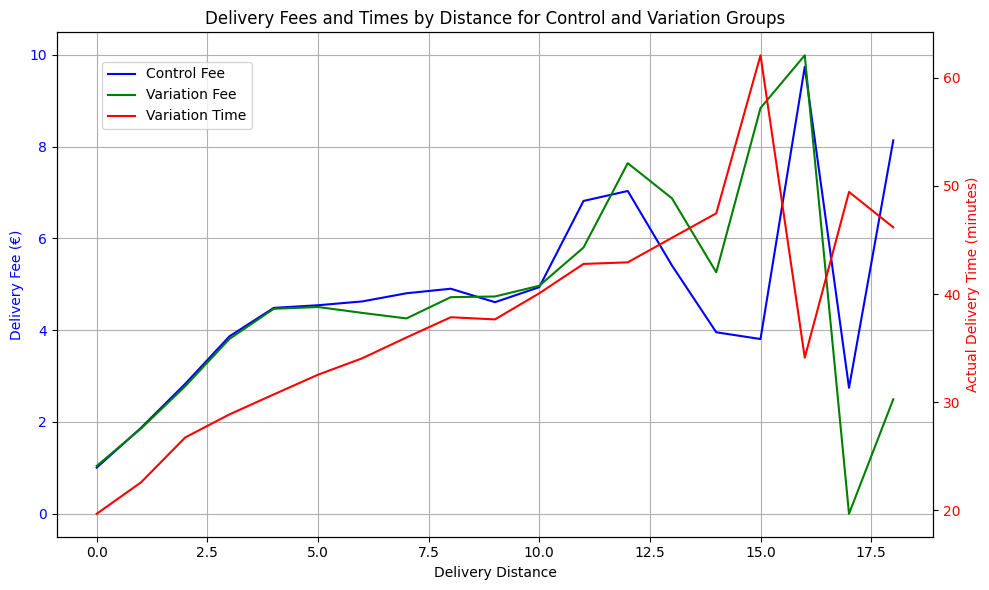

In [355]:
# Sort the table by delivery distance
a = table.sort_values(by=['delivery_distance'])

# Create the line chart with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the delivery fee on the primary y-axis
ax1.plot(a['delivery_distance'], a['delivery_fee_eur_Control'], label='Control Fee', color='b')
ax1.plot(a['delivery_distance'], a['delivery_fee_eur_Variation1'], label='Variation Fee', color='g')
ax1.set_xlabel('Delivery Distance')
ax1.set_ylabel('Delivery Fee (€)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis to plot the actual delivery time
ax2 = ax1.twinx()
ax2.plot(a['delivery_distance'], a['actual_delivery_time_Variation1'], label='Variation Time', color='r')
ax2.set_ylabel('Actual Delivery Time (minutes)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding labels and title
plt.title('Delivery Fees and Times by Distance for Control and Variation Groups')
fig.tight_layout()  # To prevent labels from overlapping

# Show the plot
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
ax1.grid(True)
plt.show()

In [ ]:
# Load data
data = finland_details.copy()

data = data[data['category'] == 'standard']

# Data Cleaning
data.dropna(inplace=True)

# Create 4 quantile-based buckets without labels first
data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=4)

# Get the quantile ranges
quantile_ranges = data['distance_bucket'].unique()

# Create a mapping for the new labels based on the quantile ranges
labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# Create a dictionary to map the original intervals to the new labels
label_mapping = dict(zip(quantile_ranges, labels))

# Apply the new labels to the distance_bucket column
data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

labels = data['distance_bucket'].unique()


# Segmentation Analysis
segmented_data = data.groupby(['distance_bucket', 'city_name', 'variant'])['delivery_fee_eur'].mean().unstack()
segmented_data['difference'] = segmented_data['Variation1'] - segmented_data['Control']

# Print segmented data for inspection
print(segmented_data)

# Visualize segmented analysis
segmented_data['difference'].unstack(level=0).plot(kind='bar', figsize=(14, 7))
plt.title('Average Delivery Fee Difference by Segment')
plt.xlabel('Distance Bucket')
plt.ylabel('Average Delivery Fee Difference')
plt.legend(title='Vendor')
plt.show()

data['delivery_fee_eur'] = pd.to_numeric(data['delivery_fee_eur'], errors='coerce')

# Statistical Testing for each bucket
for label in labels:
    control_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Control')]['delivery_fee_eur']
    variation_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Variation1')]['delivery_fee_eur']
    t_stat, p_val = stats.ttest_ind(variation_fees, control_fees)
    print(f"Distance Bucket {label}: t_stat={t_stat}, p_val={p_val}")

import pandas as pd
import statsmodels.api as sm
import numpy as np

# Assuming df is your DataFrame
# Selecting the relevant columns
X = data[['delivery_distance', 'vendor_id', 'city_name']]

# Turning categorical variables into dummy/indicator variables (0s and 1s)
X = pd.get_dummies(X, drop_first=True)

# Check and ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling them with 0 or any appropriate value
X = X.fillna(0)

# Convert boolean values to integers (0s and 1s)
X = X.astype(int)

# The target variable
y = data['delivery_fee_eur']

# Handle missing values in the target variable if necessary
y = y.fillna(0)

# Ensure that y is numeric
y = pd.to_numeric(y, errors='coerce')

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Fitting the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# Displaying the model summary
print(model.summary())

In [79]:
# a = pd.DataFrame({"Control": [""],"Variation1":[""],"% Change":[""]})

# # Creates pandas DataFrame.
# b = pd.DataFrame(a, index=['Austria'])

# c = pd.concat([finland_sum, a, austria_sum])

# c


In [ ]:
# # Read the Excel file with all sheets
# file_path = "/Users/shazeb.asad/Downloads/AT-FI savers Model.xlsx"
# vendors = pd.read_excel(file_path, sheet_name=None)

# # Function to get a specific sheet
# def get_sheet(path, sheet_name):
#     return pd.read_excel(path, sheet_name=sheet_name)

# # Dictionary to store DataFrames
# dataframes = {}

# # Iterate through sheet names and store DataFrames in the dictionary
# for sheet_name in vendors.keys():
#     dataframes[sheet_name] = get_sheet(file_path, sheet_name)
#     print(sheet_name)


# def read_excel_sheets(file_path):
    
#     vendors = pd.read_excel(file_path, sheet_name=None)
    
#     def get_sheet(path, sheet_name):
#         return pd.read_excel(path, sheet_name=sheet_name)
    
#     dataframes = {}
#     for sheet_name in vendors.keys():
#         dataframes[sheet_name] = get_sheet(file_path, sheet_name)
    
#     return dataframes

# # Example usage
# file_path = "/Users/shazeb.asad/Downloads/AT-FI savers Model.xlsx"
# dataframes = read_excel_sheets(file_path)

# # Access and work with the DataFrames
# sheet_name = "Data"  
# df_sheet1 = dataframes[sheet_name]

# # Filter the DataFrame where 'Vendor savers Flag' is 'No Savers'
# filtered_df = df_sheet1[df_sheet1['Vendor savers Flag'] == 'No Savers']

# # Group by 'entity_id' and create lists of unique 'chain_id'
# result = filtered_df.groupby('entity_id')['chain_id'].apply(lambda x: list(set(x)))

# # Convert the result to a dictionary of lists
# #result_dict = result.set_index('entity_id')['chain_id'].to_dict()

# filtered_chain_id_austria_lst = result_dict.get('MJM_AT')
# filtered_chain_id_finland_lst = result_dict.get('PO_FI')

# finland_lst = ", ".join(f"'{item}'" for item in filtered_chain_id_finland_lst)
# austria_lst =  ", ".join(f"'{item}'" for item in filtered_chain_id_austria_lst)

In [32]:
# ## Austria Analysis ##

# austria_all_chains_d = client.query(austria_all).to_dataframe()
# austria_chains_d = client.query(austria_chains).to_dataframe()

# austria_combined_summary = pd.concat([austria_all_chains_d, austria_chains_d])
# austria_combined_summary


In [35]:
# finland_chains_d

In [33]:
# ## Finland Data ##

# finland_all_chains_d = client.query(finland_all).to_dataframe()
# finland_chains_d = client.query(finland_chains).to_dataframe()

# finland_combined_summary = pd.concat([finland_all_chains_d, finland_chains_d])
# finland_combined_summary

In [34]:
# austria_combined_summary[(austria_combined_summary['category'].isin(['priority','standard'])) & (austria_combined_summary['target_group'].isin(['Chains in targeting','Chains not in targeting']))]

In [22]:
# query = f"""
# WITH perseus AS (
# SELECT
# *,
# LEFT(assignment_user_id, LENGTH(assignment_user_id) - 5) AS trim_assignment_user_id,
# ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
# FROM
# `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
# WHERE
# is_valid_assignment = 1
# AND test_id = "saver-delivery"
# AND assignment_date >= "2024-05-06"
# AND assignment_date<"2024-06-17"
# )
# SELECT
# p.country,
# m.entity_id,
# p.variant,
# m.is_sent,
# CASE
#     WHEN COALESCE(m.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
#     WHEN COALESCE(m.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
#     WHEN COALESCE(m.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
# END AS category,
# COUNT(DISTINCT m.platform_order_code) AS total_orders,
# ROUND(SUM(m.profit_eur),2) as total_profit,
# ROUND(SUM(m.delivery_fee_eur),2) as total_df,
# ROUND(SUM(m.gfv_eur),2) as total_gfv,
# ROUND(SUM(m.revenue_eur),2) as total_revenue,
# ROUND(SUM(m.delivery_costs_eur),2) as total_delivery_cost,
# ROUND(SUM(m.profit_eur) / COUNT(DISTINCT m.platform_order_code), 2) AS avg_profit,
# ROUND(SUM(m.revenue_eur) / COUNT(DISTINCT m.platform_order_code), 2) AS avg_revenue,
# ROUND(SUM(m.delivery_fee_eur) / COUNT(DISTINCT m.platform_order_code), 2) AS avg_df,
# ROUND(SUM(m.gfv_eur) / COUNT(DISTINCT m.platform_order_code), 2) AS avg_gfv,
# ROUND(SUM(m.delivery_costs_eur) / COUNT(DISTINCT m.platform_order_code), 2) AS avg_delivery_cost,
# ROUND(SUM(m.commission_eur) / COUNT(DISTINCT m.platform_order_code), 2) AS avg_commission
# FROM
# perseus p
# INNER JOIN
# `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` m
# ON
# m.country_name = p.country
# AND m.customer_account_id = p.trim_assignment_user_id
# WHERE
# p.row_num = 1
# AND m.created_date >= p.assignment_date
# AND m.entity_id IN (""" + entity_id + """)
# GROUP BY
# 1,2,3,4,5
# ORDER BY p.variant
# """


# test_results = client.query(query).to_dataframe()
# test_results

In [26]:
# test_results['entity_id'].unique()

In [25]:
# def func(x):
#     profit_per_order = round(x['total_profit'] / x['total_orders'], 2)
#     revenue_per_order = round(x['total_revenue'] / x['total_orders'], 2)
#     delivery_cost_per_order = round(x['total_delivery_costs'] / x['total_orders'], 2)
#     delivery_fee_per_order = round(x['total_delivery_fee_eur'] / x['total_orders'], 2)
#     return pd.DataFrame({
#         "profit_per_order": profit_per_order,
#         "delivery_cost_per_order": delivery_cost_per_order,
#         "revenue_per_order": revenue_per_order,
#         "delivery_fee_per_order": delivery_fee_per_order
#     })

# # Apply the function to each group
# finished_orders = test_results[test_results['is_sent'] == True]
# result = finished_orders.groupby(["category", "variant"]).apply(func).reset_index(level=[2], drop=True).reset_index()
# result

In [30]:
# vendors.keys()

Model
FI
AT
Data
AT_filtered
FI_filtered
Query_AT
Query_FI
Time of day


In [29]:






# # Create the formatted string with parentheses
# formatted_list_austria = '(' + ', '.join(filtered_chain_id_austria_lst) + ')'
# formatted_list_finland = '(' + ', '.join(filtered_chain_id_finland_lst) + ')'

# # Remove the apostrophes and the parentheses
# formatted_list_austria = formatted_list_austria.replace("'", "").replace("(", "").replace(")", "").strip()
# formatted_austria = tuple(item.strip() for item in formatted_list_austria.split(",") if item.strip())

# # Remove the apostrophes and the parentheses
# cleaned_string_finland = formatted_list_finland.replace("'", "").replace("(", "").replace(")", "").strip()
# formatted_finland = tuple(item.strip() for item in cleaned_string_finland.split(",") if item.strip())


NameError: name 'filtered_chain_id_finland_lst' is not defined

In [36]:
# # define a few things (project id, start date etc.)
# project_id = "logistics-customer-staging"
# client = bigquery.Client(project = project_id)
# entity_id = "'MJM_AT'"
# start_date = '2024-05-06'
# end_date = '2024-06-17'



# test_results = client.query(query).to_dataframe()
# test_results

In [37]:
# display(test_results)

In [38]:
# test_results.pivot_table(index=['total_orders','total_users','total_revenue','total_delivery_costs','total_profit','total_delivery_fee_eur','actual_delivery_time','delivery_distance','avg_profit','avg_revenue','avg_df','avg_delivery_cost','avg_commission'], columns='variant', values=['total_orders','total_users','total_revenue','total_delivery_costs','total_profit','total_delivery_fee_eur','actual_delivery_time','delivery_distance','avg_profit','avg_revenue','avg_df','avg_delivery_cost','avg_commission'], aggfunc='first')


In [39]:
# a = 87616.0/27812.0
# b = 88061.0/27757.0

# profit_a = 196606.61 / 87616.0
# profit_b = 200960.40 / 88061.0

In [40]:
# print(a,b)
# print(profit_a, profit_b)

In [81]:
# (3.1725690816730916 - 3.1502948367611103) / 3.1502948367611103

In [82]:
# 0.0070705270668830235 * 100

In [83]:
# 647380.14 - 641734.41

In [84]:
# entity_id = "'MJM_AT', 'PO_FI'"


# query = f"""
# WITH perseus AS (
# SELECT
# *,
# LEFT(assignment_user_id, LENGTH(assignment_user_id) - 5) AS trim_assignment_user_id,
# ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
# FROM
# `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
# WHERE
# is_valid_assignment = 1
# AND test_id = "saver-delivery"
# AND assignment_date >= "2024-05-06"
# AND assignment_date<"2024-06-17"
# )
# SELECT
# p.country,
# o.entity_id,
# p.variant,
# o.is_sent,
# CASE
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
#     WHEN COALESCE(o.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
# END AS category,
# ROUND(SUM(o.revenue_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_revenue,
# ROUND(SUM(o.delivery_costs_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_delivery_cost,
# ROUND(SUM(o.profit_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_profit,
# ROUND(SUM(o.delivery_fee_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_df,
# ROUND(SUM(o.commission_eur) / COUNT(DISTINCT o.platform_order_code), 2) AS avg_commission,
# ROUND(AVG(o.delivery_distance), 2) AS avg_delivery_distance
# FROM
# perseus p
# INNER JOIN
# `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
# ON
# o.country_name = p.country
# AND o.customer_account_id = p.trim_assignment_user_id
# WHERE
# p.row_num = 1
# AND o.created_date >= p.assignment_date
# AND o.entity_id IN  ( """ + entity_id + """ )
# --AND o.chain_id NOT IN ( """ + finland_lst + """ )
# AND is_sent = True
# GROUP BY
# 1,2,3,4,5
# ORDER BY o.is_sent, category , p.variant, o.entity_id
# """


# test_results = client.query(query).to_dataframe()
# test_results

In [86]:
# entity_id = "'MJM_AT','PO_FI'"

# query = f"""
# WITH perseus AS (
# SELECT
# *,
# LEFT(assignment_user_id, LENGTH(assignment_user_id) - 5) AS trim_assignment_user_id,
# ROW_NUMBER() OVER (PARTITION BY assignment_user_id ORDER BY assignment_date) AS row_num
# FROM
# `fulfillment-dwh-production.pandata_report.product__evaluation_fct_assignment_perseus`
# WHERE
# is_valid_assignment = 1
# AND test_id = "saver-delivery"
# AND assignment_date >= "2024-05-06"
# AND assignment_date<"2024-06-17"
# )
# SELECT
# p.country,
# o.city_name,
# o.entity_id,
# p.variant,
# CASE
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is null THEN 'standard'
#     WHEN COALESCE(o.priority_fee_eur, 0) = 0 AND saver_discount_eur is not null THEN 'saver'
#     WHEN COALESCE(o.priority_fee_eur, 0) > 0 AND saver_discount_eur is null THEN 'priority'
# END AS category,
# o.vendor_id,
# o.chain_id,
# o.platform_order_code,
# o.revenue_eur,
# o.delivery_costs_eur AS avg_delivery_cost,
# o.profit_eur avg_profit,
# o.delivery_fee_eur,
# o.commission_eur,
# o.delivery_distance,
# FROM
# perseus p
# INNER JOIN
# `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` o
# ON
# o.country_name = p.country
# AND o.customer_account_id = p.trim_assignment_user_id
# WHERE
# p.row_num = 1
# AND o.created_date >= p.assignment_date
# AND o.entity_id = 'PO_FI'
# AND o.chain_id NOT IN ( """ + finland_lst + """ )
# AND is_sent = True
# ORDER BY o.is_sent, category , p.variant, o.entity_id
# """


# test_results = client.query(query).to_dataframe()
# test_results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
data = test_results.copy()

data = data[data['category'] == 'standard']

# Data Cleaning
data.dropna(inplace=True)

# Create 4 quantile-based buckets without labels first
data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=4)

# Get the quantile ranges
quantile_ranges = data['distance_bucket'].unique()

# Create a mapping for the new labels based on the quantile ranges
labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# Create a dictionary to map the original intervals to the new labels
label_mapping = dict(zip(quantile_ranges, labels))

# Apply the new labels to the distance_bucket column
data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

labels = data['distance_bucket'].unique()


# Segmentation Analysis
segmented_data = data.groupby(['distance_bucket', 'city_name', 'variant'])['delivery_fee_eur'].mean().unstack()
segmented_data['difference'] = segmented_data['Variation1'] - segmented_data['Control']

# Print segmented data for inspection
print(segmented_data)

# Visualize segmented analysis
segmented_data['difference'].unstack(level=0).plot(kind='bar', figsize=(14, 7))
plt.title('Average Delivery Fee Difference by Segment')
plt.xlabel('Distance Bucket')
plt.ylabel('Average Delivery Fee Difference')
plt.legend(title='Vendor')
plt.show()

data['delivery_fee_eur'] = pd.to_numeric(data['delivery_fee_eur'], errors='coerce')

# Statistical Testing for each bucket
for label in labels:
    control_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Control')]['delivery_fee_eur']
    variation_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Variation1')]['delivery_fee_eur']
    t_stat, p_val = stats.ttest_ind(variation_fees, control_fees)
    print(f"Distance Bucket {label}: t_stat={t_stat}, p_val={p_val}")

import pandas as pd
import statsmodels.api as sm
import numpy as np

# Assuming df is your DataFrame
# Selecting the relevant columns
X = data[['delivery_distance', 'vendor_id', 'city_name']]

# Turning categorical variables into dummy/indicator variables (0s and 1s)
X = pd.get_dummies(X, drop_first=True)

# Check and ensure all columns are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle missing values by filling them with 0 or any appropriate value
X = X.fillna(0)

# Convert boolean values to integers (0s and 1s)
X = X.astype(int)

# The target variable
y = data['delivery_fee_eur']

# Handle missing values in the target variable if necessary
y = y.fillna(0)

# Ensure that y is numeric
y = pd.to_numeric(y, errors='coerce')

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Fitting the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# Displaying the model summary
print(model.summary())


NameError: name 'test_results' is not defined

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_6129/1052278168.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmented_data = data.groupby(['distance_bucket', 'city_name', 'variant'])['delivery_fee_eur'].mean().unstack()


variant                       Control Variation1 difference
distance_bucket city_name                                  
0-0 km          Forssa            NaN        NaN        NaN
                Hameenlinna  1.123867   1.225632   0.101766
                Helsinki     1.246467   1.271269   0.024801
                Hyvinkaa     1.423333   1.535455   0.112121
                Imatra           1.49      1.115     -0.375
...                               ...        ...        ...
3-18 km         Tampere      5.371527    5.07073  -0.300797
                Tornio            NaN        NaN        NaN
                Turku        5.481134   4.673962  -0.807172
                Vaasa        5.754028   5.638919  -0.115109
                Valkeakoski       NaN        NaN        NaN

[132 rows x 3 columns]


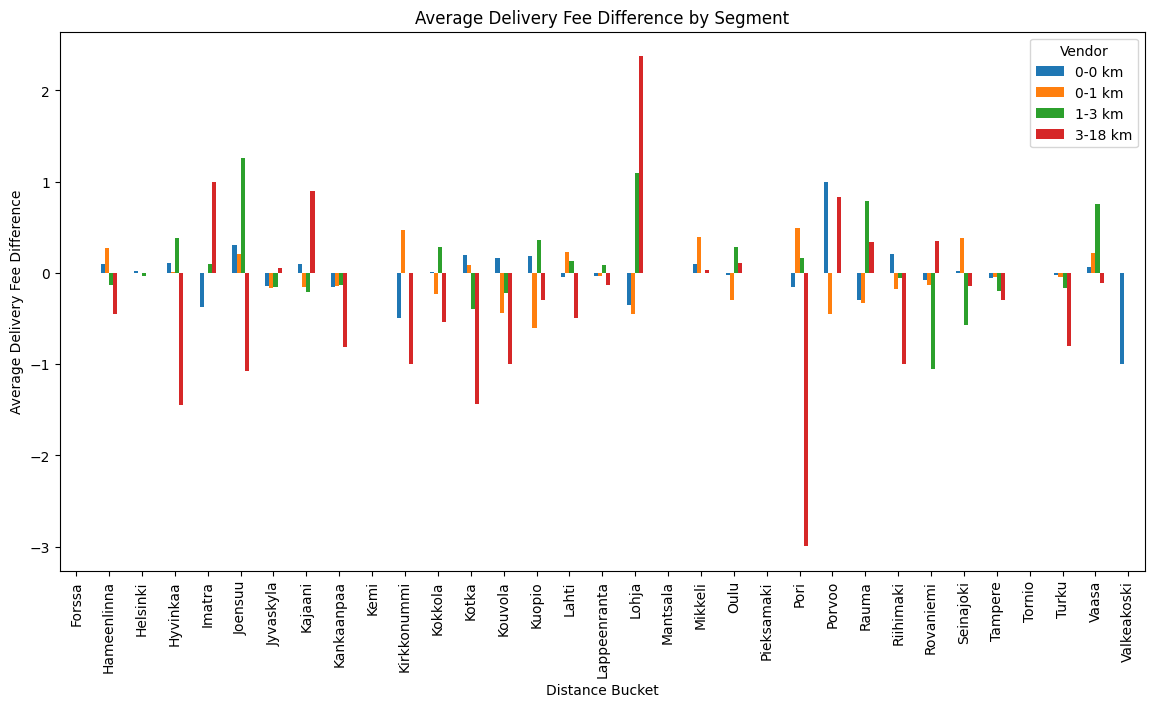

Distance Bucket 3-18 km: t_stat=-2.500398773085818, p_val=0.012418941741705701
Distance Bucket 1-3 km: t_stat=-1.541050803540661, p_val=0.12333149350104117
Distance Bucket 0-0 km: t_stat=0.11461253079817552, p_val=0.9087542150654975
Distance Bucket 0-1 km: t_stat=-1.1154123736719772, p_val=0.2646966821318368
                            OLS Regression Results                            
Dep. Variable:       delivery_fee_eur   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     127.6
Date:                Mon, 08 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:55:15   Log-Likelihood:                -88899.
No. Observations:               46766   AIC:                         1.783e+05
Df Residuals:                   46539   BIC:                         1.802e+05
Df Model:                         226                     

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
data = test_results.copy()

data = data[data['category'] == 'standard']

# Data Cleaning
data.dropna(inplace=True)

# Create 4 quantile-based buckets without labels first
data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=4)

# Get the quantile ranges
quantile_ranges = data['distance_bucket'].unique()

# Create a mapping for the new labels based on the quantile ranges
labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# Create a dictionary to map the original intervals to the new labels
label_mapping = dict(zip(quantile_ranges, labels))

# Apply the new labels to the distance_bucket column
data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

labels = data['distance_bucket'].unique()


# Segmentation Analysis
segmented_data = data.groupby(['distance_bucket', 'city_name', 'variant'])['delivery_fee_eur'].mean().unstack()
segmented_data['difference'] = segmented_data['Variation1'] - segmented_data['Control']

# Print segmented data for inspection
print(segmented_data)

# Visualize segmented analysis
segmented_data['difference'].unstack(level=0).plot(kind='bar', figsize=(14, 7))
plt.title('Average Delivery Fee Difference by Segment')
plt.xlabel('Distance Bucket')
plt.ylabel('Average Delivery Fee Difference')
plt.legend(title='Vendor')
plt.show()

data['delivery_fee_eur'] = pd.to_numeric(data['delivery_fee_eur'], errors='coerce')

# Statistical Testing for each bucket
for label in labels:
    control_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Control')]['delivery_fee_eur']
    variation_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Variation1')]['delivery_fee_eur']
    t_stat, p_val = stats.ttest_ind(variation_fees, control_fees)
    print(f"Distance Bucket {label}: t_stat={t_stat}, p_val={p_val}")

import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices

# Create 'group_binary' column
data['group_binary'] = data['variant'].apply(lambda x: 1 if x == 'Variation1' else 0)

# Create the design matrices using patsy
# This will include interaction terms between all the variables
y, X = dmatrices('delivery_fee_eur ~ group_binary * distance_bucket * city_name', data=data, return_type='dataframe')

# Fill missing values with a specific value, e.g., 0
X = X.dropna()

# Convert boolean values to integers (0s and 1s)
X = X.astype(int)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

# Extract the p-values
p_values = model.pvalues

# Filter the significant variables (e.g., p < 0.05)
significant_vars = p_values[p_values < 0.05]

# Display the significant variables and their coefficients
significant_summary = model.params[significant_vars.index]

print("\nSignificant Variables:")
print(significant_summary)

In [ ]:
# Extract the p-values
p_values = model.pvalues

# Identify interaction terms
interaction_terms = [term for term in p_values.index if ':' in term]

# Filter the significant interaction terms (e.g., p < 0.05)
significant_interactions = p_values[interaction_terms][p_values[interaction_terms] < 0.05]

# Display the significant interaction variables and their coefficients
significant_interaction_summary = model.params[significant_interactions.index]

print("\nSignificant Interaction Variables:")
print(significant_interaction_summary)


Significant Interaction Variables:
distance_bucket[T.0-1 km]:city_name[T.Kemi]                      -1.315858e+10
distance_bucket[T.3-18 km]:city_name[T.Kemi]                     -1.919970e+10
distance_bucket[T.3-18 km]:city_name[T.Mantsala]                  1.850017e+10
distance_bucket[T.0-1 km]:city_name[T.Pieksamaki]                 6.995244e+12
distance_bucket[T.1-3 km]:city_name[T.Pieksamaki]                -5.969788e+10
distance_bucket[T.3-18 km]:city_name[T.Pieksamaki]                1.449702e+10
group_binary:distance_bucket[T.3-18 km]:city_name[T.Kemi]        -4.592526e+09
group_binary:distance_bucket[T.0-1 km]:city_name[T.Mantsala]     -9.309630e+08
group_binary:distance_bucket[T.3-18 km]:city_name[T.Mantsala]    -2.846516e+09
group_binary:distance_bucket[T.1-3 km]:city_name[T.Pieksamaki]    3.917887e-03
dtype: float64


In [ ]:
X

,Intercept,distance_bucket[T.0-1 km],distance_bucket[T.1-3 km],distance_bucket[T.3-18 km],city_name[T.Hameenlinna],city_name[T.Helsinki],city_name[T.Hyvinkaa],city_name[T.Imatra],city_name[T.Joensuu],city_name[T.Jyvaskyla],...,group_binary:distance_bucket[T.3-18 km]:city_name[T.Tornio],group_binary:distance_bucket[T.0-1 km]:city_name[T.Turku],group_binary:distance_bucket[T.1-3 km]:city_name[T.Turku],group_binary:distance_bucket[T.3-18 km]:city_name[T.Turku],group_binary:distance_bucket[T.0-1 km]:city_name[T.Vaasa],group_binary:distance_bucket[T.1-3 km]:city_name[T.Vaasa],group_binary:distance_bucket[T.3-18 km]:city_name[T.Vaasa],group_binary:distance_bucket[T.0-1 km]:city_name[T.Valkeakoski],group_binary:distance_bucket[T.1-3 km]:city_name[T.Valkeakoski],group_binary:distance_bucket[T.3-18 km]:city_name[T.Valkeakoski]
2604,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2605,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2606,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2607,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2608,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49408,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49409,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49410,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49411,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Create 4 quantile-based buckets without labels first
data['distance_bucket'] = pd.qcut(data['delivery_distance'], q=4)

# Get the quantile ranges
quantile_ranges = data['distance_bucket'].unique()

# Create a mapping for the new labels based on the quantile ranges
labels = [f"{int(q.left)}-{int(q.right)} km" for q in quantile_ranges]

# Create a dictionary to map the original intervals to the new labels
label_mapping = dict(zip(quantile_ranges, labels))

# Apply the new labels to the distance_bucket column
data['distance_bucket'] = data['distance_bucket'].map(label_mapping)

In [ ]:
data['distance_bucket'].unique()

['3-18 km', '1-3 km', '0-0 km', '0-1 km']
Categories (4, object): ['0-0 km' < '0-1 km' < '1-3 km' < '3-18 km']

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_6129/2021235251.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segmented_data = data.groupby(['distance_bucket', 'city_name', 'variant'])['delivery_fee_eur'].mean().unstack()


variant                       Control Variation1 difference
distance_bucket city_name                                  
0-5 km          Forssa            NaN        0.0        NaN
                Hameenlinna  2.839881   2.839427  -0.000454
                Helsinki     2.390576   2.359968  -0.030608
                Hyvinkaa     2.869823   3.013188   0.143365
                Imatra       4.061429   2.656667  -1.404762
...                               ...        ...        ...
50-100 km       Tampere           NaN        NaN        NaN
                Tornio            NaN        NaN        NaN
                Turku             NaN        NaN        NaN
                Vaasa             NaN        NaN        NaN
                Valkeakoski       NaN        NaN        NaN

[165 rows x 3 columns]


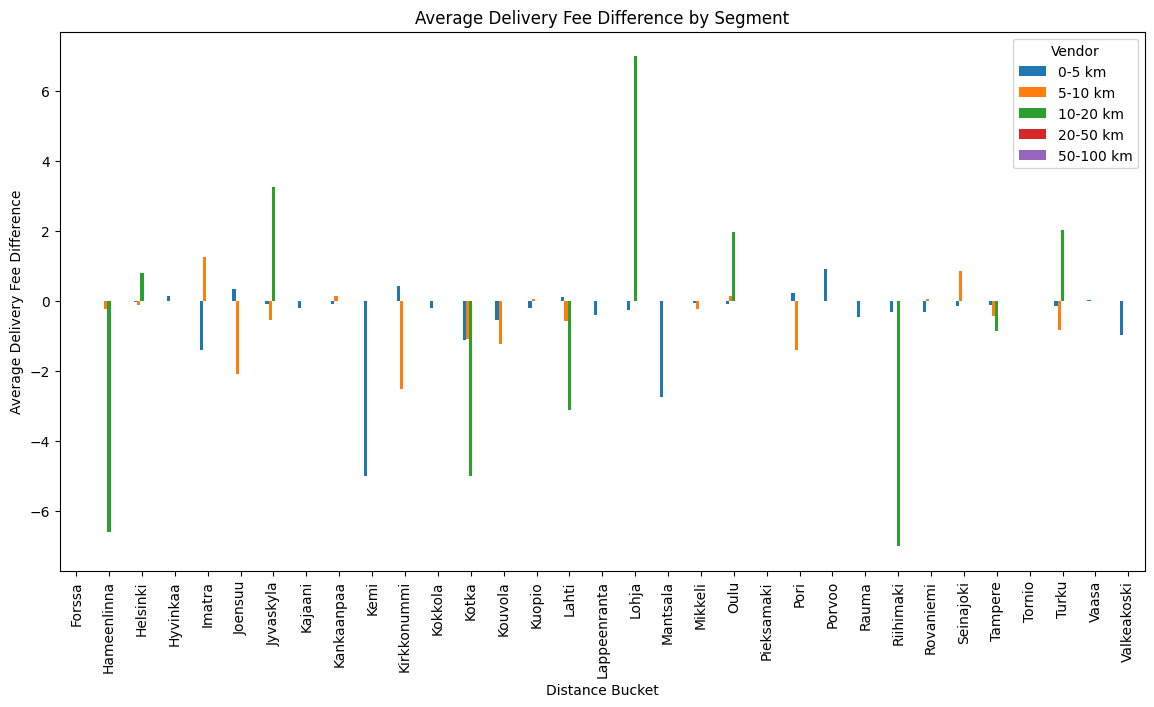

Distance Bucket 0-5 km: t_stat=3.7010957500859725, p_val=0.00021495286211499715
Distance Bucket 5-10 km: t_stat=2.650665454020481, p_val=0.008057061406532555
Distance Bucket 10-20 km: t_stat=-0.6795405442893548, p_val=0.4970329597007124
Distance Bucket 20-50 km: t_stat=nan, p_val=nan
Distance Bucket 50-100 km: t_stat=nan, p_val=nan
                            OLS Regression Results                            
Dep. Variable:       delivery_fee_eur   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     226.5
Date:                Mon, 08 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:05:36   Log-Likelihood:                -96510.
No. Observations:               46766   AIC:                         1.931e+05
Df Residuals:                   46730   BIC:                         1.934e+05
Df Model:                         

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load data
data = test_results.copy()

data = data[data['category'] == 'standard']

# Data Cleaning
data.dropna(inplace=True)

# Define distance buckets
bins = [0, 5, 10, 20, 50, 100]
labels = ['0-5 km', '5-10 km', '10-20 km', '20-50 km', '50-100 km']
data['distance_bucket'] = pd.cut(data['delivery_distance'], bins=bins, labels=labels)

# Segmentation Analysis
segmented_data = data.groupby(['distance_bucket', 'city_name', 'variant'])['delivery_fee_eur'].mean().unstack()
segmented_data['difference'] = segmented_data['Variation1'] - segmented_data['Control']

# Print segmented data for inspection
print(segmented_data)

# Visualize segmented analysis
segmented_data['difference'].unstack(level=0).plot(kind='bar', figsize=(14, 7))
plt.title('Average Delivery Fee Difference by Segment')
plt.xlabel('Distance Bucket')
plt.ylabel('Average Delivery Fee Difference')
plt.legend(title='Vendor')
plt.show()

data['delivery_fee_eur'] = pd.to_numeric(data['delivery_fee_eur'], errors='coerce')

# Statistical Testing for each bucket
for label in labels:
    control_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Control')]['delivery_fee_eur']
    variation_fees = data[(data['distance_bucket'] == label) & (data['variant'] == 'Variation1')]['delivery_fee_eur']
    t_stat, p_val = stats.ttest_ind(control_fees, variation_fees)
    print(f"Distance Bucket {label}: t_stat={t_stat}, p_val={p_val}")

# Multivariate Analysis
import statsmodels.api as sm

data['group_binary'] = data['variant'].apply(lambda x: 1 if x == 'Variation1' else 0)
X = data[['group_binary', 'distance_bucket', 'city_name']]
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to dummy variables
# Fill missing values with a specific value, e.g., 0
X = X.fillna(0)

# Convert boolean values to integers (0s and 1s)
X = X.astype(int)
y = data['delivery_fee_eur']

model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

# Extract the p-values
p_values = model.pvalues

# Filter the significant variables (e.g., p < 0.05)
significant_vars = p_values[p_values < 0.05]

# Display the significant variables and their coefficients
significant_summary = model.params[significant_vars.index]

print("\nSignificant Variables:")
print(significant_summary)

In [ ]:
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices

# Create 'group_binary' column
data['group_binary'] = data['variant'].apply(lambda x: 1 if x == 'Variation1' else 0)

# Create the design matrices using patsy
# This will include interaction terms between all the variables
y, X = dmatrices('delivery_fee_eur ~ group_binary * distance_bucket * city_name * vendor_id', data=data, return_type='dataframe')

# Fill missing values with a specific value, e.g., 0
X = X.fillna(0)

# Convert boolean values to integers (0s and 1s)
X = X.astype(int)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

# Extract the p-values
p_values = model.pvalues

# Filter the significant variables (e.g., p < 0.05)
significant_vars = p_values[p_values < 0.05]

# Display the significant variables and their coefficients
significant_summary = model.params[significant_vars.index]

print("\nSignificant Variables:")
print(significant_summary)

In [ ]:
significant_summary

distance_bucket[T.20-50 km]:city_name[T.Helsinki]       -7.768213e+07
distance_bucket[T.10-20 km]:city_name[T.Imatra]         -6.853452e+07
distance_bucket[T.20-50 km]:city_name[T.Joensuu]        -8.955931e+07
distance_bucket[T.50-100 km]:city_name[T.Kajaani]       -2.055526e+08
distance_bucket[T.5-10 km]:city_name[T.Kemi]             1.189705e+08
distance_bucket[T.20-50 km]:city_name[T.Kemi]            1.645378e+08
distance_bucket[T.20-50 km]:city_name[T.Kokkola]        -1.061866e+08
distance_bucket[T.50-100 km]:city_name[T.Kokkola]        6.003730e+07
distance_bucket[T.50-100 km]:city_name[T.Kotka]          1.557657e+08
distance_bucket[T.10-20 km]:city_name[T.Kuopio]          1.212723e+08
distance_bucket[T.20-50 km]:city_name[T.Lappeenranta]   -1.834904e+08
distance_bucket[T.5-10 km]:city_name[T.Mantsala]         7.021072e+07
distance_bucket[T.10-20 km]:city_name[T.Mantsala]        8.193939e+07
distance_bucket[T.20-50 km]:city_name[T.Mikkeli]        -5.659068e+07
distance_bucket[T.50

In [ ]:
import statsmodels.api as sm
from patsy import dmatrices

# Create 'group_binary' column if not already created
data['group_binary'] = data['variant'].apply(lambda x: 1 if x == 'Variation1' else 0)

# Create the design matrices using patsy
# Include individual variables and their interaction terms
formula = 'delivery_fee_eur ~ group_binary + distance_bucket + city_name + group_binary:distance_bucket + group_binary:city_name + distance_bucket:city_name + group_binary:distance_bucket:city_name'
y, X = dmatrices(formula, data=data, return_type='dataframe')

# Fit the model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

# Extract the p-values
p_values = model.pvalues

# Filter the significant variables (e.g., p < 0.05)
significant_vars = p_values[p_values < 0.05]

# Display the significant variables and their coefficients
significant_summary = model.params[significant_vars.index]

print("\nSignificant Variables:")
print(significant_summary)

                            OLS Regression Results                            
Dep. Variable:       delivery_fee_eur   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     65.91
Date:                Mon, 08 Jul 2024   Prob (F-statistic):               0.00
Time:                        16:21:40   Log-Likelihood:                -95980.
No. Observations:               46766   AIC:                         1.922e+05
Df Residuals:                   46626   BIC:                         1.935e+05
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
                                                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

array([<Axes: title={'center': 'Control'}, ylabel='Frequency'>,
       <Axes: title={'center': 'Variation1'}, ylabel='Frequency'>],
      dtype=object)

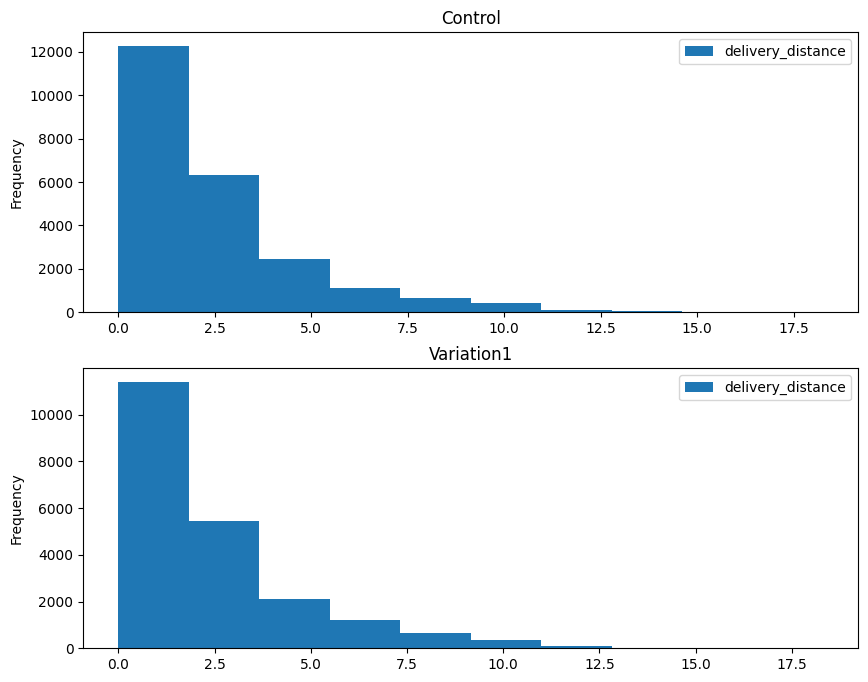

In [ ]:
import matplotlib

df = test_results[test_results['category'] == 'standard']
df.plot.hist(column=["delivery_distance"], by="variant", figsize=(10, 8))

In [ ]:
df.groupby('variant')['delivery_distance'].describe()

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
Control,23468.0,2.474992,2.326045,0.001,0.927,1.7285,3.152,18.262
Variation1,21341.0,2.463860,2.292493,0.001,0.906,1.6820,3.175,18.306


In [ ]:
!pip3 install statsmodels

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.1 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 14.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
# Assuming df is your DataFrame
# Selecting the relevant columns
X = df[['delivery_distance', 'vendor_id', 'city_name']]

# Turning categorical variables into dummy/indicator variables (0s and 1s)
X = pd.get_dummies(X, drop_first=True)

# Fill missing values with a specific value, e.g., 0
X = X.fillna(0)

# Convert boolean values to integers (0s and 1s)
X = X.astype(int)

# The target variable
y = df['delivery_fee_eur']

# Fill missing values in the target variable if necessary
y = y.fillna(0)

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Fitting the Ordinary Least Squares (OLS) model
model = sm.OLS(y, X).fit()

# Displaying the model summary
print(model.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
df

,country,city_name,entity_id,variant,category,vendor_id,chain_id,platform_order_code,revenue_eur,avg_delivery_cost,avg_profit,delivery_fee_eur,commission_eur,delivery_distance
0,Finland,Helsinki,PO_FI,Control,priority,zsaa,ck6es,zsaa-2425-xwot,14.723158,4.500000,10.223158,1.990000000,10.960000000,0.855
1,Finland,Helsinki,PO_FI,Control,priority,caf5,s3oj,caf5-2425-2lqf,18.164386,12.210000,5.954386,5.990000000,10.410000000,6.570
2,Finland,Tampere,PO_FI,Control,priority,adq9,ci8fe,adq9-2425-mrq0,15.697018,17.720000,-2.022982,5.990000000,6.890000000,10.198
3,Finland,Helsinki,PO_FI,Control,priority,otqb,cr9vc,otqb-2421-fn7f,13.264912,5.503961,7.760951,0E-9,11.300000000,0.775
4,Finland,Turku,PO_FI,Control,priority,kcgn,cn2pi,kcgn-2421-6ix1,6.064912,0.002422,6.062491,0E-9,4.100000000,1.407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49408,Finland,Helsinki,PO_FI,Variation1,standard,n4pf,ca4tp,n4pf-2419-sa0a,11.291228,7.116320,4.174908,2.990000000,1.750000000,3.216
49409,Finland,Helsinki,PO_FI,Variation1,standard,nfbd,cw1rn,nfbd-2419-rjli,6.851228,4.968892,1.882336,2.990000000,3.360000000,1.801
49410,Finland,Tampere,PO_FI,Variation1,standard,s2ep,cn0vw,s2ep-2419-ji8x,14.782982,4.506918,10.276065,3.790000000,10.590000000,2.339
49411,Finland,Oulu,PO_FI,Variation1,standard,lmb9,cg0zf,lmb9-2419-ems4,11.522982,5.810790,5.712193,3.790000000,7.330000000,2.827


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit


# # Summary statistics
# summary = df.groupby('variation').agg({
#     'revenue': ['mean', 'median', 'std'],
#     'waiting_time': ['mean', 'median', 'std'],
#     'distance': ['mean', 'median', 'std']
# })


df = test_results.copy()

# Regression analysis
X = df[['delivery_distance', 'vendor_id','city_name']]
X = pd.get_dummies(X, drop_first=True)
y = df['delivery_fee_eur']
model = sm.OLS(y, sm.add_constant(X)).fit()

# # Interaction effects
# interaction_model = ols('revenue ~ fee * waiting_time * distance * vendor', data=df).fit()

# # Visualization
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='variation', y='revenue', data=df)
# plt.title('Revenue Distribution by Variation')
# plt.show()

# Report summary
print(summary)
print(f"T-test: t-statistic = {t_stat}, p-value = {p_value}")
print(model.summary())
print(interaction_model.summary())


                            OLS Regression Results                            
Dep. Variable:       delivery_fee_eur   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     47.88
Date:                Mon, 08 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:03:58   Log-Likelihood:                -89333.
No. Observations:               49413   AIC:                         1.806e+05
Df Residuals:                   48441   BIC:                         1.892e+05
Df Model:                         971                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    6.7

In [ ]:
X

,delivery_distance,vendor_id_a39u,vendor_id_a4q2,vendor_id_a6lf,vendor_id_a7iv,vendor_id_a7jh,vendor_id_a8es,vendor_id_adnc,vendor_id_adq9,vendor_id_aed0,...,city_name_Porvoo,city_name_Rauma,city_name_Riihimaki,city_name_Rovaniemi,city_name_Seinajoki,city_name_Tampere,city_name_Tornio,city_name_Turku,city_name_Vaasa,city_name_Valkeakoski
0,0.855,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,6.570,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,10.198,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,0.775,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.407,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49408,3.216,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49409,1.801,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49410,2.339,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
49411,2.827,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
